<a href="https://colab.research.google.com/github/RohanSubramani/Miscellaneous/blob/main/rs4126_RLHW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem 1 - Playing BlackJack

(Starts with the provided code.)

The following scripts first simulate a blackjack game based on a given policy, and estimate the value of each state. 

- Ace can be used as one or eleven. Faces are ten. All other cards are have their face value. 

- The object is to get cards one-by-one so that to get as high a sum as possible without going over 21. The game starts with you getting two cards, and the dealer getting two cards. The dealer reveals one of his cards. As you get cards you reveal them until you either go over 21 and lose or stop. At that point it is the dealer's turn to pick cards. He has a fixed startegy: He hits as long as his sum is less thn 17. He sticks when it is larger (regardless of what you have.) If he gets more than you without going bust, you lose (reward -1). If he goes bust  or sticks at less than you, then you win (reward +1), and if both have the smae sum the game is a draw (reward 0).

- A state is The total sum of faces one's cards have, from 11 to 21. (If total sum is smaller than 11, we have to choose *hit*, that is ask for another card, since there is no chance of losing and we can only improve our situation.) The dealer also has ten possible values ace-10, so the total is $10\times 10=100$. Also, if the dealer is showing an ace that can be used as 11 (not 1) he has a usable ace. Two cases of having or nothaving usable aces brings the total number of states to $2\times 100=200$. 

- Actions available at each state is *hit* (get a another card, or *stick* don't get another card and let the dealer paly. 

We now first calculate the value of each hand (state) under a fixed startegy using Monte Carlo method: (Here alwasy hit unless the sum is 20 or 21). Next, we find the optimal policy with "exploring starts" strategy. Finally we attemt to evaluate a policy using the "off-policy" technique of importance sampling.



First, code basic actions and policies:

In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Nicky van Foreest(vanforeest@gmail.com)                        #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#                                                                     #
# Slightly modified by Farid Alizadeh                                 #
#######################################################################

import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# actions: hit or stand
ACTION_HIT = 0
ACTION_STAND = 1  #  "strike" in the book
ACTIONS = [ACTION_HIT, ACTION_STAND]

# policy for player
POLICY_PLAYER = np.zeros(22, dtype=int)
for i in range(12, 20):
    POLICY_PLAYER[i] = ACTION_HIT
POLICY_PLAYER[20] = ACTION_STAND
POLICY_PLAYER[21] = ACTION_STAND

# function form of target policy of player
def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

# function form of behavior policy of player
def behavior_policy_player(usable_ace_player, player_sum, dealer_card):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

# policy for dealer
POLICY_DEALER = np.zeros(22)
for i in range(12, 17):
    POLICY_DEALER[i] = ACTION_HIT
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND

# get a new card
def get_card():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

# get the value of a card (11 for ace).
def card_value(card_id):
    return 11 if card_id == 1 else card_id

Next define how a play can proceeed:

In [ ]:
# play a game
# @policy_player: specify policy for player
# @initial_state: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# @initial_action: the initial action
def play(policy_player, initial_state=None, initial_action=None):
    # player status

    # sum of player
    player_sum = 0

    # trajectory of player
    player_trajectory = []

    # whether player uses Ace as 11
    usable_ace_player = False

    # dealer status
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False

    if initial_state is None:
        # generate a random initial state

        while player_sum < 12:
            # if sum of player is less than 12, always hit
            card = get_card()
            player_sum += card_value(card)

            # If the player's sum is larger than 21, he may hold one or two aces.
            if player_sum > 21:
                assert player_sum == 22
                # last card must be ace
                player_sum -= 10
            else:
                usable_ace_player |= (1 == card)

        # initialize cards of dealer, suppose dealer will show the first card he gets
        dealer_card1 = get_card()
        dealer_card2 = get_card()

    else:
        # use specified initial state
        usable_ace_player, player_sum, dealer_card1 = initial_state
        dealer_card2 = get_card()

    # initial state of the game
    state = [usable_ace_player, player_sum, dealer_card1]

    # initialize dealer's sum
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
    # if the dealer's sum is larger than 21, he must hold two aces.
    if dealer_sum > 21:
        assert dealer_sum == 22
        # use one Ace as 1 rather than 11
        dealer_sum -= 10
    assert dealer_sum <= 21
    assert player_sum <= 21

    # game starts!

    # player's turn
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            # get action based on current sum
            action = policy_player(usable_ace_player, player_sum, dealer_card1)

        # track player's trajectory for importance sampling
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action == ACTION_STAND:
            break
        # if hit, get new card
        card = get_card()
        # Keep track of the ace count. the usable_ace_player flag is insufficient alone as it cannot
        # distinguish between having one ace or two.
        ace_count = int(usable_ace_player)
        if card == 1:
            ace_count += 1
        player_sum += card_value(card)
        # If the player has a usable ace, use it as 1 to avoid busting and continue.
        while player_sum > 21 and ace_count:
            player_sum -= 10
            ace_count -= 1
        # player busts
        if player_sum > 21:
            return state, -1, player_trajectory
        assert player_sum <= 21
        usable_ace_player = (ace_count == 1)

    # dealer's turn
    while True:
        # get action based on current sum
        action = POLICY_DEALER[dealer_sum]
        if action == ACTION_STAND:
            break
        # if hit, get a new card
        new_card = get_card()
        ace_count = int(usable_ace_dealer)
        if new_card == 1:
            ace_count += 1
        dealer_sum += card_value(new_card)
        # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
        while dealer_sum > 21 and ace_count:
            dealer_sum -= 10
            ace_count -= 1
        # dealer busts
        if dealer_sum > 21:
            return state, 1, player_trajectory
        usable_ace_dealer = (ace_count == 1)

    # compare the sum between player and dealer
    assert player_sum <= 21 and dealer_sum <= 21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory

Now run the Monte Carlo sampling with exploring statesto evalueate a fixed policy (always hit except at 20 or 21, this is what the function $\texttt{target_policy_player}$ gives

In [ ]:
# Monte Carlo Sample with On-Policy
def monte_carlo_on_policy(episodes):
    states_usable_ace = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    states_usable_ace_count = np.ones((10, 10))
    states_no_usable_ace = np.zeros((10, 10))
    # initialze counts to 1 to avoid 0 being divided
    states_no_usable_ace_count = np.ones((10, 10))
    for i in tqdm(range(0, episodes)):
        _, reward, player_trajectory = play(target_policy_player)
        for (usable_ace, player_sum, dealer_card), _ in player_trajectory:
            player_sum -= 12
            dealer_card -= 1
            if usable_ace:
                states_usable_ace_count[player_sum, dealer_card] += 1
                states_usable_ace[player_sum, dealer_card] += reward
            else:
                states_no_usable_ace_count[player_sum, dealer_card] += 1
                states_no_usable_ace[player_sum, dealer_card] += reward
    return states_usable_ace / states_usable_ace_count, states_no_usable_ace / states_no_usable_ace_count

Now run find the optimal policy by Minte CArlo technique assuming *exploring starts* assumption

In [ ]:
# Monte Carlo with Exploring Starts
def monte_carlo_es(episodes):
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # behavior policy is greedy
    def behavior_policy(usable_ace, player_sum, dealer_card):
        usable_ace = int(usable_ace)
        player_sum -= 12
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        values_ = state_action_values[player_sum, dealer_card, usable_ace, :] / \
                  state_action_pair_count[player_sum, dealer_card, usable_ace, :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    for episode in tqdm(range(episodes)):
        # for each episode, use a randomly initialized state and action
        initial_state = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initial_action = np.random.choice(ACTIONS)
        current_policy = behavior_policy if episode else target_policy_player
        _, reward, trajectory = play(current_policy, initial_state, initial_action)
        first_visit_check = set()
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            state_action = (usable_ace, player_sum, dealer_card, action)
            if state_action in first_visit_check:
                continue
            first_visit_check.add(state_action)
            # update values of state-action pairs
            state_action_values[player_sum, dealer_card, usable_ace, action] += reward
            state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1

    return state_action_values / state_action_pair_count

Now run the off-policy method using standard importance samping:

In [ ]:
# Monte Carlo Sample with Off-Policy
def monte_carlo_off_policy(episodes):
    initial_state = [True, 13, 2]

    rhos = []
    returns = []

    for i in range(0, episodes):
        _, reward, player_trajectory = play(behavior_policy_player, initial_state=initial_state)

        # get the importance ratio
        numerator = 1.0
        denominator = 1.0
        for (usable_ace, player_sum, dealer_card), action in player_trajectory:
            if action == target_policy_player(usable_ace, player_sum, dealer_card):
                denominator *= 0.5
            else:
                numerator = 0.0
                break
        rho = numerator / denominator
        rhos.append(rho)
        returns.append(reward)

    rhos = np.asarray(rhos)
    returns = np.asarray(returns)
    weighted_returns = rhos * returns

    weighted_returns = np.add.accumulate(weighted_returns)
    rhos = np.add.accumulate(rhos)

    ordinary_sampling = weighted_returns / np.arange(1, episodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weighted_sampling = np.where(rhos != 0, weighted_returns / rhos, 0)

    return ordinary_sampling, weighted_sampling

Test the value estimation of a given policy by Mionte Carlo method:

In [ ]:
def figure_5_1():
    states_usable_ace_1, states_no_usable_ace_1 = monte_carlo_on_policy(10000)
    states_usable_ace_2, states_no_usable_ace_2 = monte_carlo_on_policy(500000)

    states = [states_usable_ace_1,
              states_usable_ace_2,
              states_no_usable_ace_1,
              states_no_usable_ace_2]

    titles = ['Usable Ace, 10000 Episodes',
              'Usable Ace, 500000 Episodes',
              'No Usable Ace, 10000 Episodes',
              'No Usable Ace, 500000 Episodes']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for state, title, axis in zip(states, titles, axes):
        fig = sns.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)

    #plt.savefig('../images/figure_5_1.png')
    plt.show()
    plt.close()

Find the optimal action for each state using Monte Carlo exploring starts

In [ ]:
def figure_5_2():
    state_action_values = monte_carlo_es(500000)

    state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
    state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

    # get the optimal policy
    action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
    action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

    images = [action_usable_ace,
              state_value_usable_ace,
              action_no_usable_ace,
              state_value_no_usable_ace]

    titles = ['Optimal policy with usable Ace',
              'Optimal value with usable Ace',
              'Optimal policy without usable Ace',
              'Optimal value without usable Ace']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for image, title, axis in zip(images, titles, axes):
        fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)

    #plt.savefig('../images/figure_5_2.png')
    plt.show()
    plt.close()

Run the offpolicy method using standard importance sampling:

In [ ]:
def figure_5_3():
    true_value = -0.27726
    episodes = 10000
    runs = 100
    error_ordinary = np.zeros(episodes)
    error_weighted = np.zeros(episodes)
    for i in tqdm(range(0, runs)):
        ordinary_sampling_, weighted_sampling_ = monte_carlo_off_policy(episodes)
        # get the squared error
        error_ordinary += np.power(ordinary_sampling_ - true_value, 2)
        print(error_ordinary)
        error_weighted += np.power(weighted_sampling_ - true_value, 2)
    error_ordinary /= runs
    error_weighted /= runs

    plt.plot(np.arange(1, episodes + 1), error_ordinary, color='green', label='Ordinary Importance Sampling')
    plt.plot(np.arange(1, episodes + 1), error_weighted, color='red', label='Weighted Importance Sampling')
    plt.ylim(-0.1, 5)
    plt.xlabel('Episodes (log scale)')
    plt.ylabel(f'Mean square error\n(average over {runs} runs)')
    plt.xscale('log')
    plt.legend()

    #plt.savefig('../images/figure_5_3.png')
    plt.show()
    plt.close()

Test everthing:

See Fig 5.1? y/n


100%|██████████| 500000/500000 [00:36<00:00, 13720.81it/s]


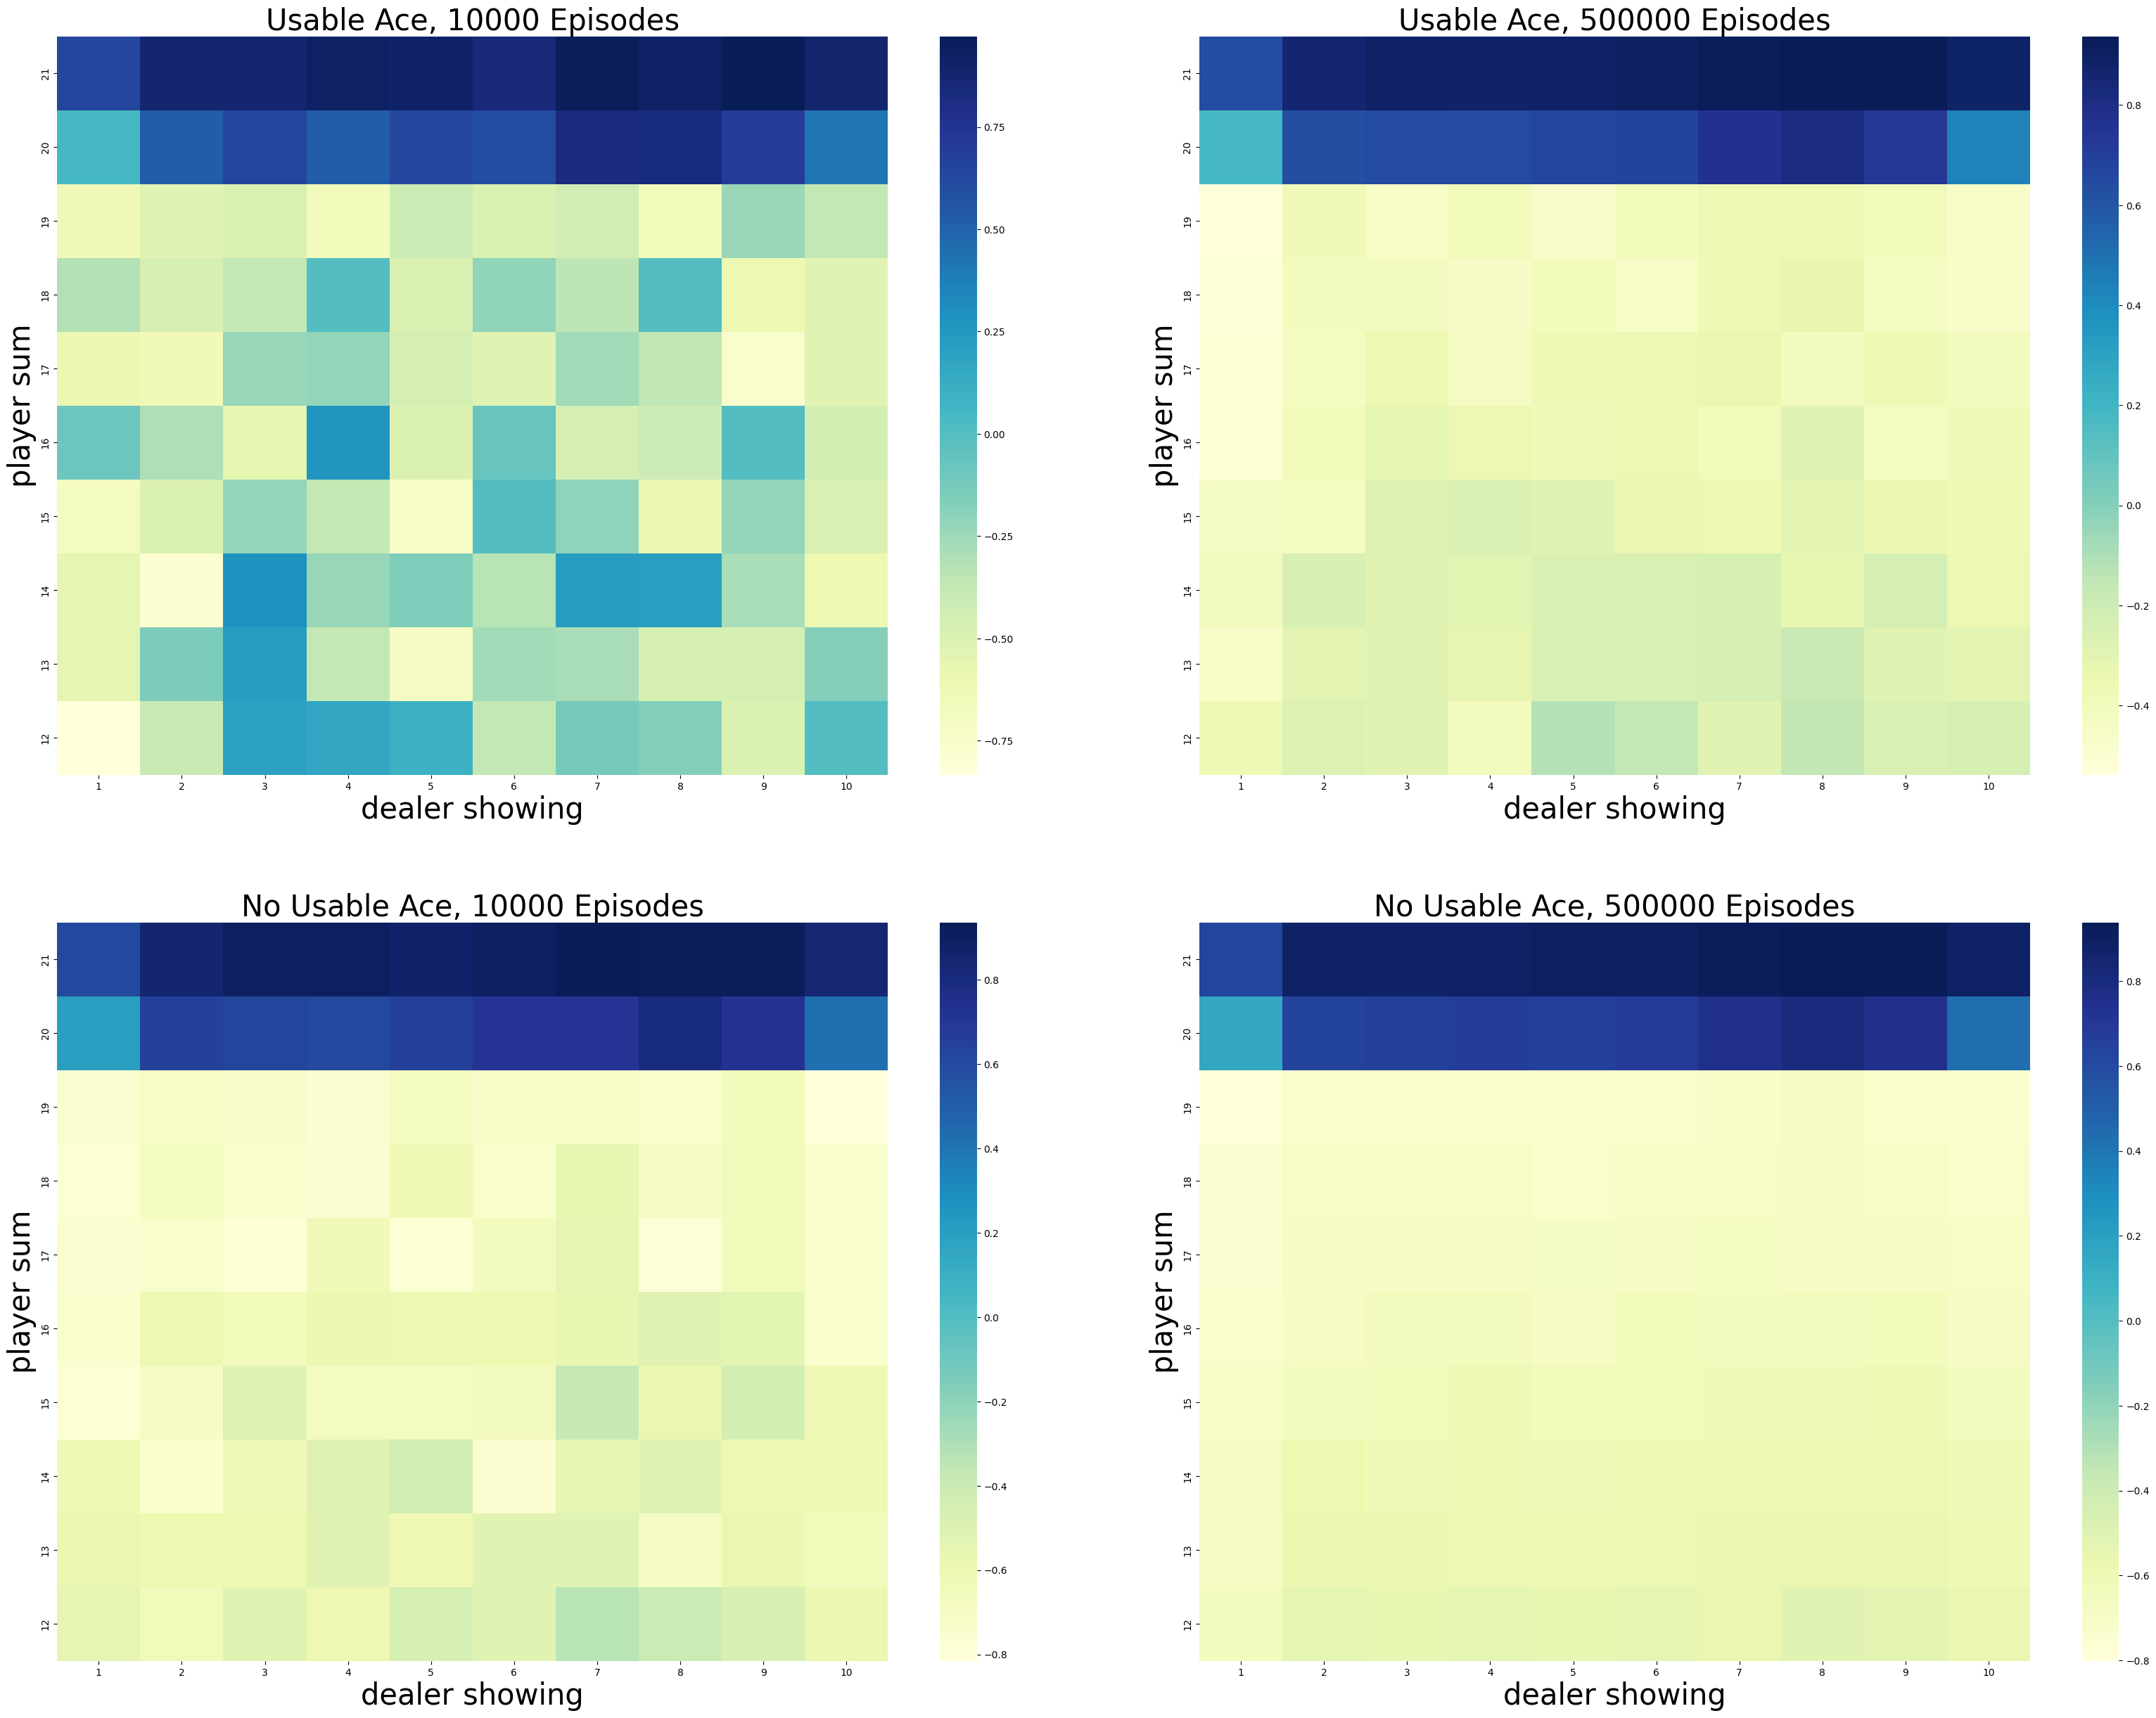

See Fig 5.2? y/ny


100%|██████████| 500000/500000 [01:13<00:00, 6839.78it/s]


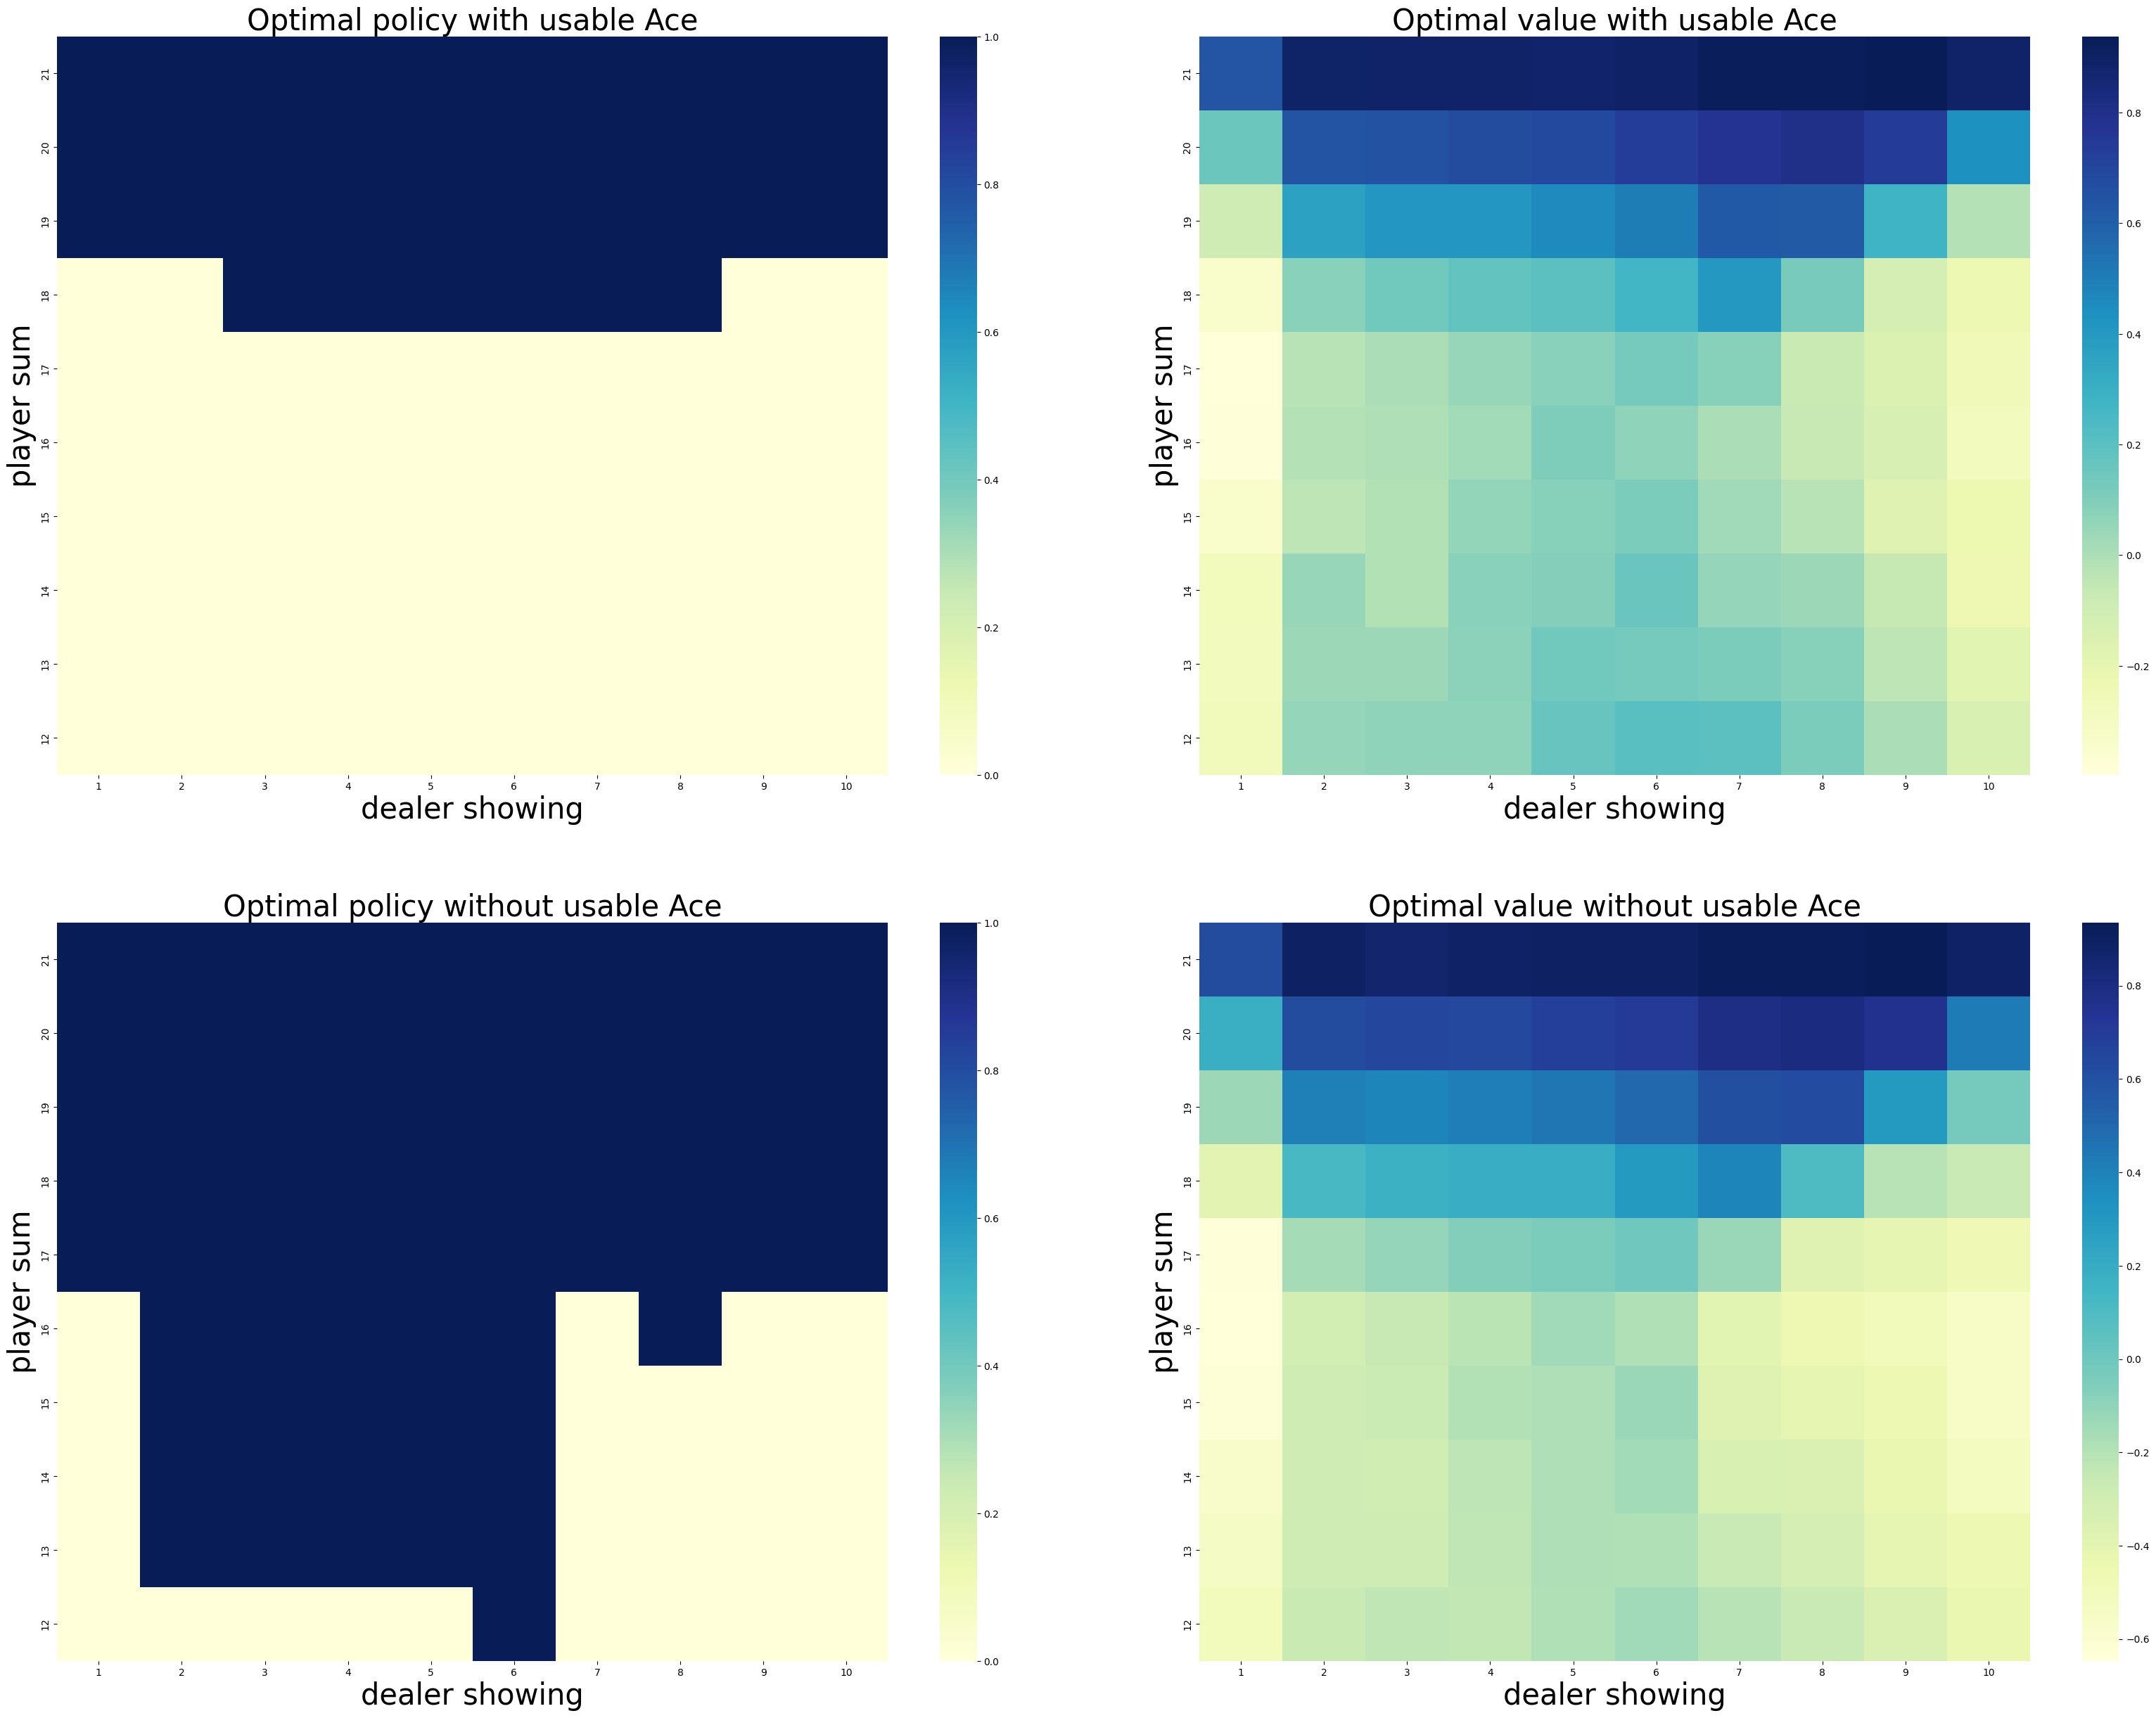

See Fig 5.3? y/nn


In [ ]:
import time
if __name__ == '__main__':
    if input("See Fig 5.1? y/n") not in ['n','N']:
        figure_5_1()
    time.sleep(2)
    if input("See Fig 5.2? y/n") not in ['n','N']:
        figure_5_2()
    time.sleep(2)
    if input("See Fig 5.3? y/n") not in ['n','N']:
        figure_5_3()

## 1a
SARSA

In [ ]:
def sarsa(episodes,alpha=0.05,epsilon=0.05,ckpts=[],use_decay_factor=True):
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # behavior policy is epsilon greedy, and is also the target policy in sarsa
    def behavior_policy(player_sum, dealer_card,usable_ace, epsilon=.05):
        usable_ace = int(usable_ace)
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        values_ = state_action_values[player_sum-12, dealer_card-1, usable_ace, :]
        if np.random.random() < epsilon:
          return np.random.choice([action_ for action_, value_ in enumerate(values_)])
        else:
          return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    progress_bar = tqdm(range(episodes))
    reward = -2 # Not a real reward
    episode_rewards=[]
    ckpt_state_action_values = []
    alpha_decay_factor = 2**(np.log2(.001)/(episodes/1000)) # Mult alpha by this every 1000 episodes, reaches .001 of original value by end
    for episode in progress_bar:
      if episode in ckpts:
        ckpt_state_action_values.append(state_action_values)
      if episode != 0:
        episode_rewards.append(reward)
      if episode%1000 == 0 and episode > 0:
        progress_bar.set_description(f"Avg reward so far = {np.mean(episode_rewards):.4f}")
        if use_decay_factor:
          alpha *= alpha_decay_factor
      # for each episode, use a randomly initialized state and action
      initial_state = [np.random.choice(range(12,22)),
                      np.random.choice(range(1, 11)),
                      np.random.choice(range(0, 2))]
      current_policy = behavior_policy #if episode else target_policy_player
      initial_action = current_policy(initial_state[0],initial_state[1],initial_state[2])

      player_sum, dealer_card1, usable_ace_player = initial_state
      dealer_card2 = get_card()

      # initial state of the game
      state = [player_sum-12, dealer_card1-1, usable_ace_player]

      # initialize dealer's sum
      dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
      usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
      # if the dealer's sum is larger than 21, he must hold two aces.
      if dealer_sum > 21:
          assert dealer_sum == 22
          # use one Ace as 1 rather than 11
          dealer_sum -= 10
      assert dealer_sum <= 21
      assert player_sum <= 21

      # game starts!
      player_bust = False

      # player's turn
      while True:
          if initial_action is not None:
              action = initial_action
              initial_action = None

          # # track player's trajectory for importance sampling
          # player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

          assert state[0] in range(10), f"state[0]={state[0]}"
          assert state[1] in range(10), f"state[1]={state[1]}"
          assert state[2] in range(2), f"state[2]={state[2]}"

          curr_q = state_action_values[state[0],state[1],state[2], action]

          if action == ACTION_STAND:
              break
          # if hit, get new card
          card = get_card()
          # Keep track of the ace count. the usable_ace_player flag is insufficient alone as it cannot
          # distinguish between having one ace or two.
          ace_count = int(usable_ace_player)
          if card == 1:
              ace_count += 1
          player_sum += card_value(card)
          # If the player has a usable ace, use it as 1 to avoid busting and continue.
          while player_sum > 21 and ace_count:
              player_sum -= 10
              ace_count -= 1
          usable_ace_player = (ace_count == 1)

          # player busts
          if player_sum > 21:
              player_bust = True
              reward = -1
              break
          assert player_sum <= 21
          assert player_sum >= 12
          next_state = [player_sum-12, dealer_card1-1, (int)(usable_ace_player)]
          next_action = current_policy(player_sum, dealer_card1, usable_ace_player)
          next_q = state_action_values[next_state[0],next_state[1],next_state[2], next_action]
          # print(f"state_action_values[state[0],state[1],state[2], action] = {state_action_values[state[0],state[1],state[2], action]}")
          # print(f"alpha={alpha}")
          # print(f"next_q={next_q}")
          # print(f"next_state[0],next_state[1],next_state[2], next_action={next_state[0],next_state[1],next_state[2], next_action}")
          # print(f"state_action_values[next_state[0],next_state[1],next_state[2], next_action] = {state_action_values[next_state[0],next_state[1],next_state[2], next_action]}")
          # print(f"state_action_values[next_state[0],next_state[1],0, next_action] = {state_action_values[next_state[0],next_state[1],0, next_action]}")
          # print(f"state_action_values[0,0,0,0]={state_action_values[0,0,0,0]}")
          # print(f"curr_q={curr_q}")
          
          state_action_values[state[0],state[1],state[2], action] += alpha*(next_q-curr_q)
          
          state = next_state
          action = next_action
        # state_action_pair_count[state[1], state[2], state[0], action] += 1

      if player_bust:
        state_action_values[state[0],state[1],state[2], action] += alpha*(reward-curr_q)
        continue

      dealer_bust = False
      # dealer's turn
      while True:
          # get action based on current sum
          dealer_action = POLICY_DEALER[dealer_sum]
          if dealer_action == ACTION_STAND:
              break
          # if hit, get a new card
          new_card = get_card()
          ace_count = int(usable_ace_dealer)
          if new_card == 1:
              ace_count += 1
          dealer_sum += card_value(new_card)
          # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
          while dealer_sum > 21 and ace_count:
              dealer_sum -= 10
              ace_count -= 1
          # dealer busts
          if dealer_sum > 21:
              dealer_bust = True
              reward = 1
              break
              # return state, 1, player_trajectory
          usable_ace_dealer = (ace_count == 1)
      
      if dealer_bust:
        # print(state[0],state[1],state[2],action)
        state_action_values[state[0],state[1],state[2],action] += alpha*(reward-curr_q)
        continue
      
      # compare the sum between player and dealer
      if dealer_sum > player_sum:
        reward = -1
      if dealer_sum == player_sum:
        reward = 0
      if dealer_sum < player_sum:
        reward = 1

      state_action_values[state[0],state[1],state[2],action] += alpha*(reward-curr_q)
    ckpt_state_action_values.append(state_action_values)
    if len(ckpts) > 0:
      return ckpt_state_action_values
    return state_action_values

In [ ]:
def figure_5_4(episodes=500000,alpha=0.05,epsilon=0.05,ckpts=[],use_decay_factor=True):
    ckpt_state_action_values = sarsa(episodes,alpha,epsilon,ckpts,use_decay_factor)
    if len(ckpts) == 0:
      ckpt_state_action_values = [ckpt_state_action_values]

    for i in range(len(ckpt_state_action_values)):
      print(f"Checkpoint {i+1} of {len(ckpt_state_action_values)}")
      state_action_values = ckpt_state_action_values[i]
      state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
      state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

      # get the optimal policy
      action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
      action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

      images = [action_usable_ace,
                state_value_usable_ace,
                action_no_usable_ace,
                state_value_no_usable_ace]

      titles = ['Optimal policy with usable Ace',
                'Optimal value with usable Ace',
                'Optimal policy without usable Ace',
                'Optimal value without usable Ace']

      _, axes = plt.subplots(2, 2, figsize=(40, 30))
      plt.subplots_adjust(wspace=0.1, hspace=0.2)
      axes = axes.flatten()

      for image, title, axis in zip(images, titles, axes):
          fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                            yticklabels=list(reversed(range(12, 22))))
          fig.set_ylabel('player sum', fontsize=30)
          fig.set_xlabel('dealer showing', fontsize=30)
          fig.set_title(title, fontsize=30)

      #plt.savefig('../images/figure_5_2.png')
      plt.show()
      plt.close()

The policies learned via SARSA in the next cell differ somewhat from the optimal policies above, even after 1.5 mil episodes. They are fairly close within 300000 episodes.

Avg reward in last 1000 = 0.0534: 100%|██████████| 1500000/1500000 [06:55<00:00, 3613.56it/s]


Checkpoint 1 of 8


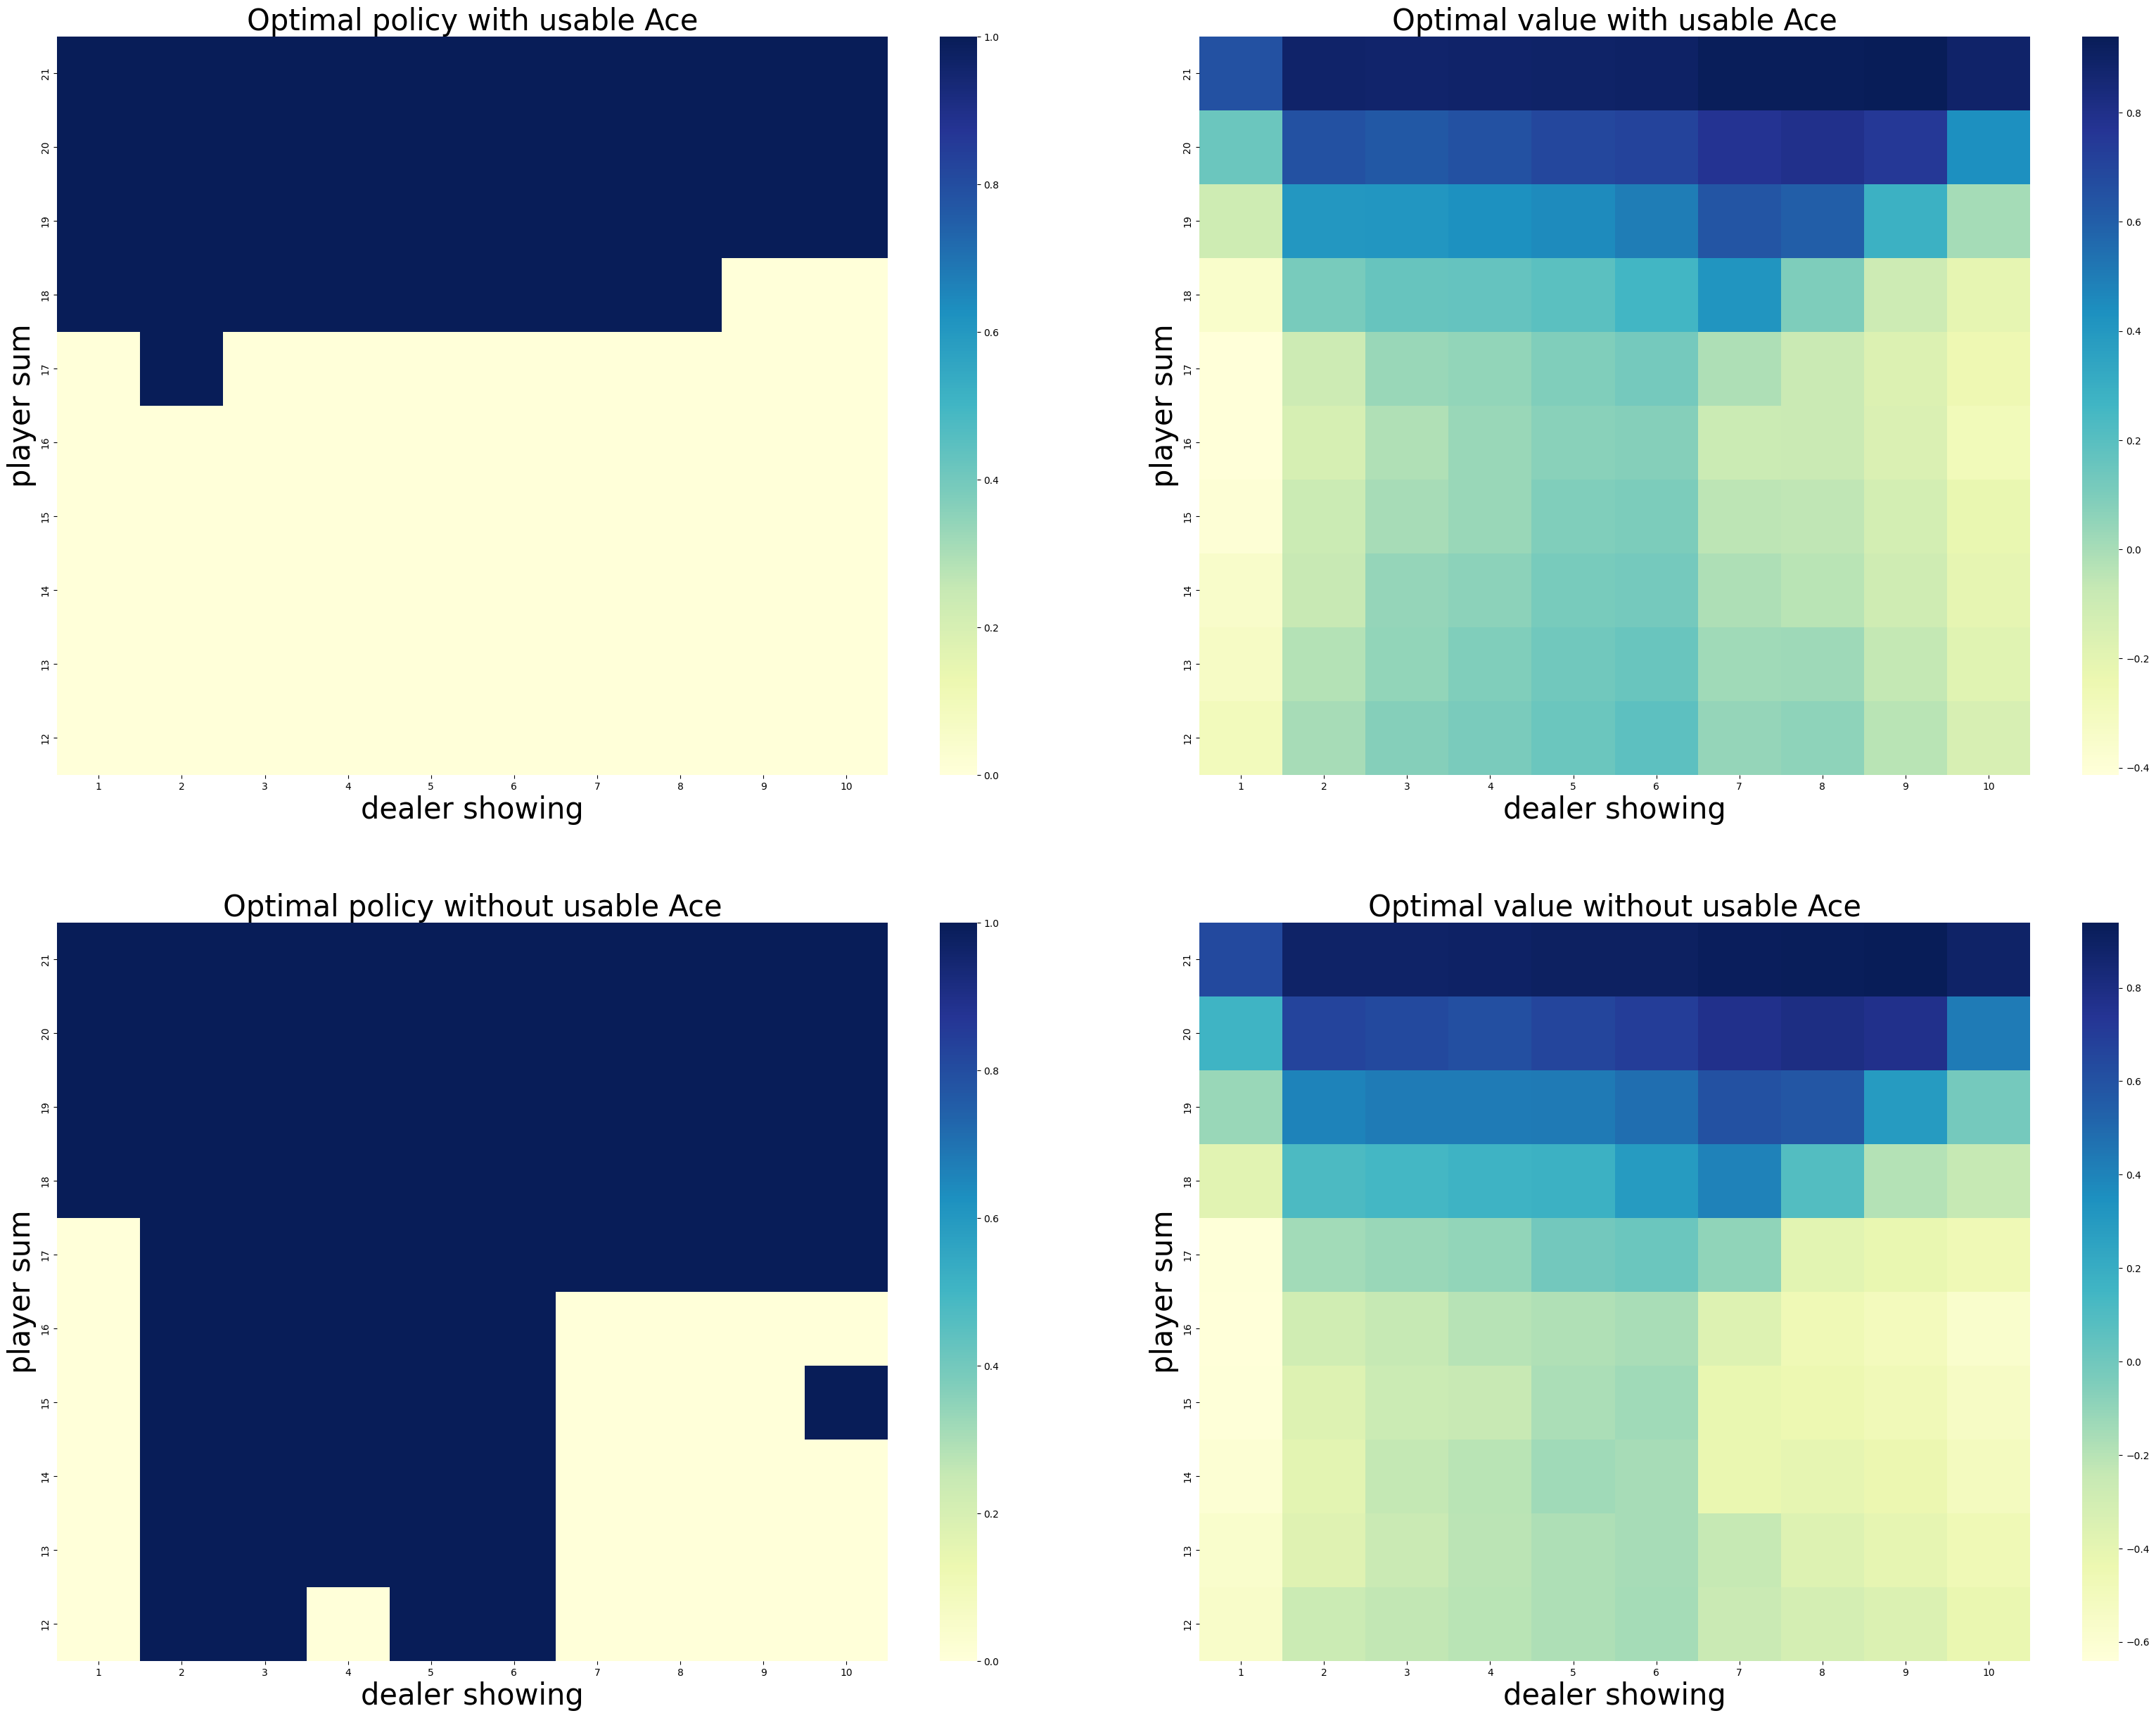

Checkpoint 2 of 8


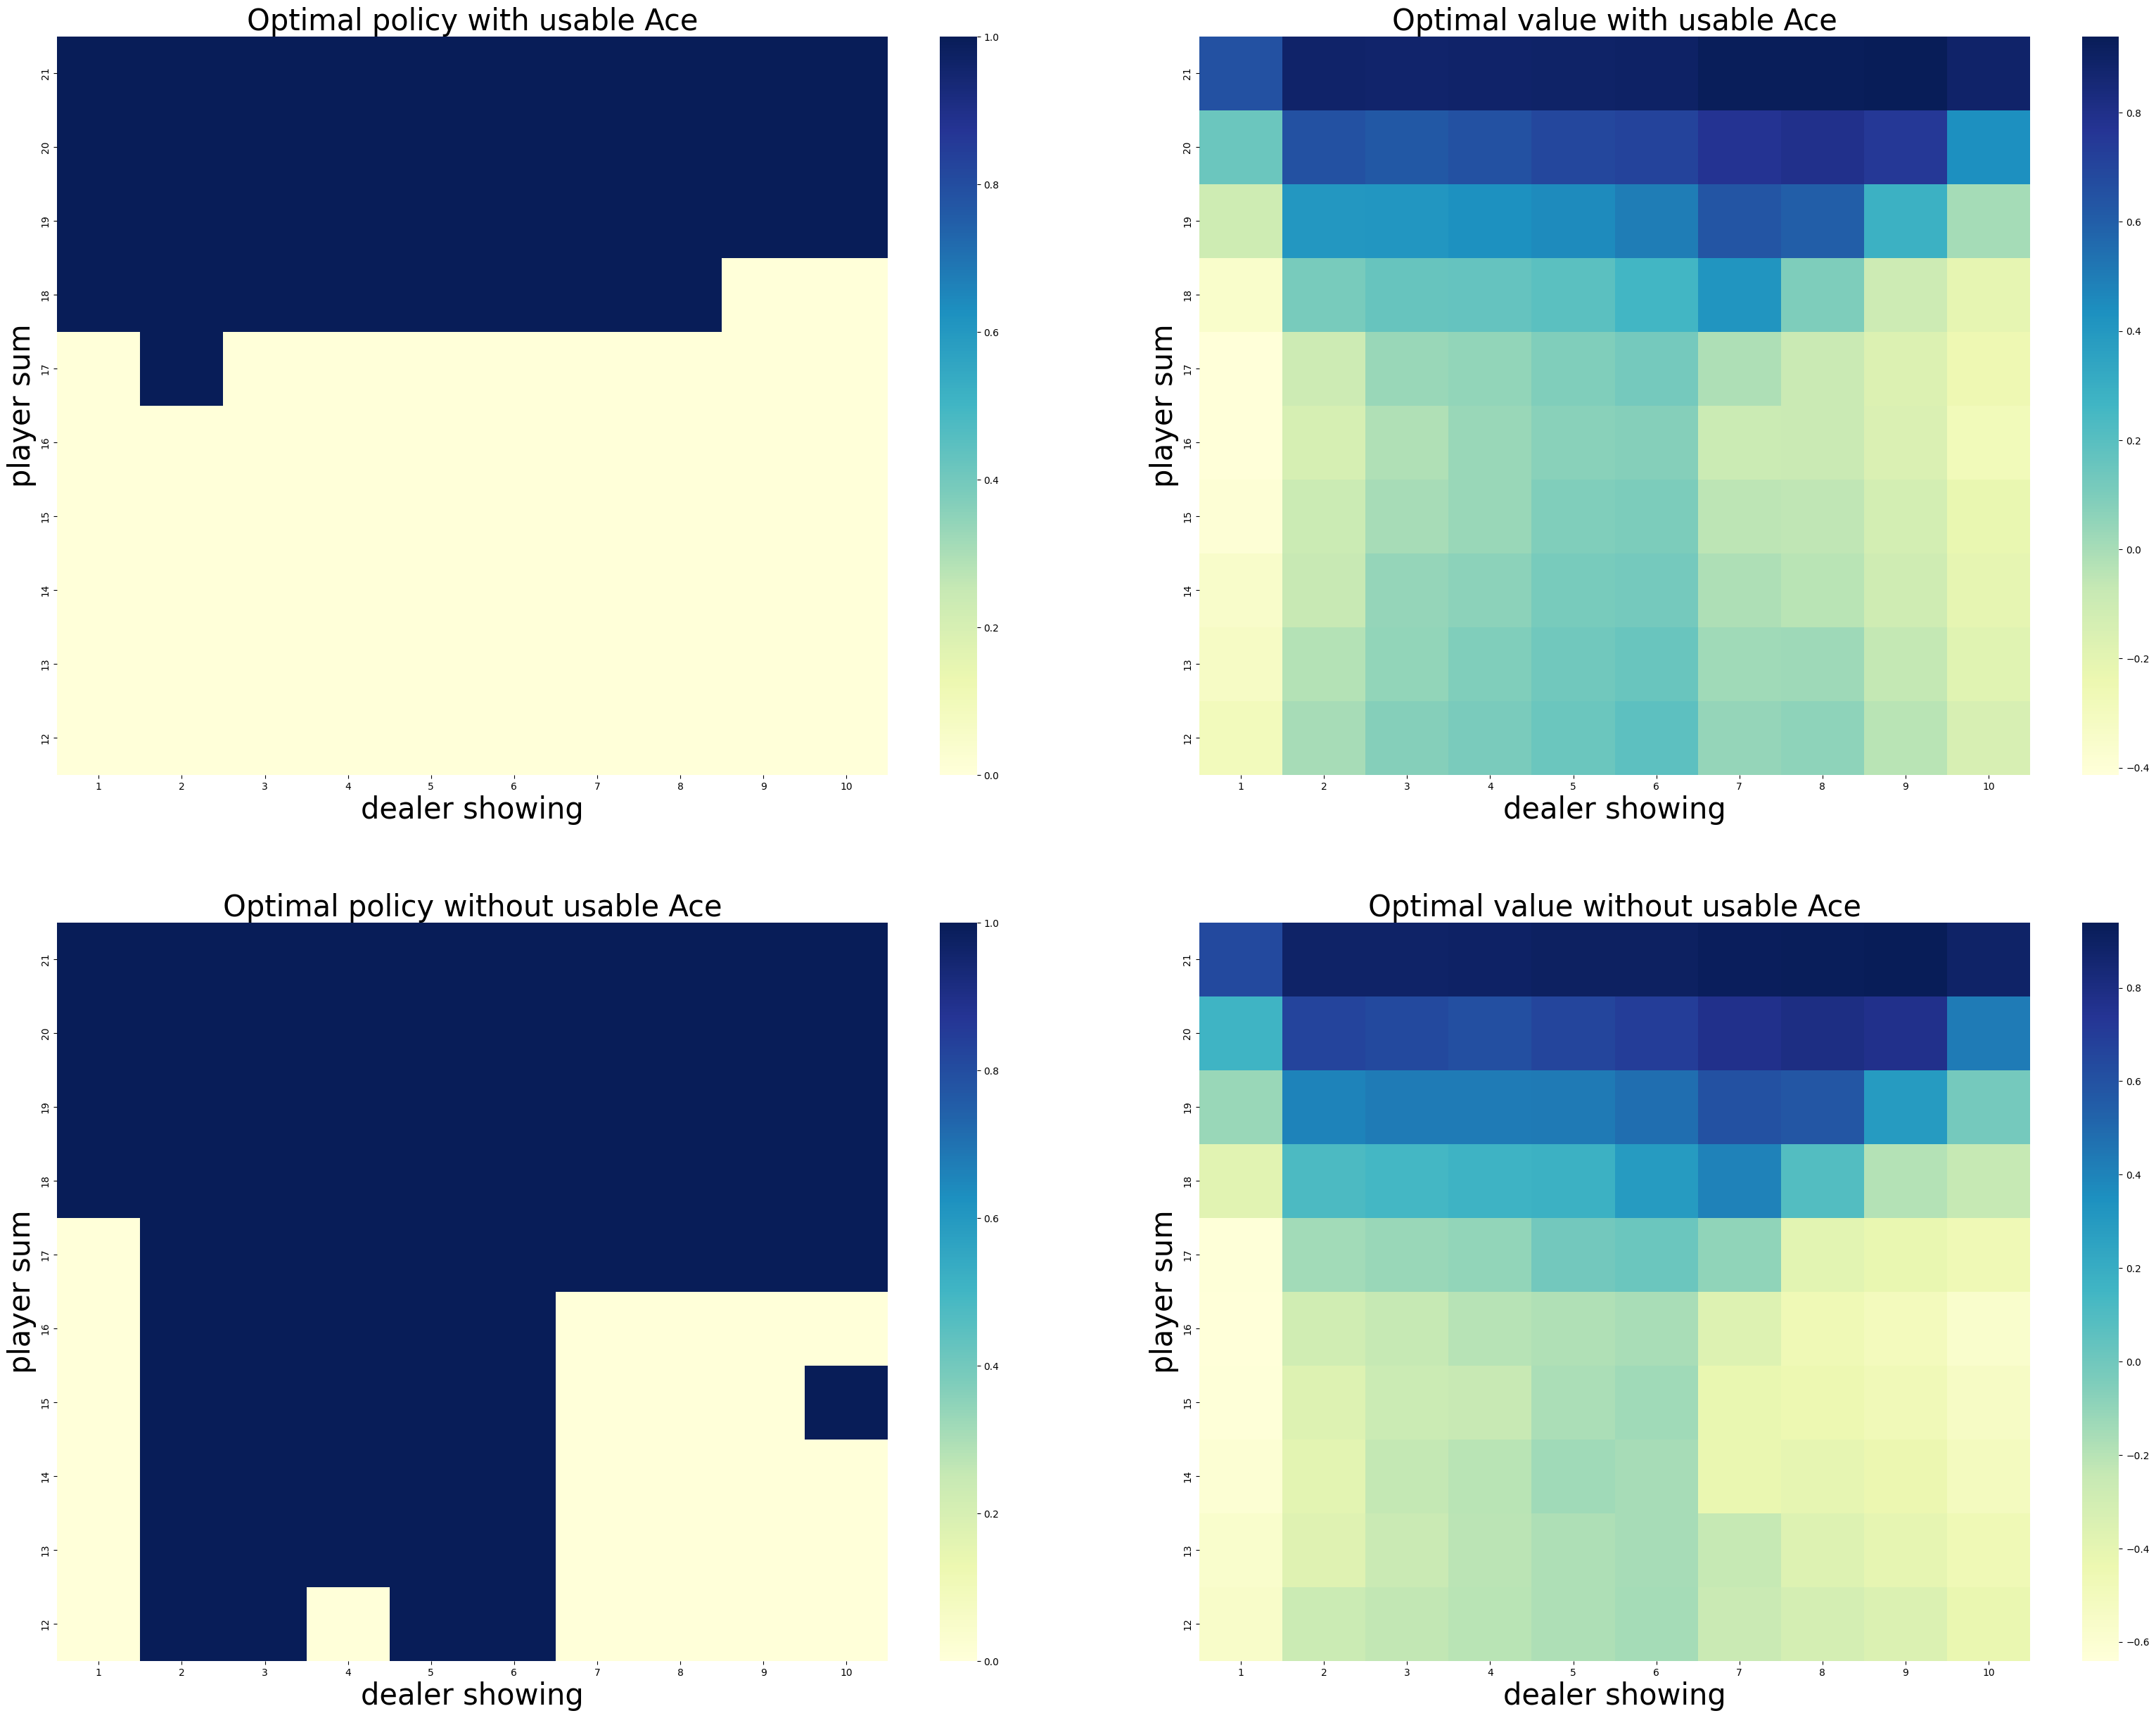

Checkpoint 3 of 8


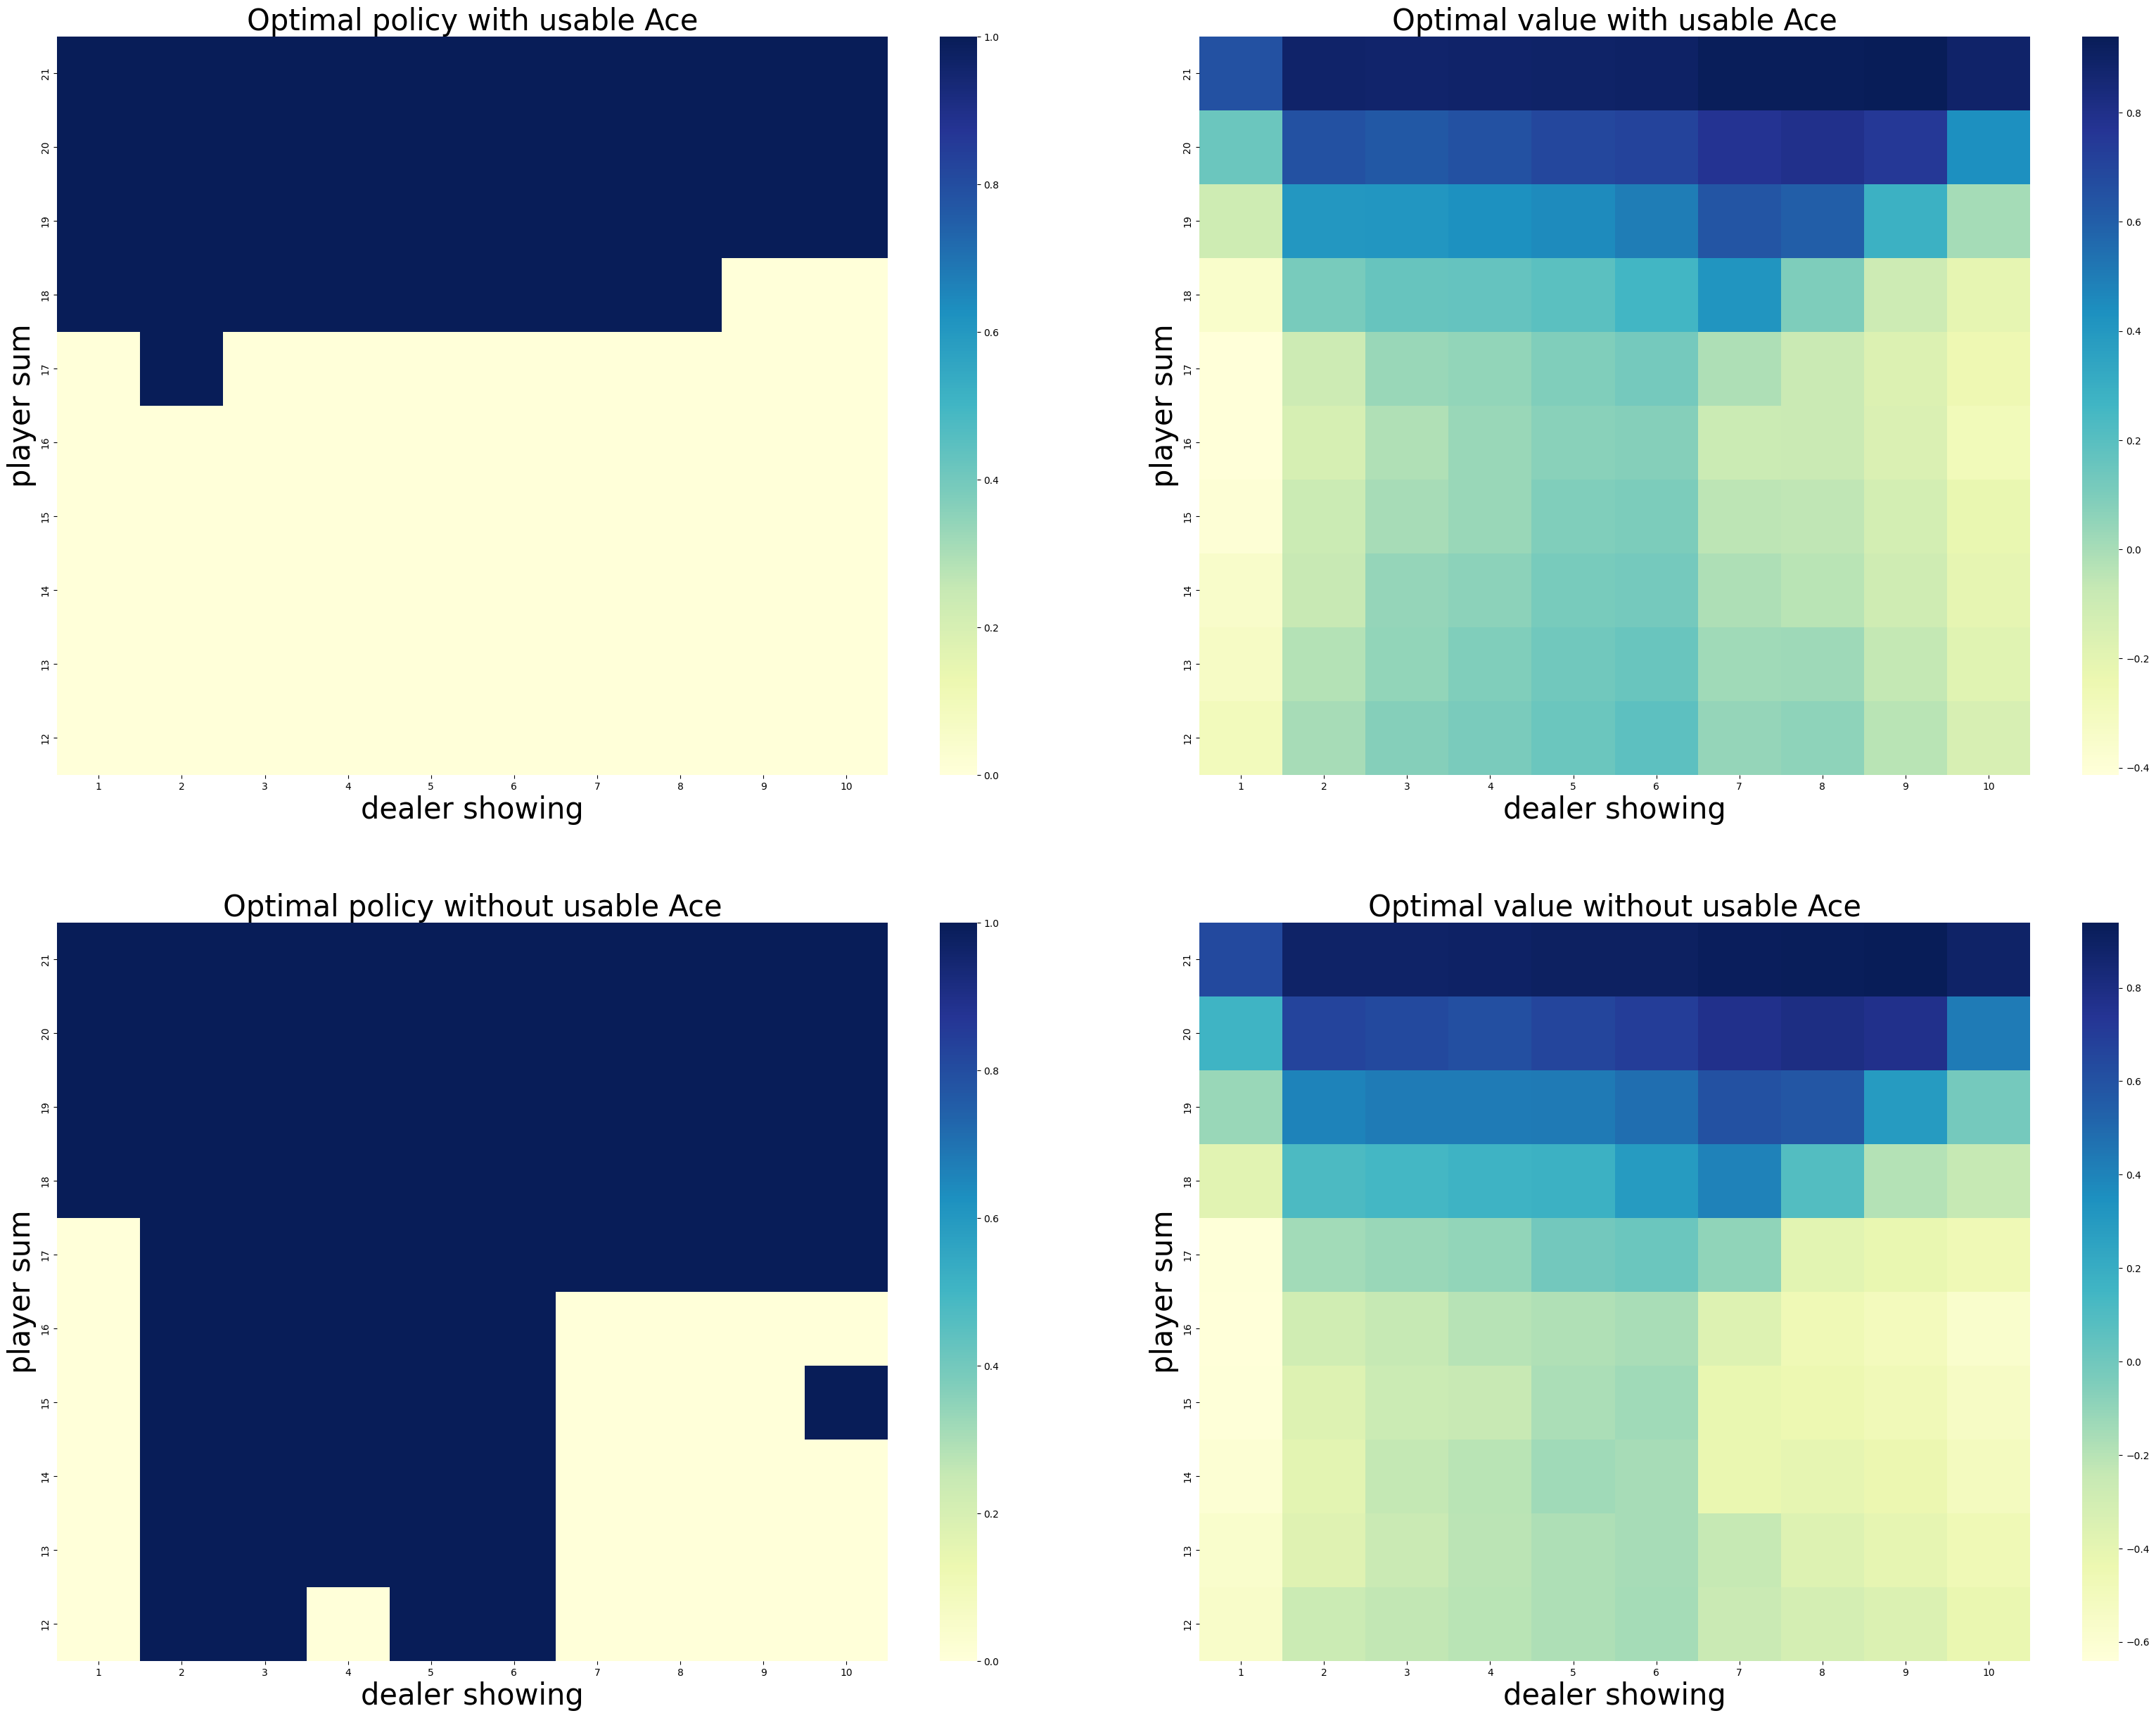

Checkpoint 4 of 8


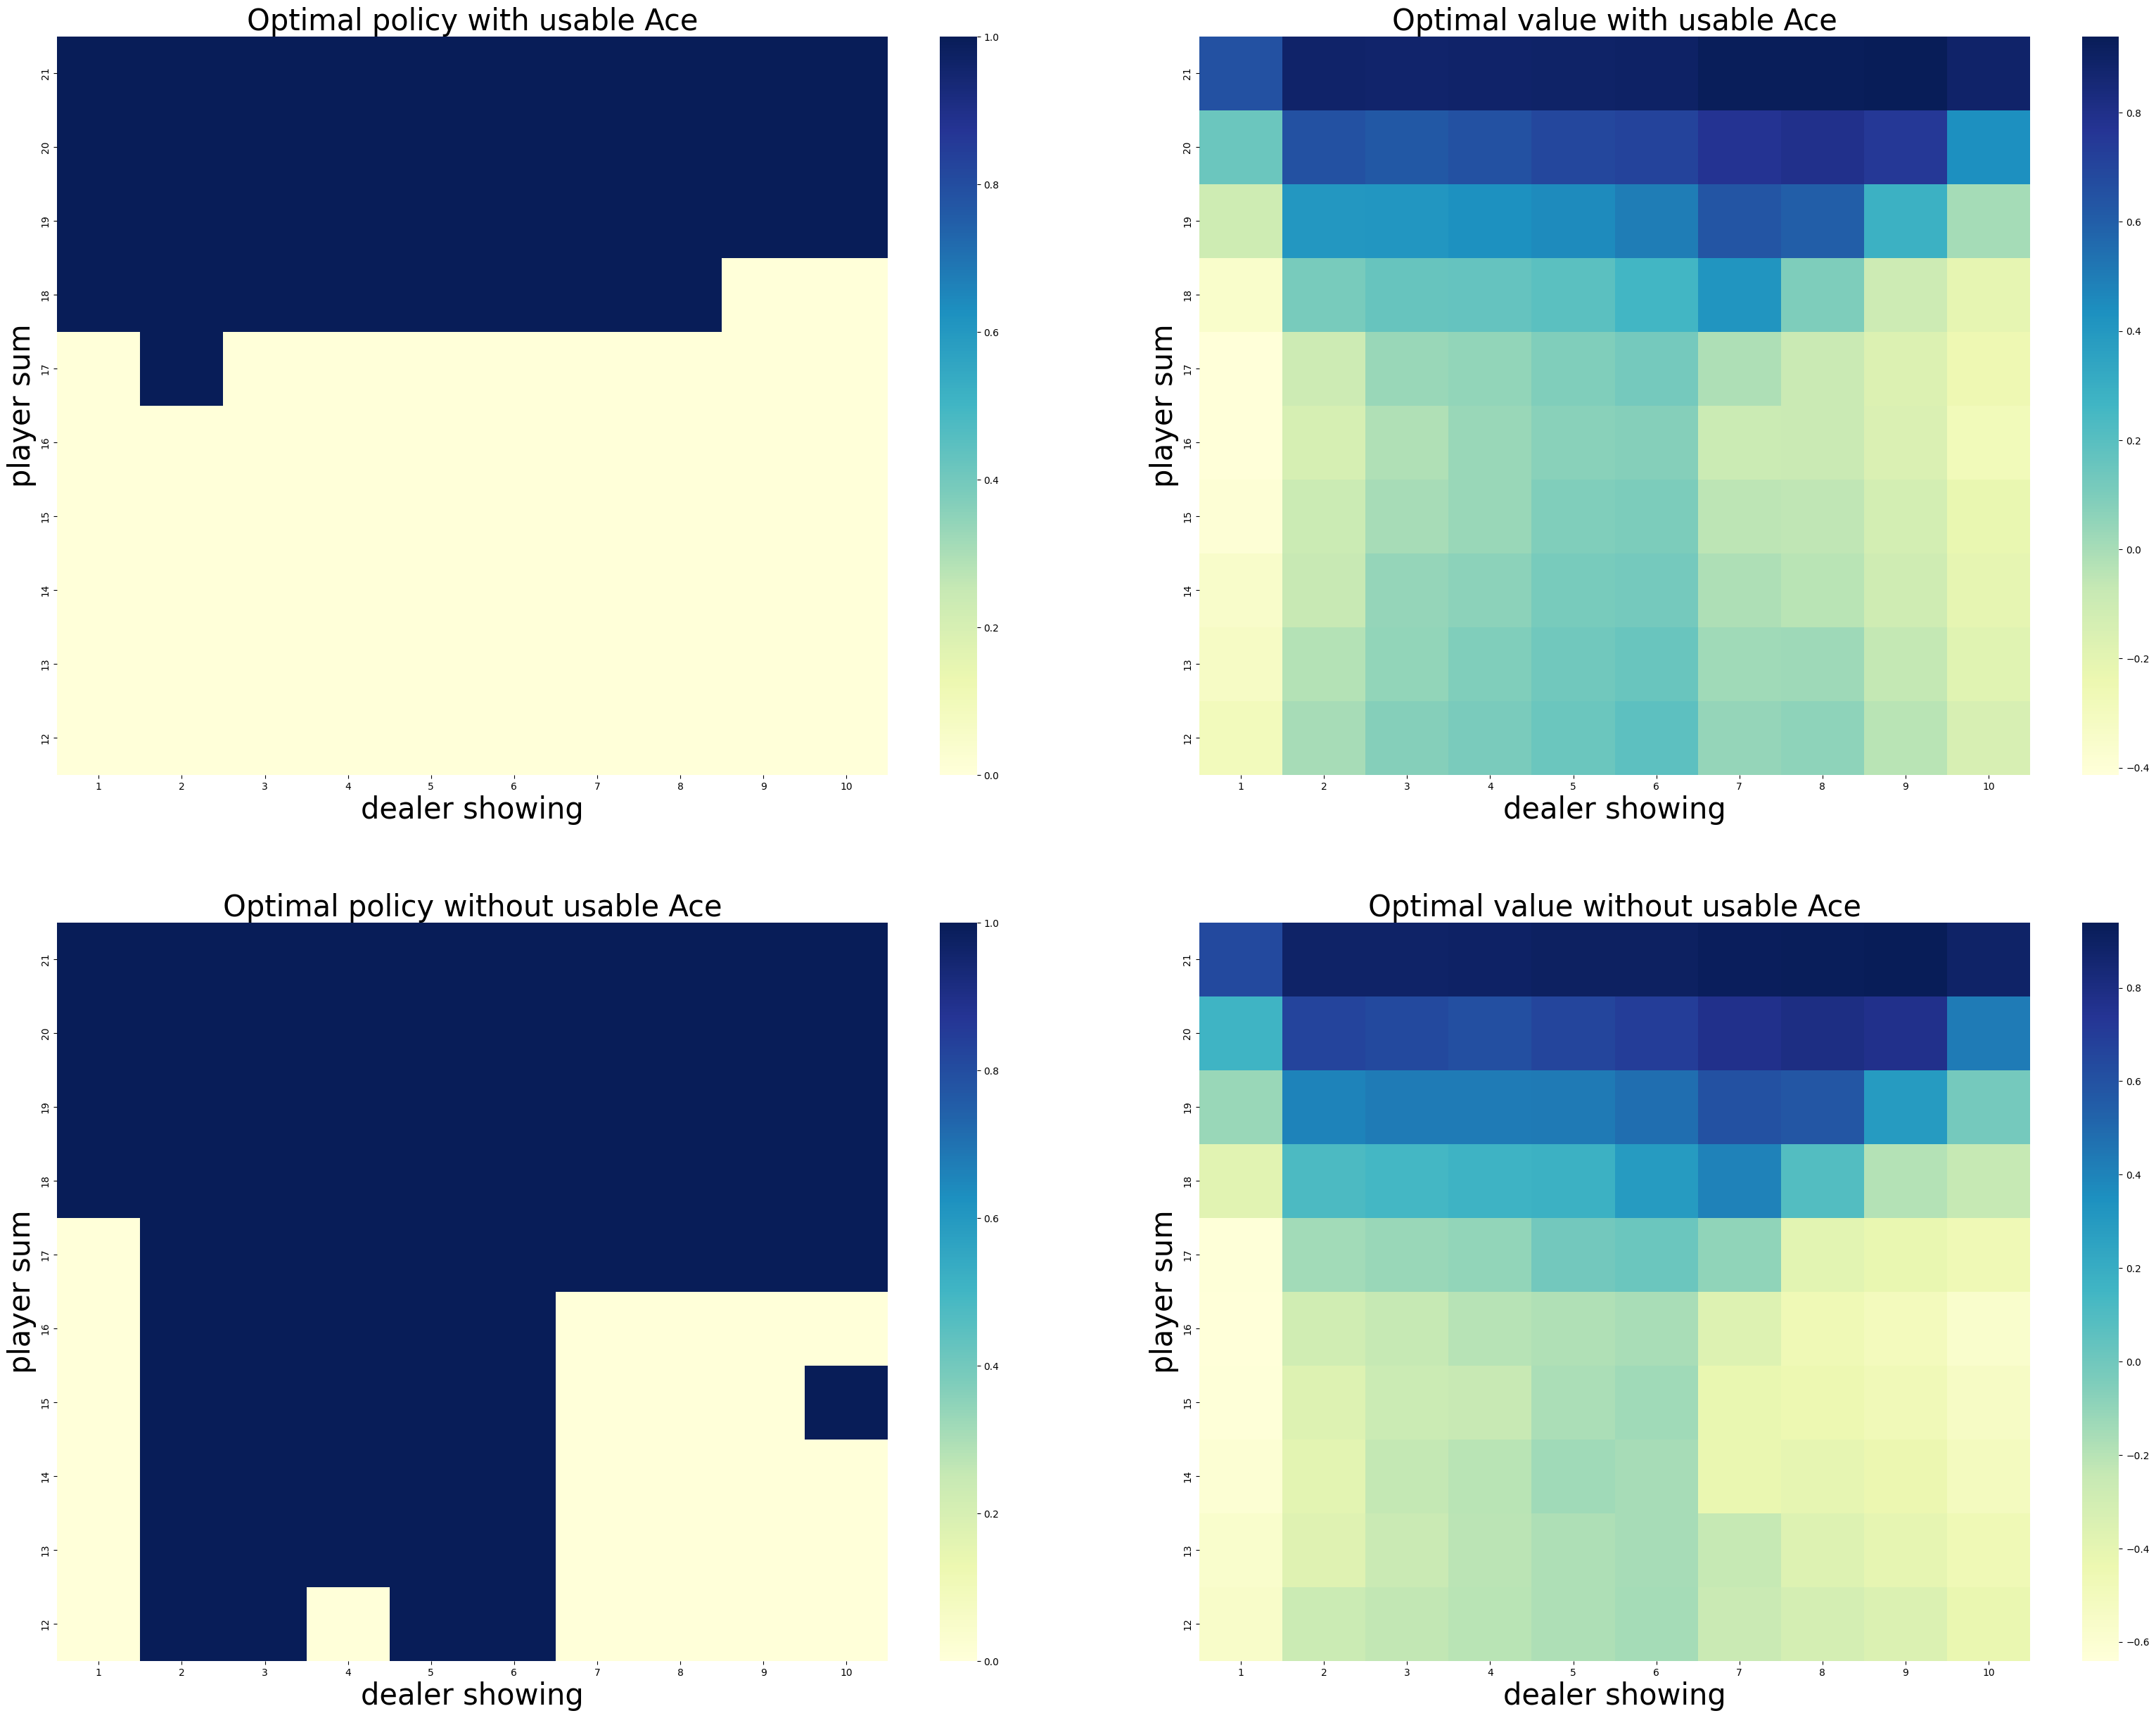

Checkpoint 5 of 8


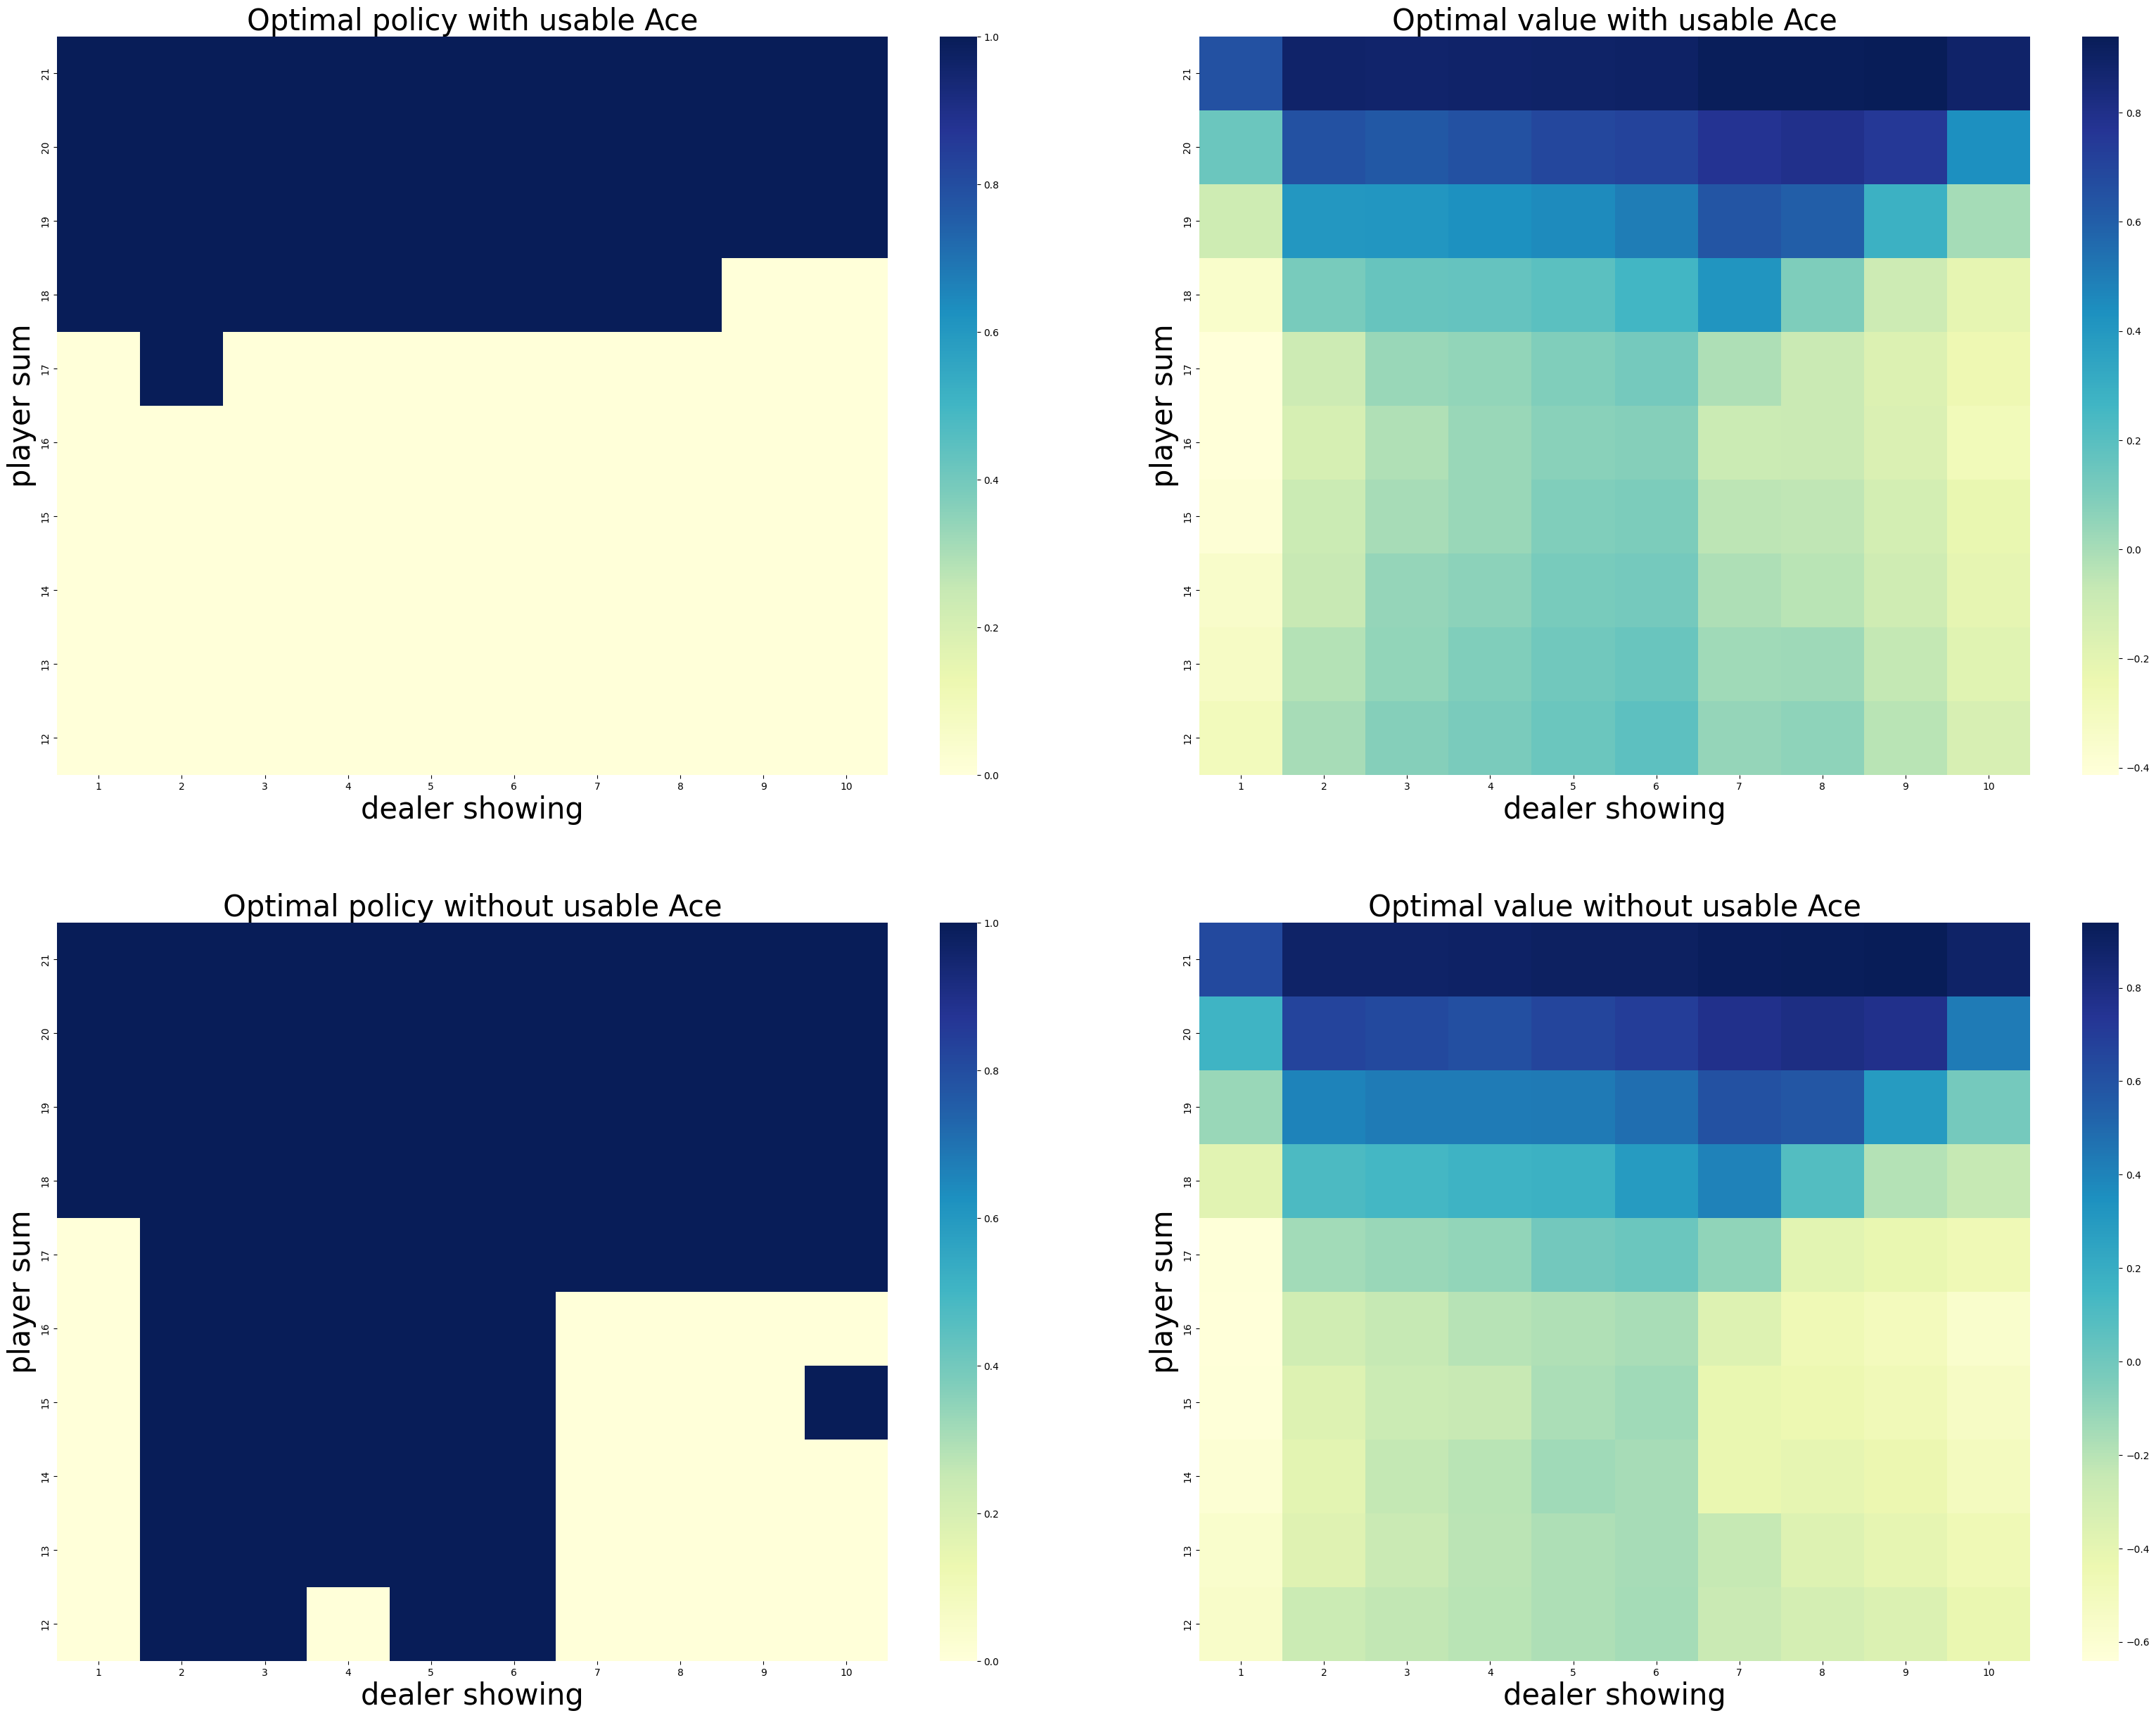

Checkpoint 6 of 8


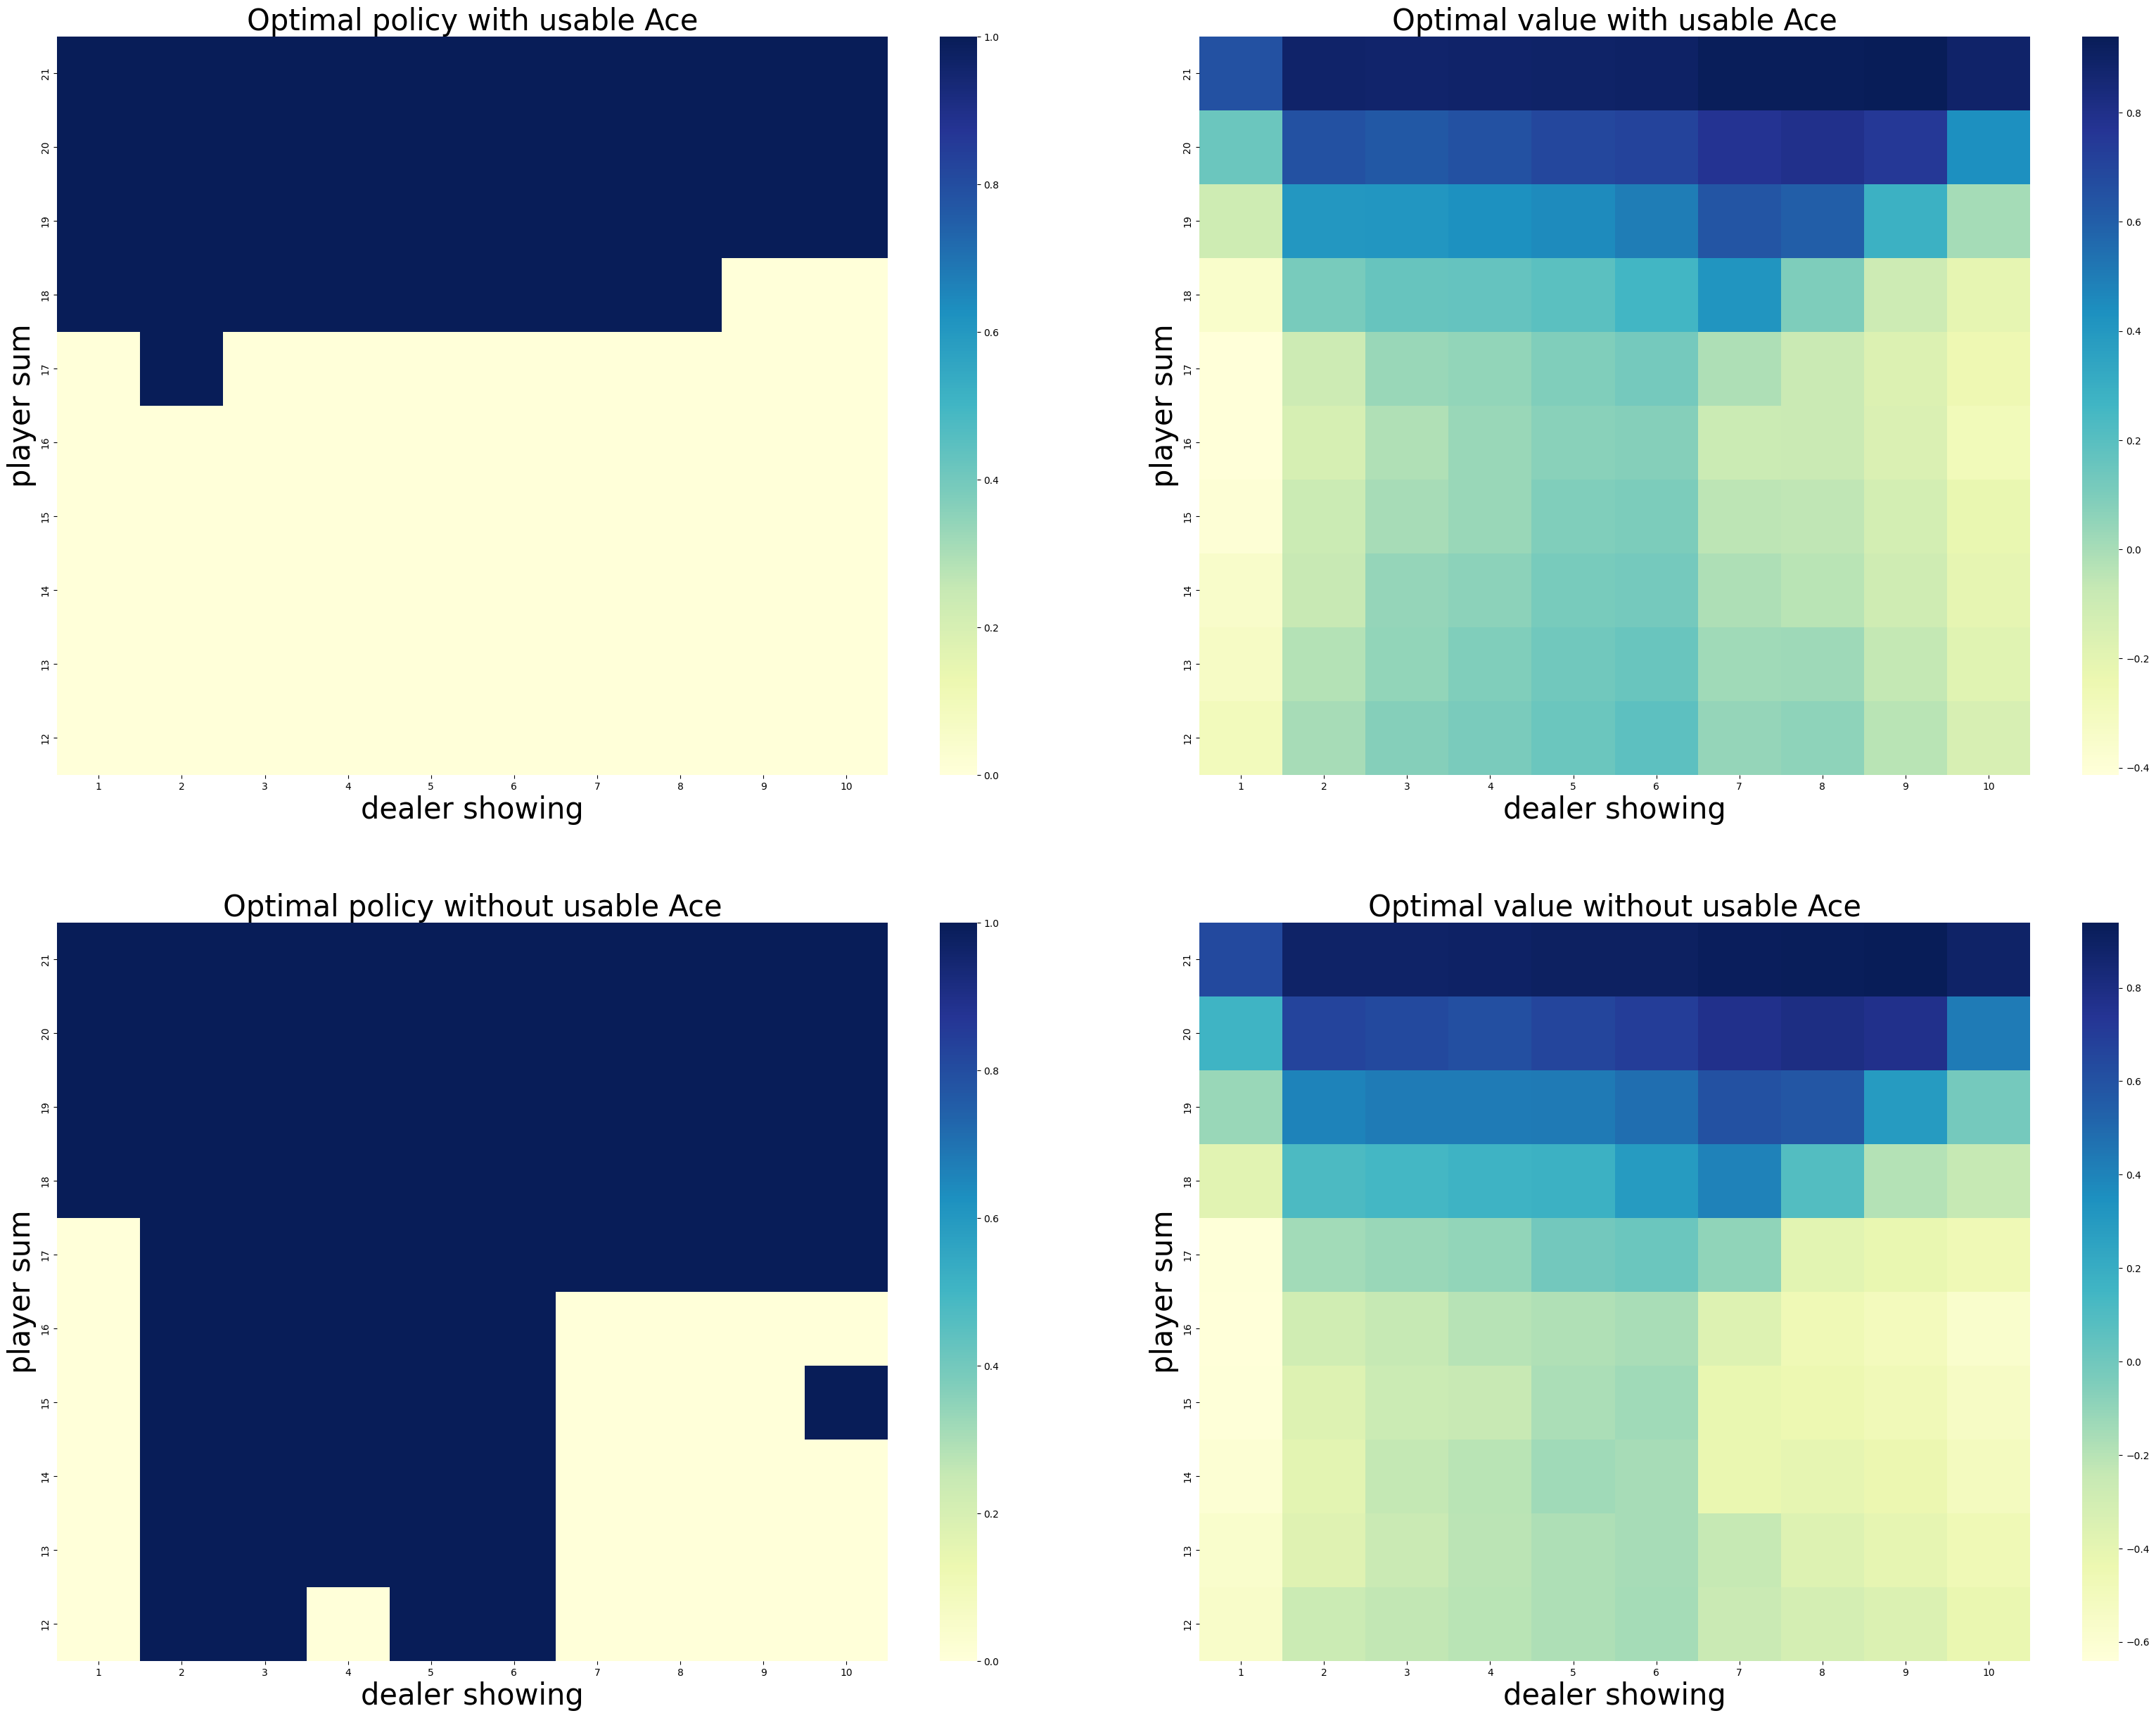

Checkpoint 7 of 8


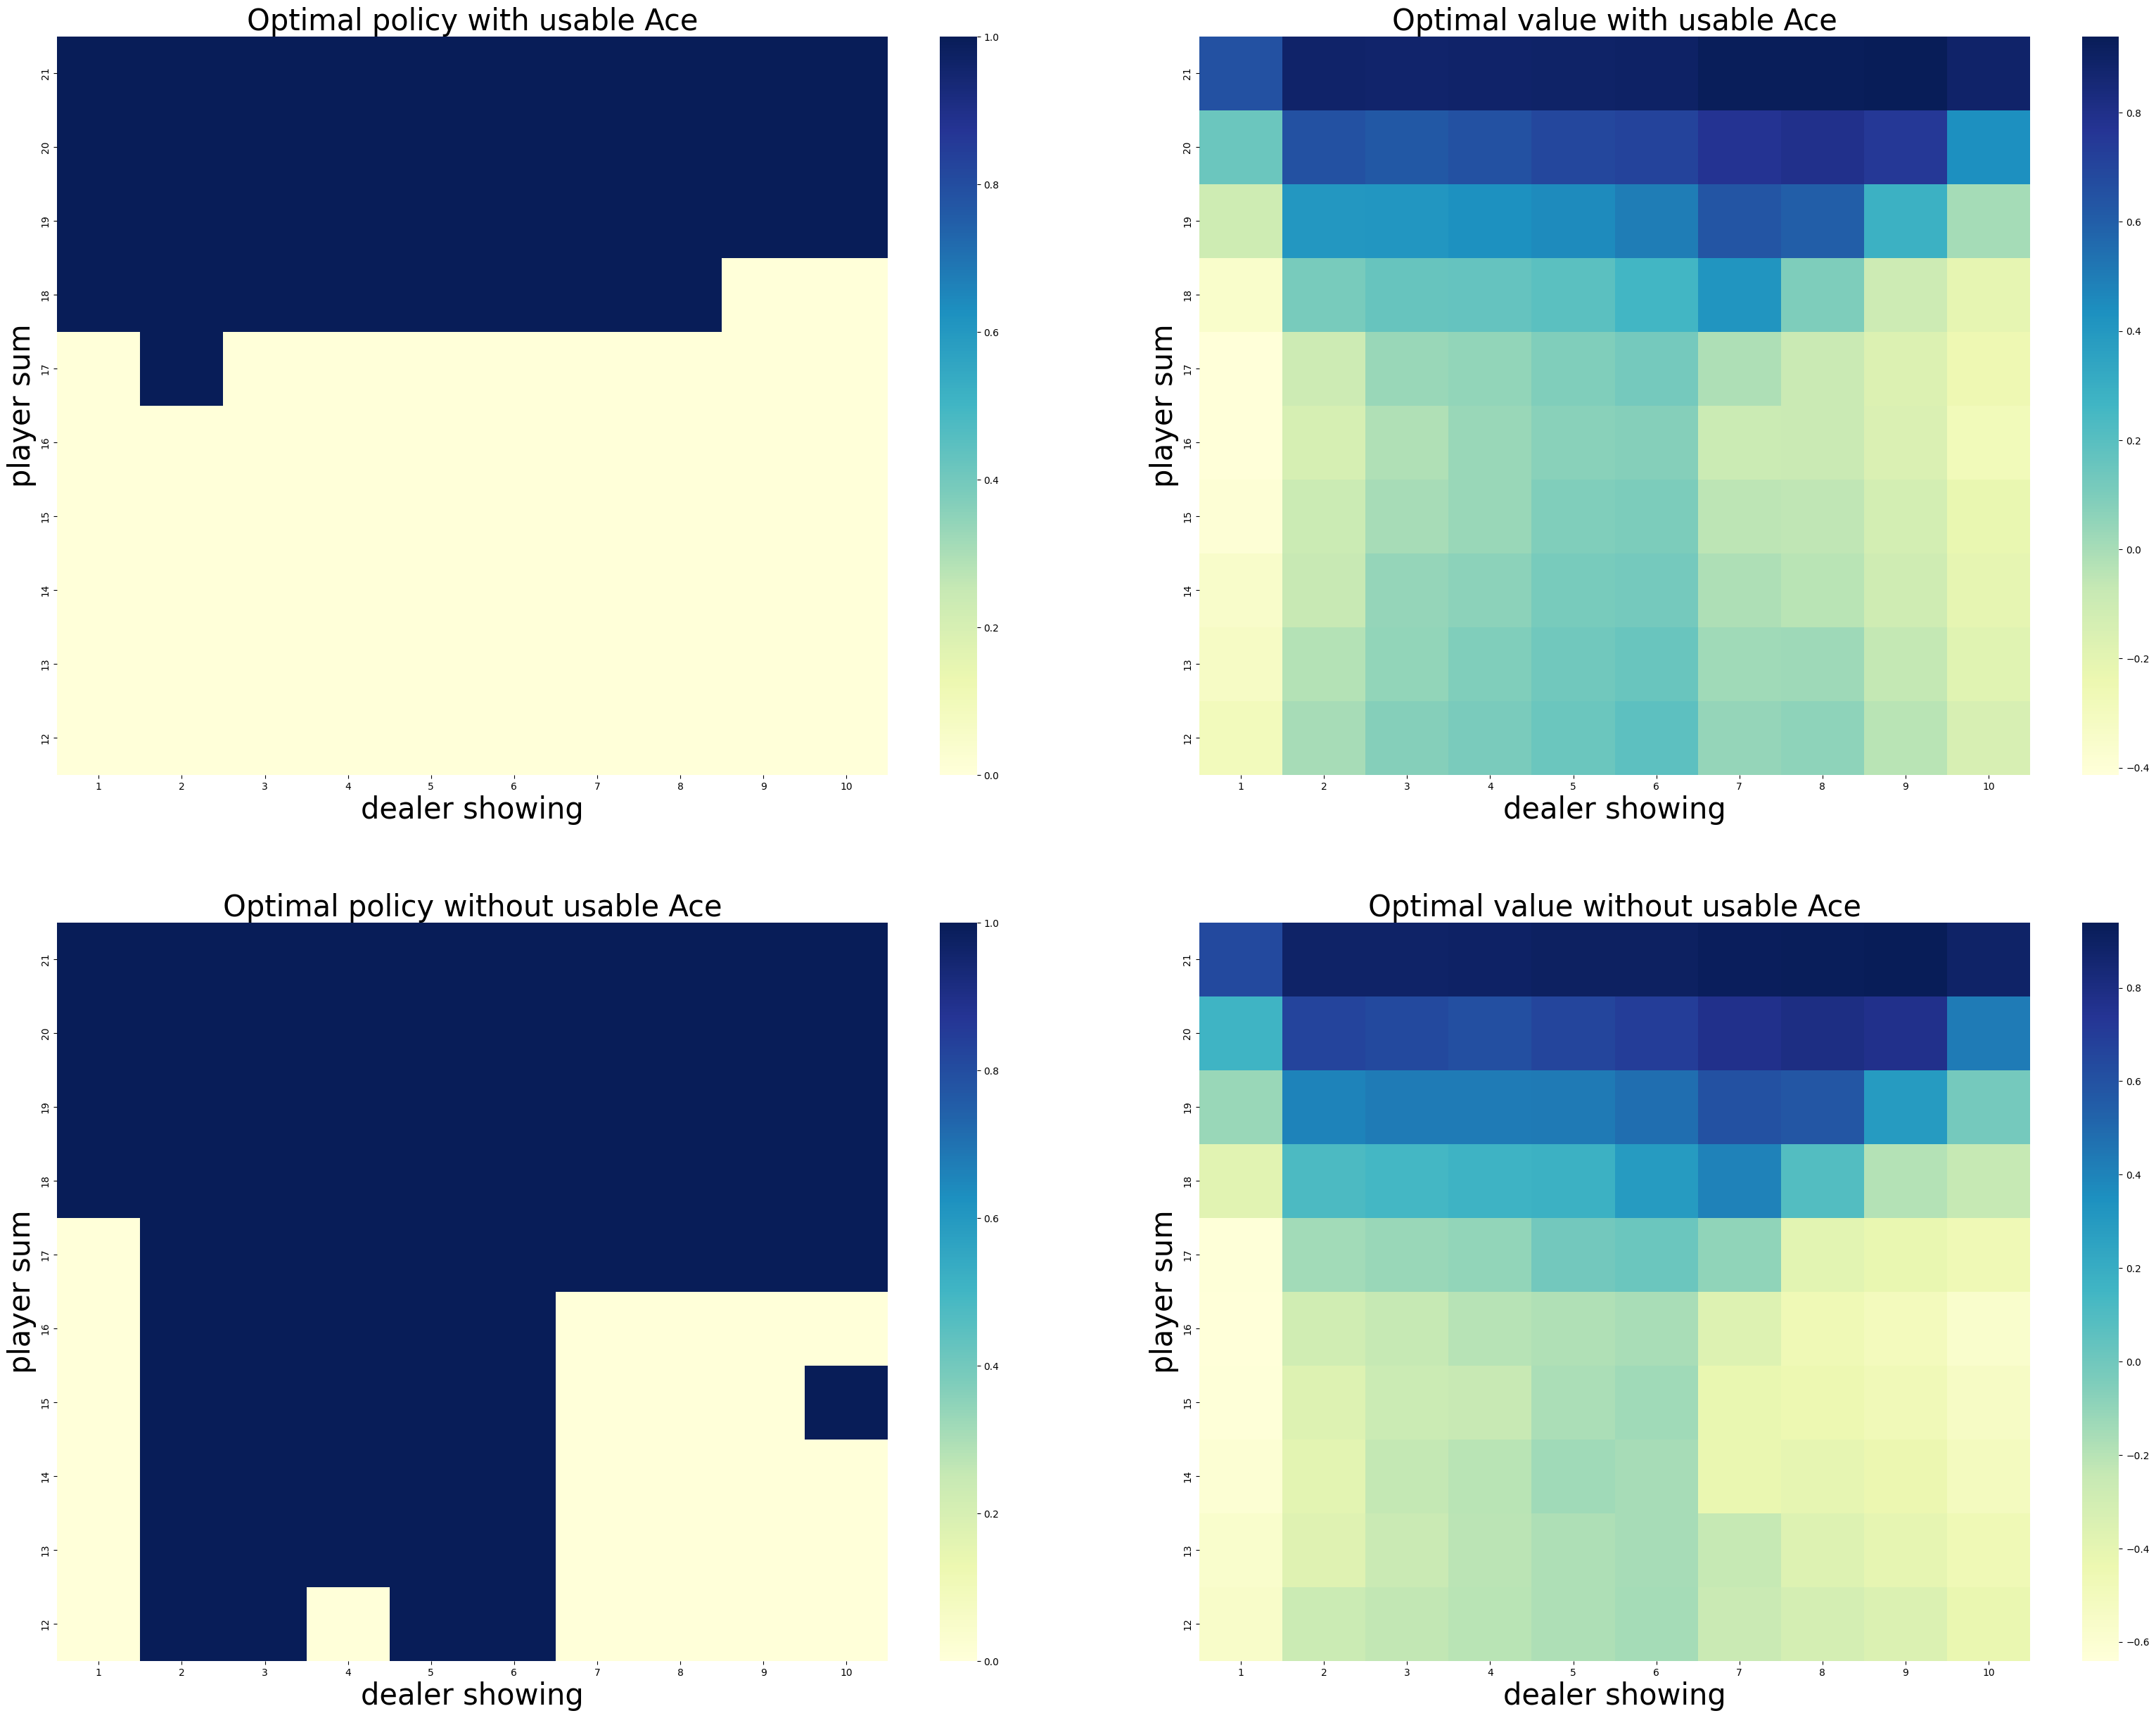

Checkpoint 8 of 8


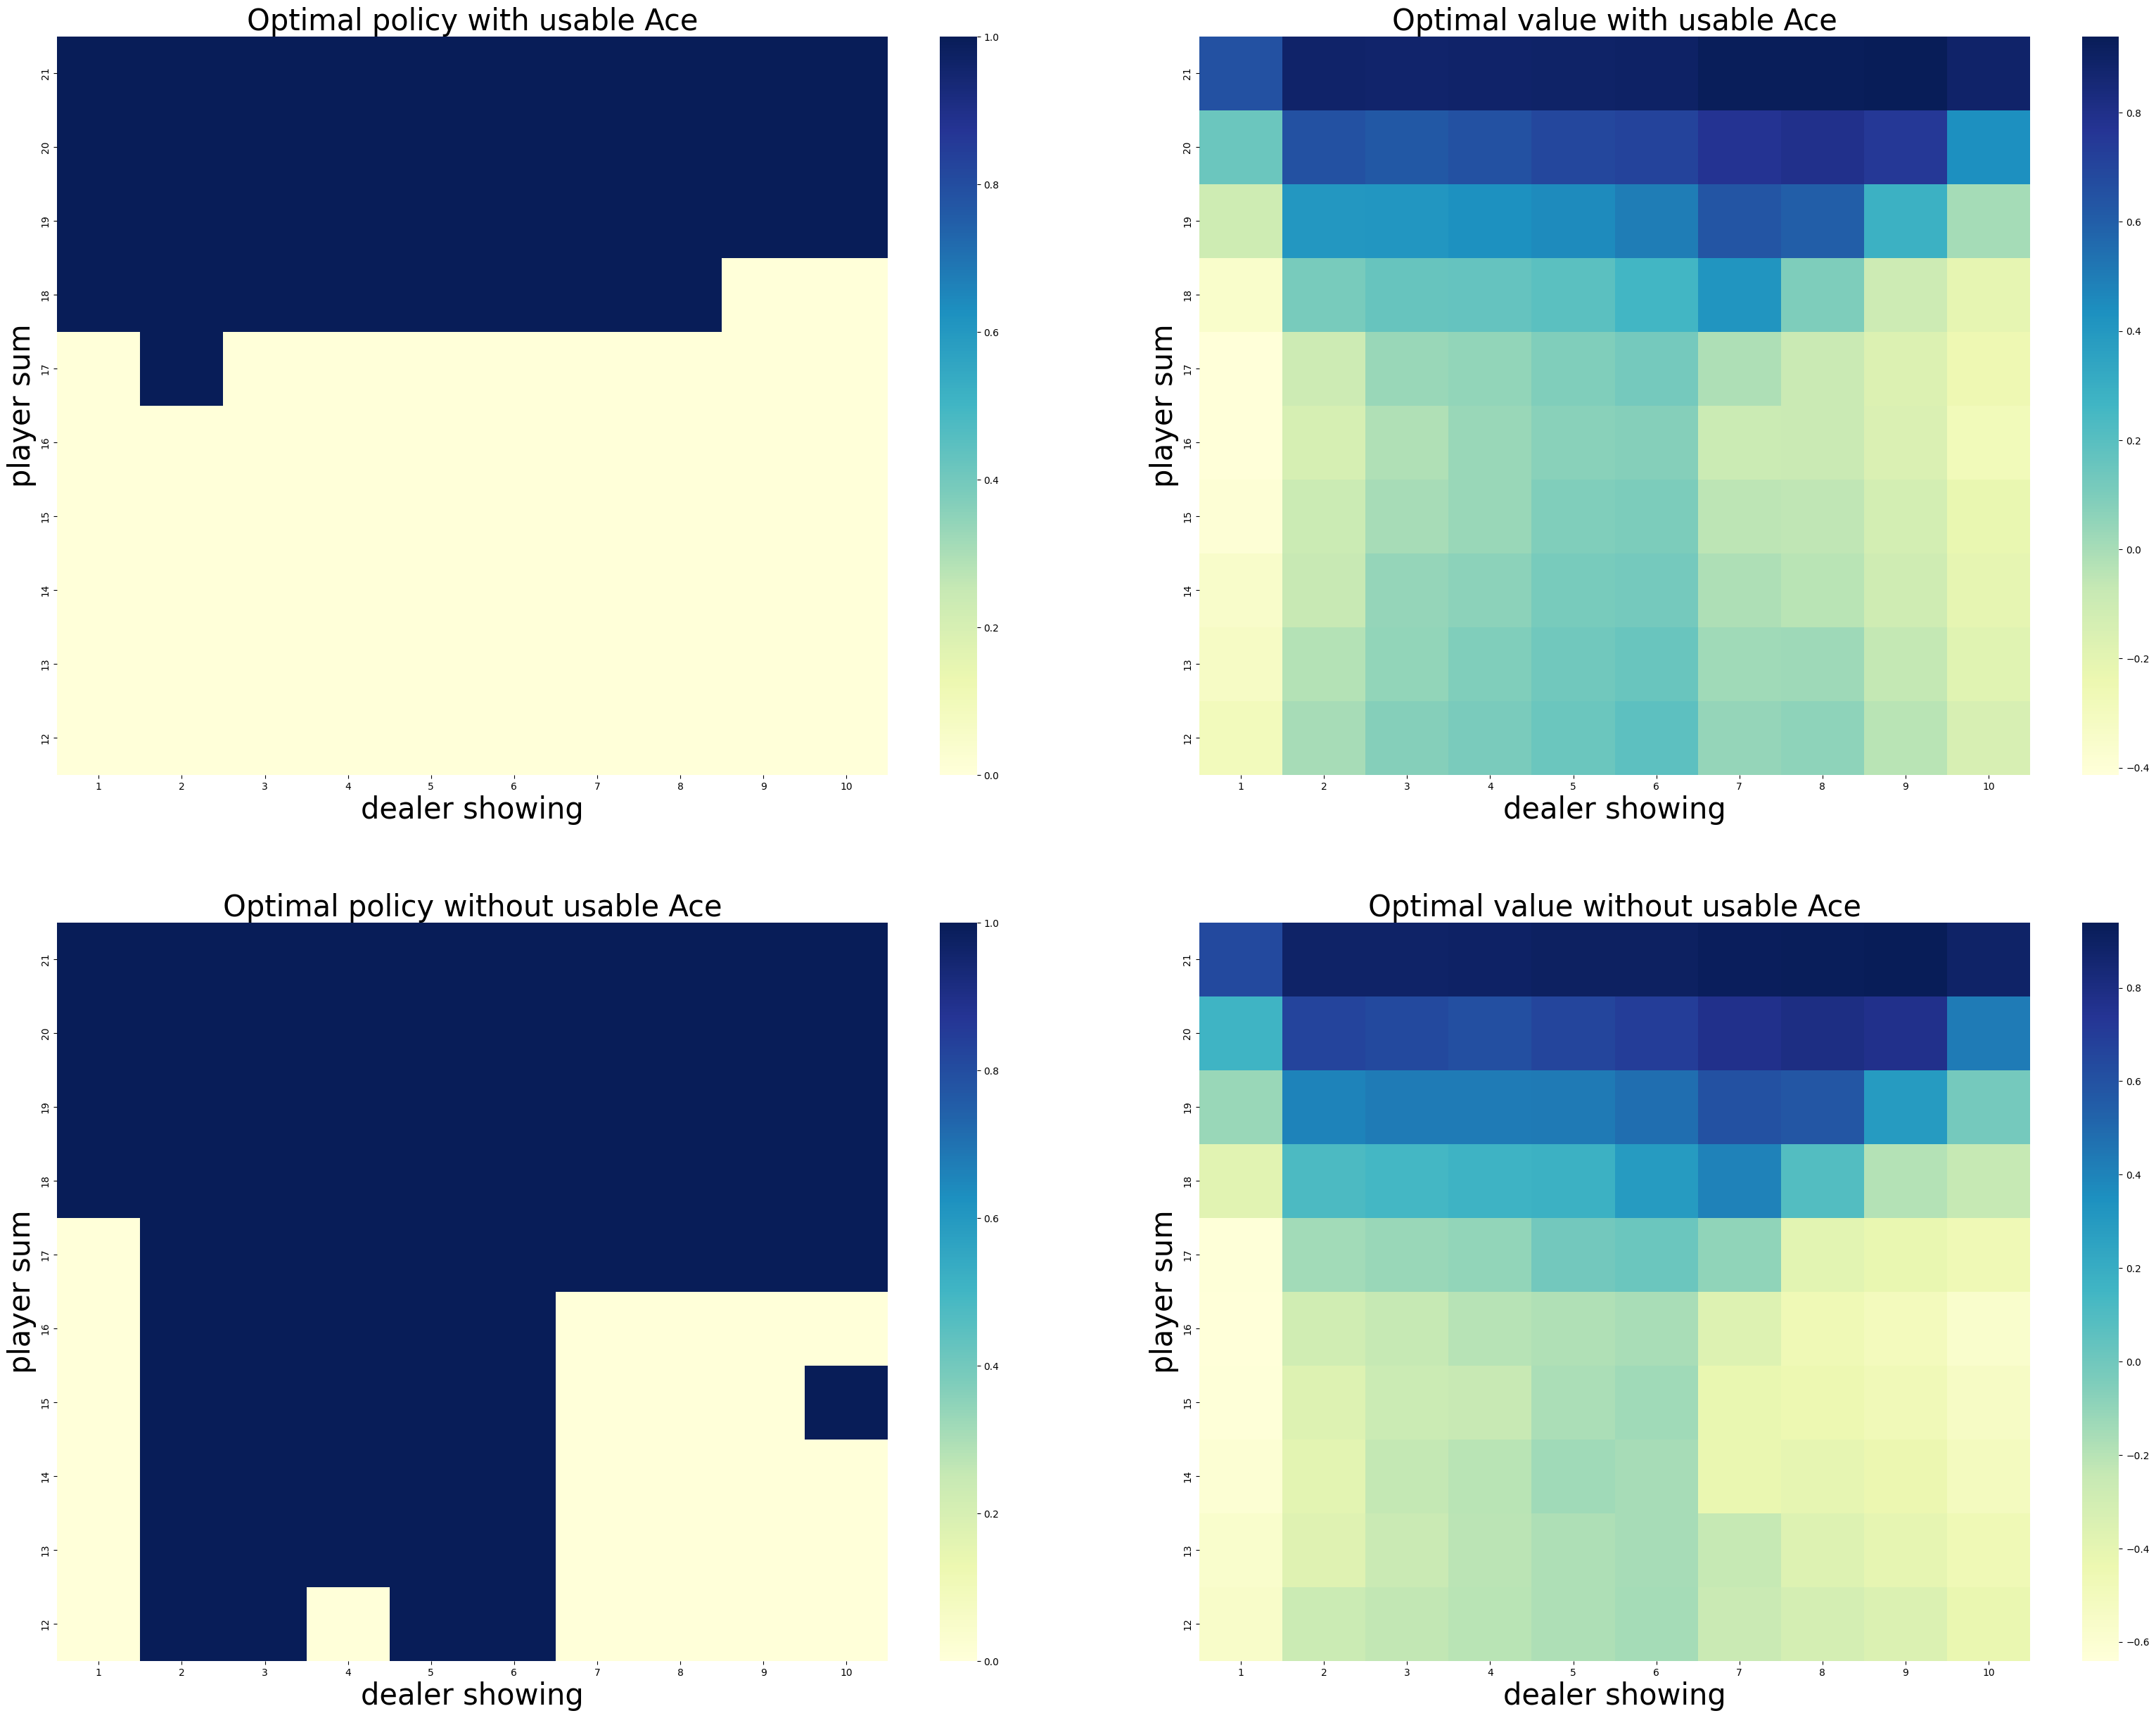

In [ ]:
figure_5_4(episodes=1500000,alpha=0.2,epsilon=0.05,ckpts=[300000,500000,650000,800000,1000000,1200000,1350000])

The policies learned via SARSA in the next cell also differ somewhat from the optimal policies above, but very slightly. They are very close within 1 mil episodes - I think nothing changes in the following 4 mil episodes.

Avg reward in last 1000 = 0.0566: 100%|██████████| 5000000/5000000 [35:57<00:00, 2317.58it/s]


Checkpoint 1 of 9


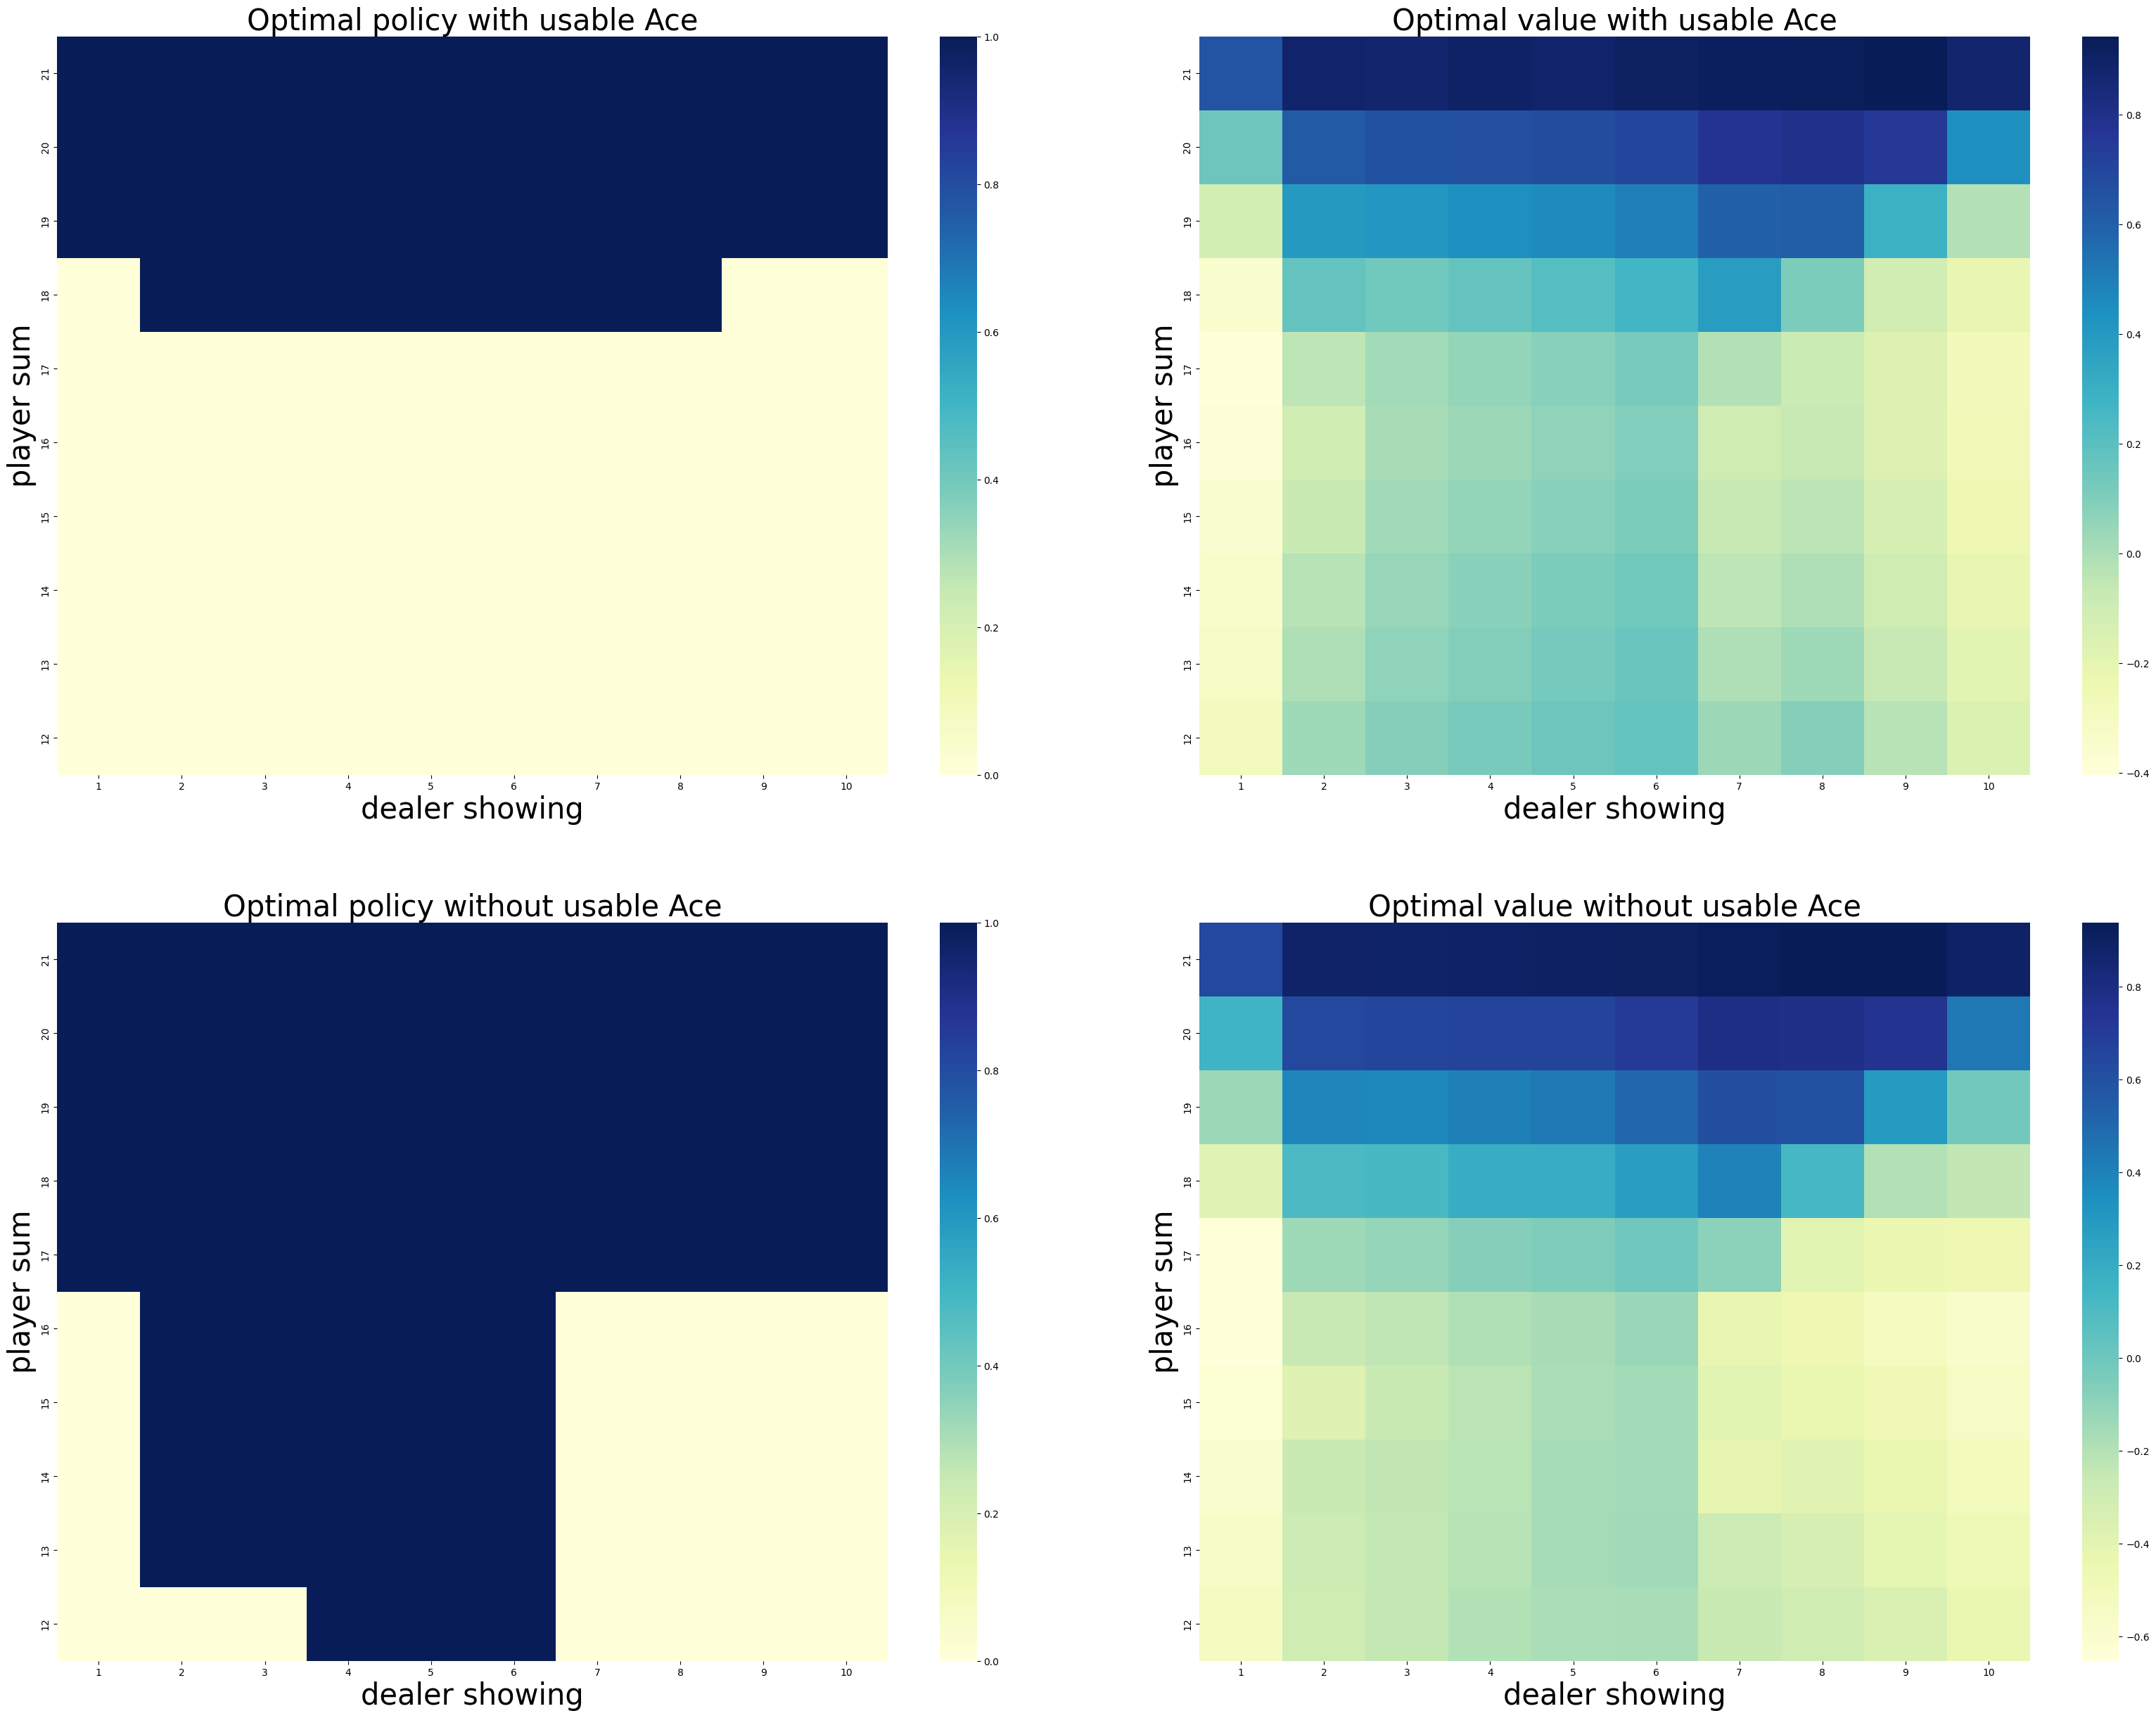

Checkpoint 2 of 9


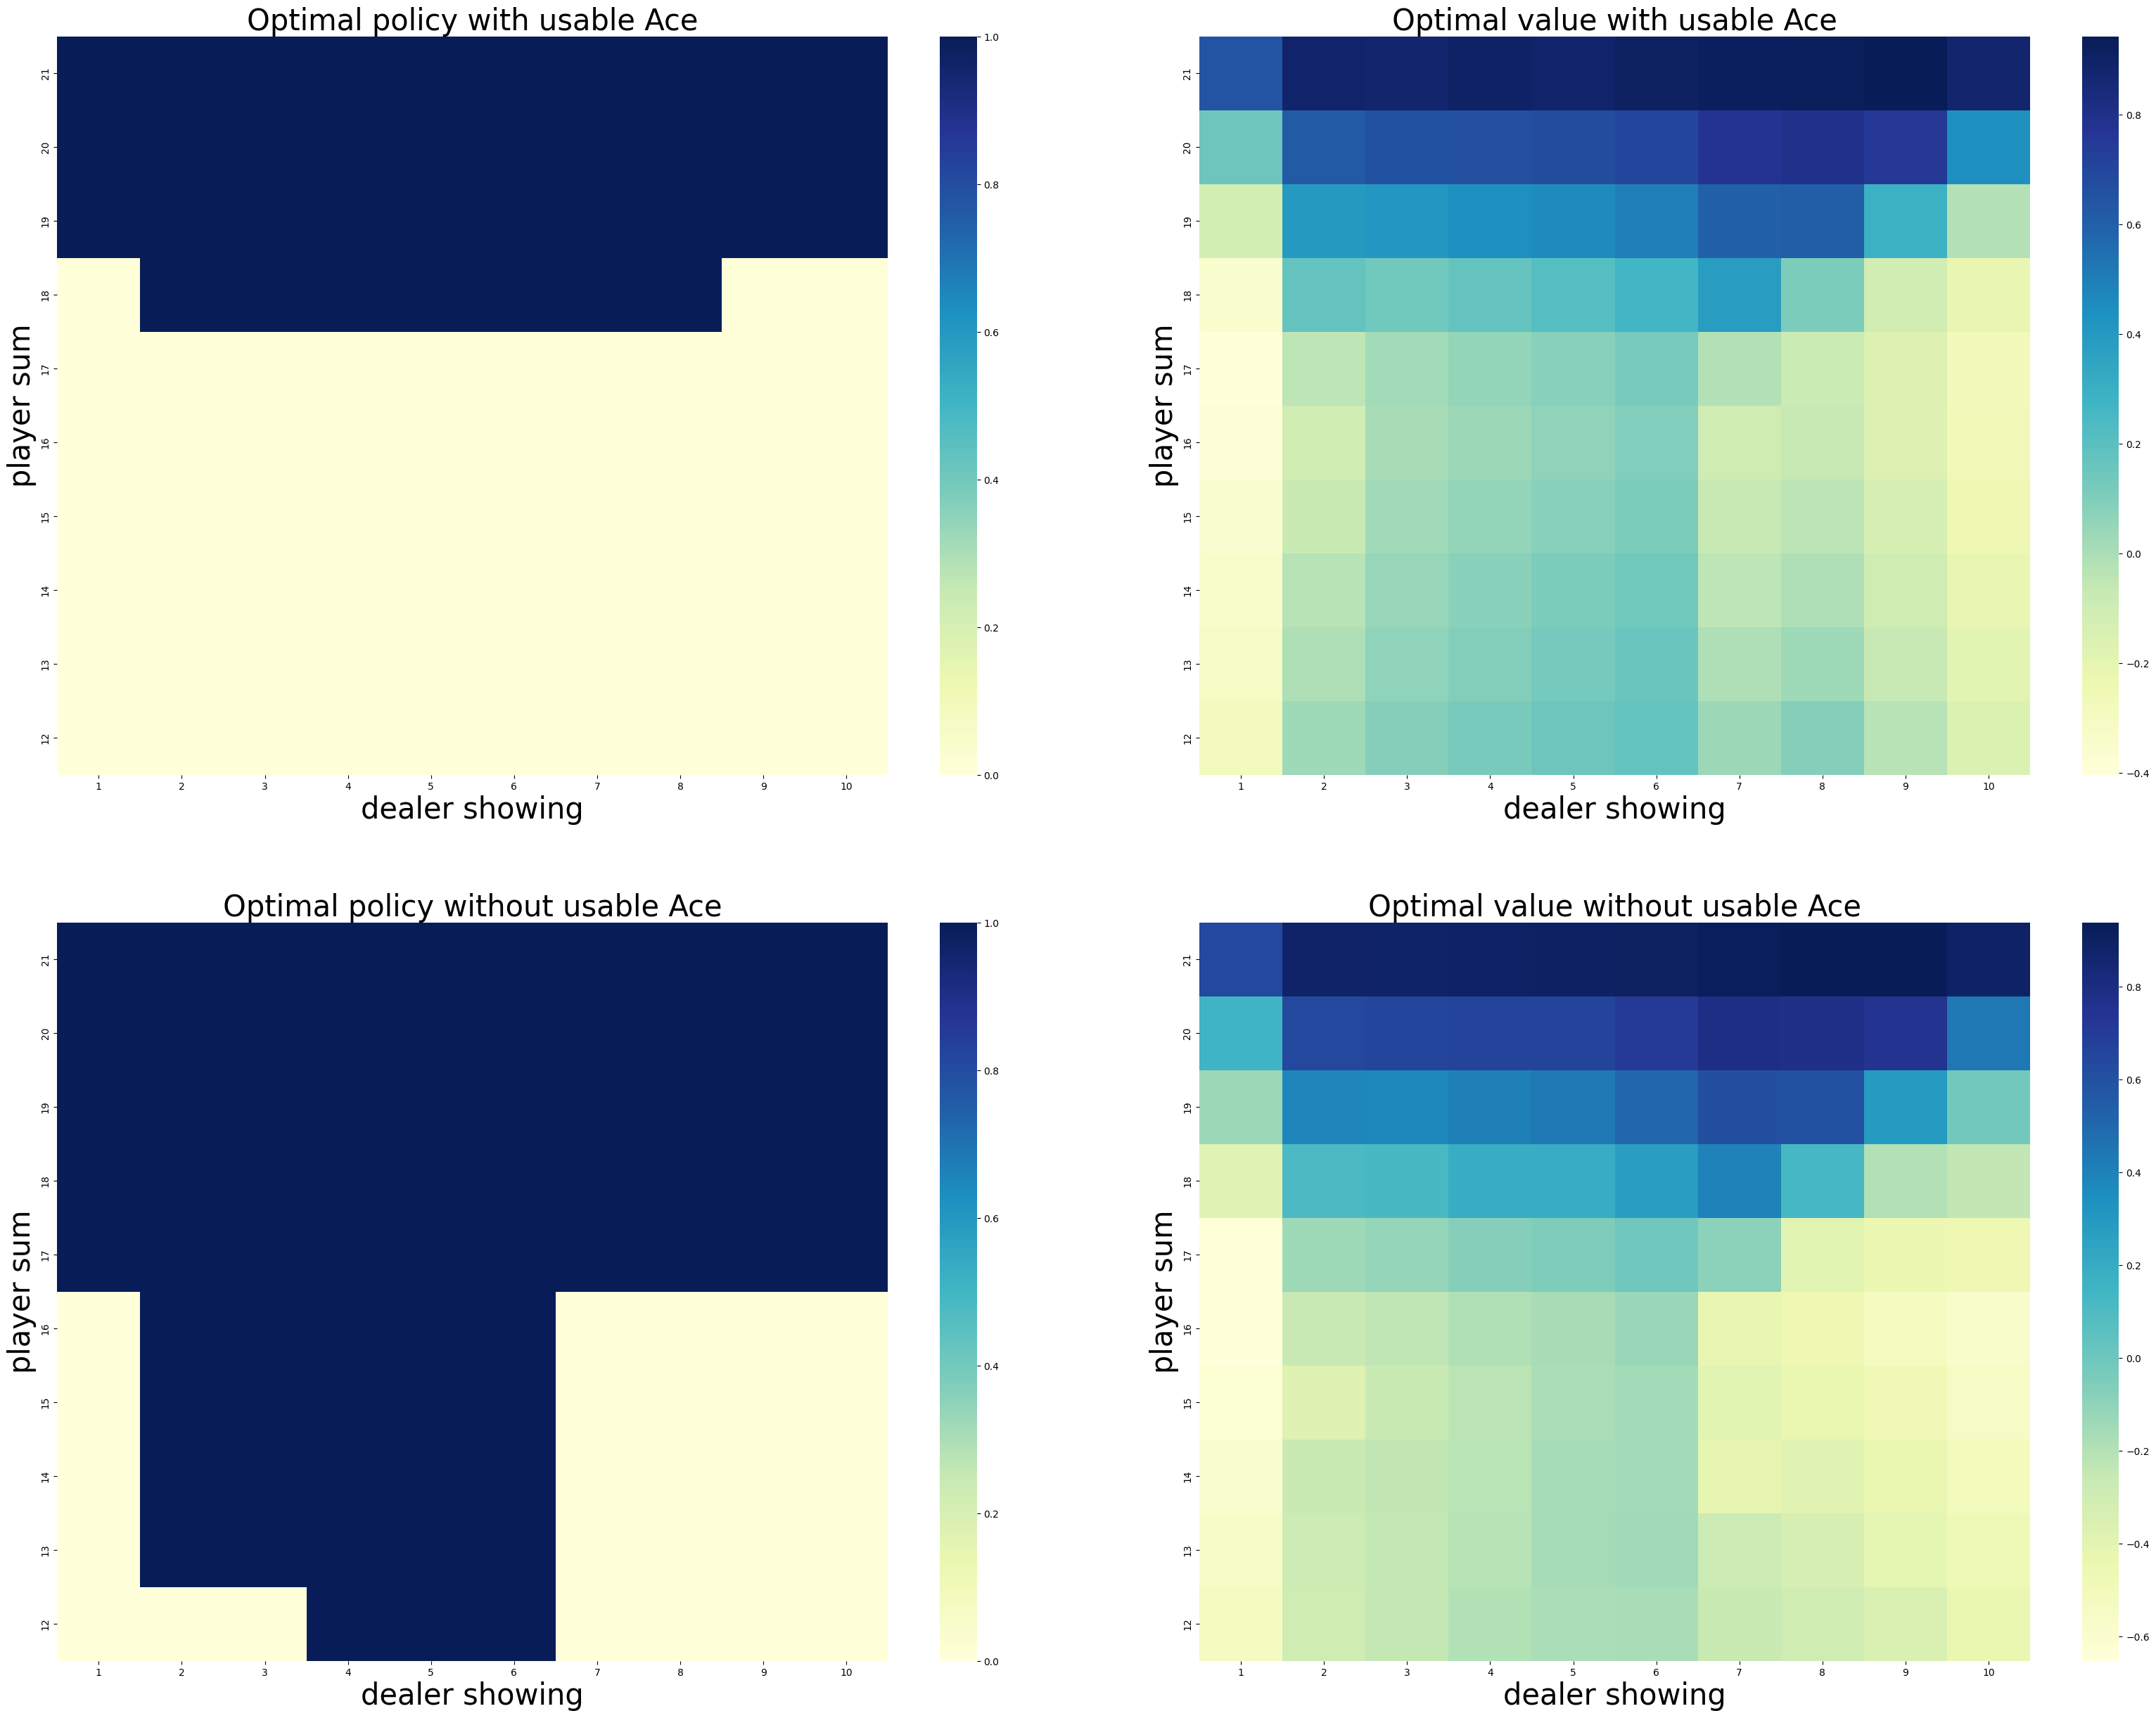

Checkpoint 3 of 9


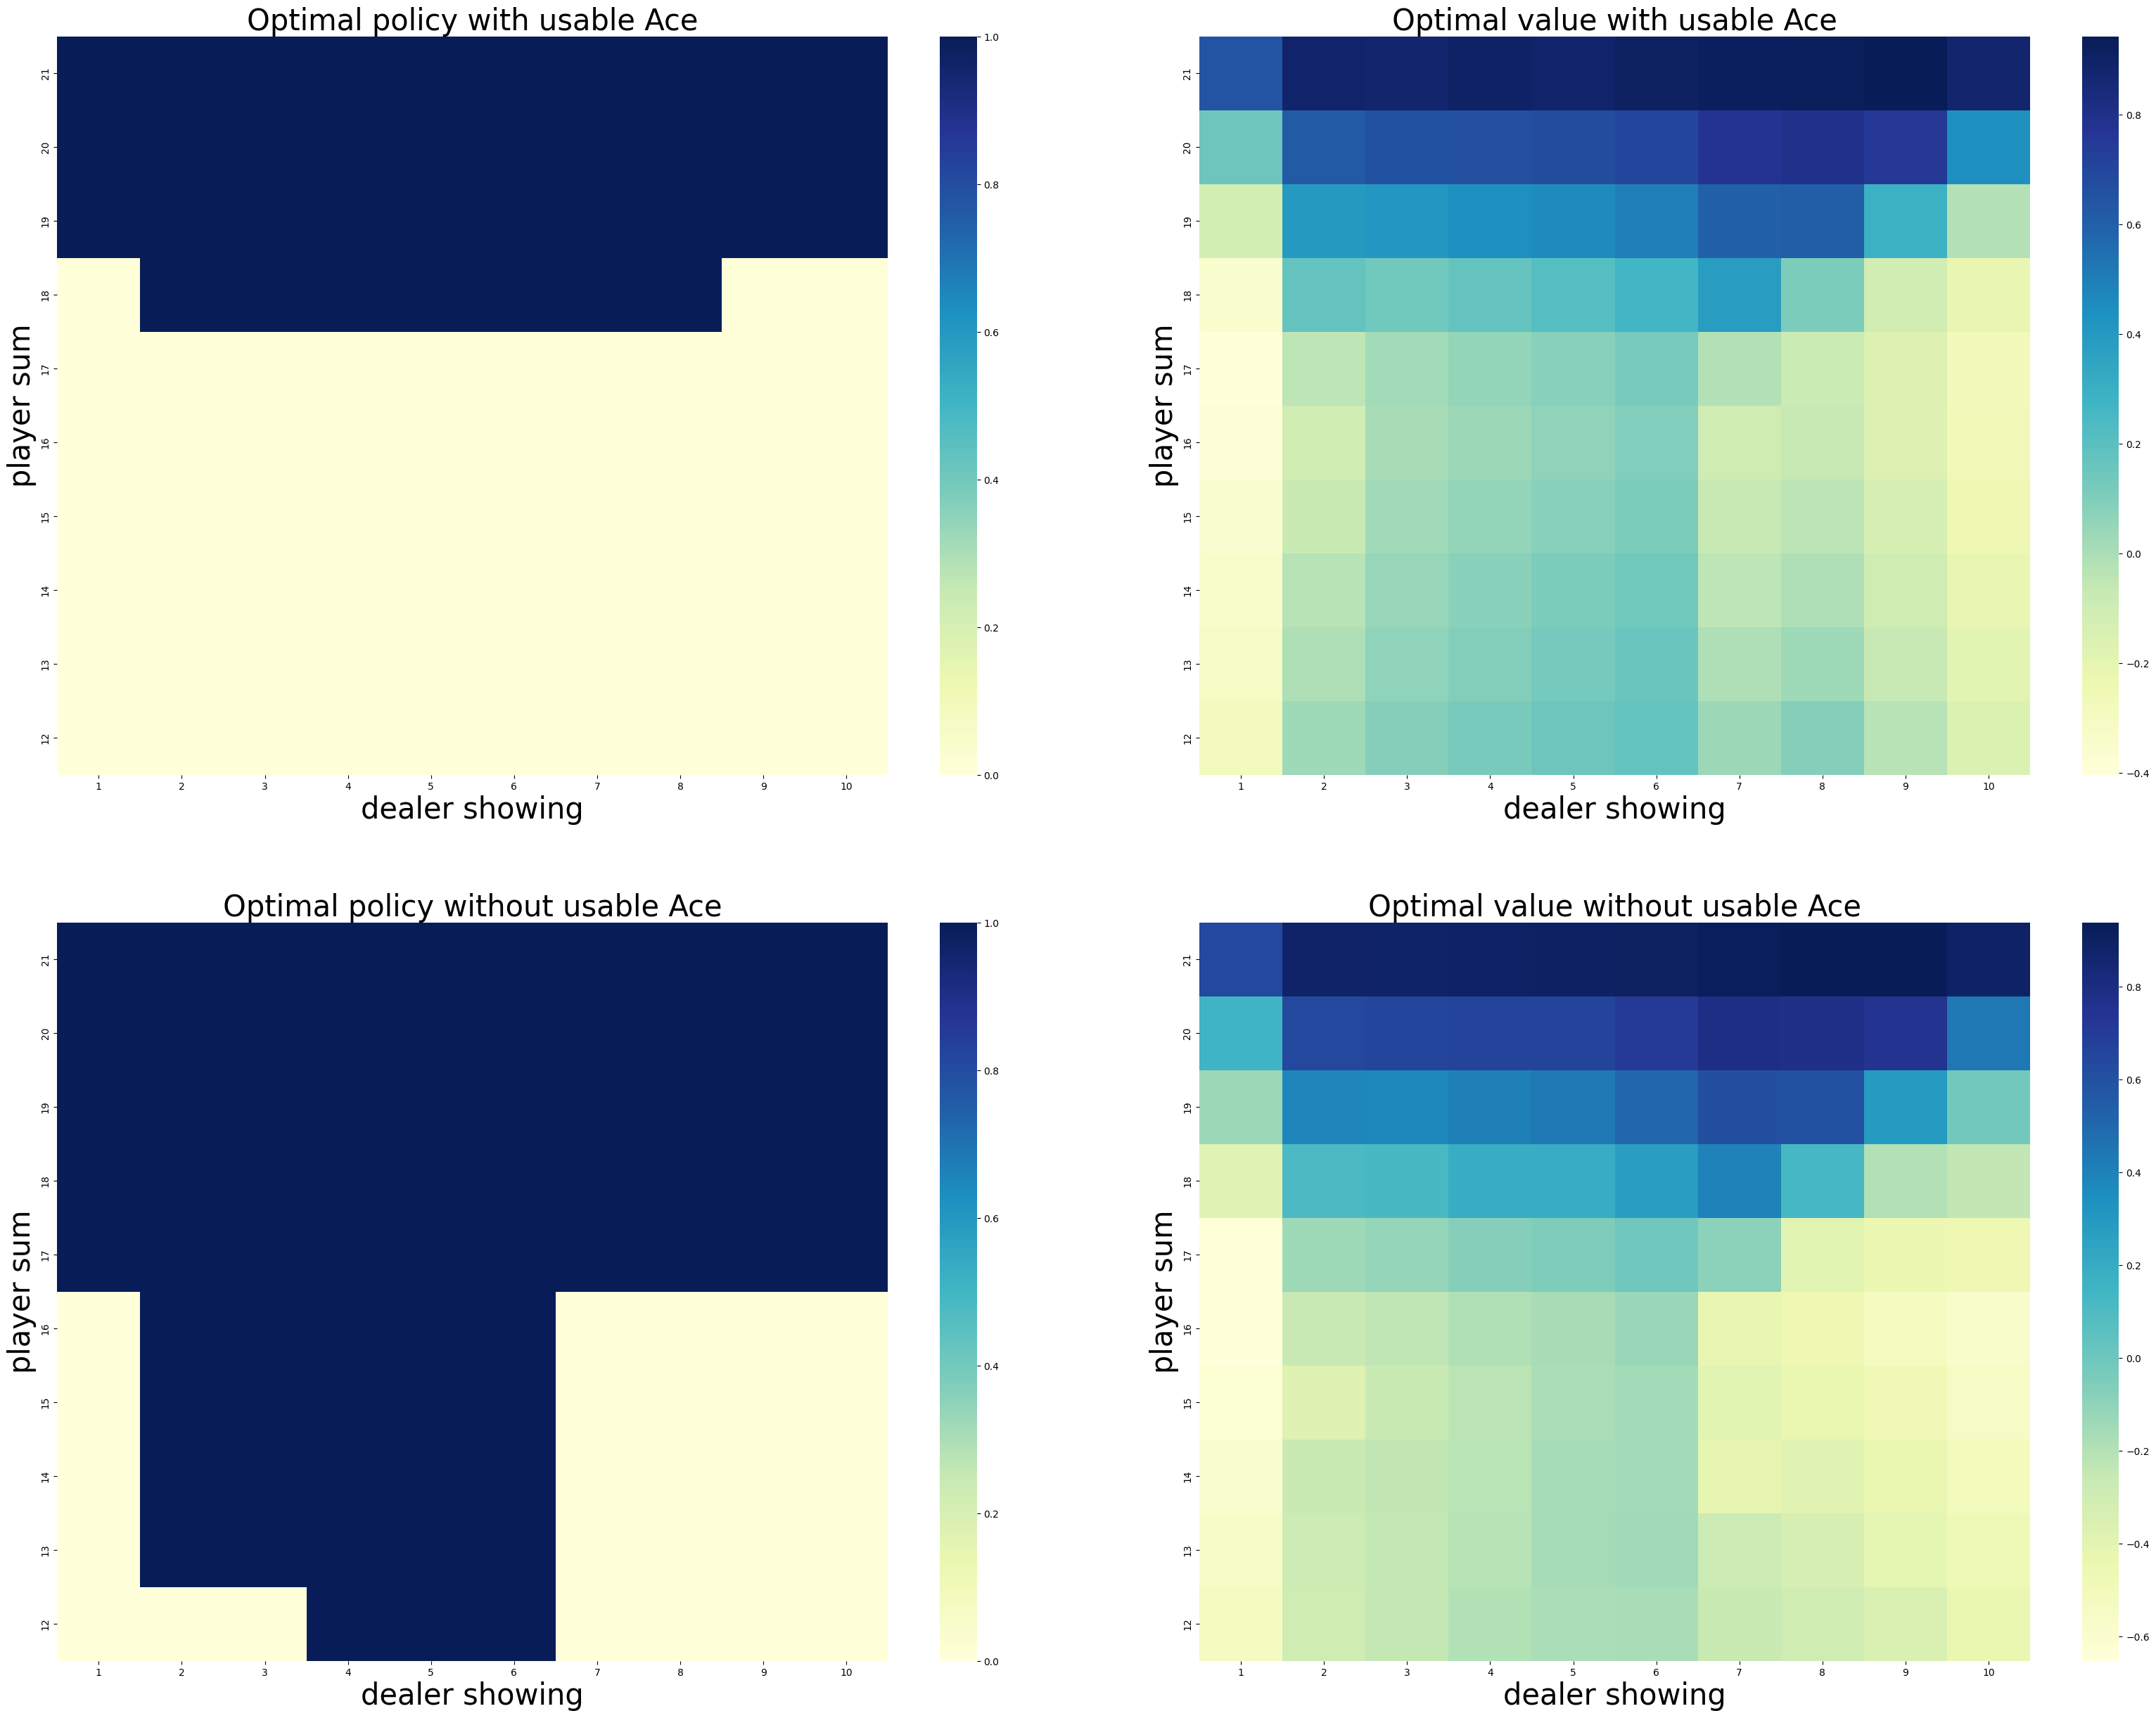

Checkpoint 4 of 9


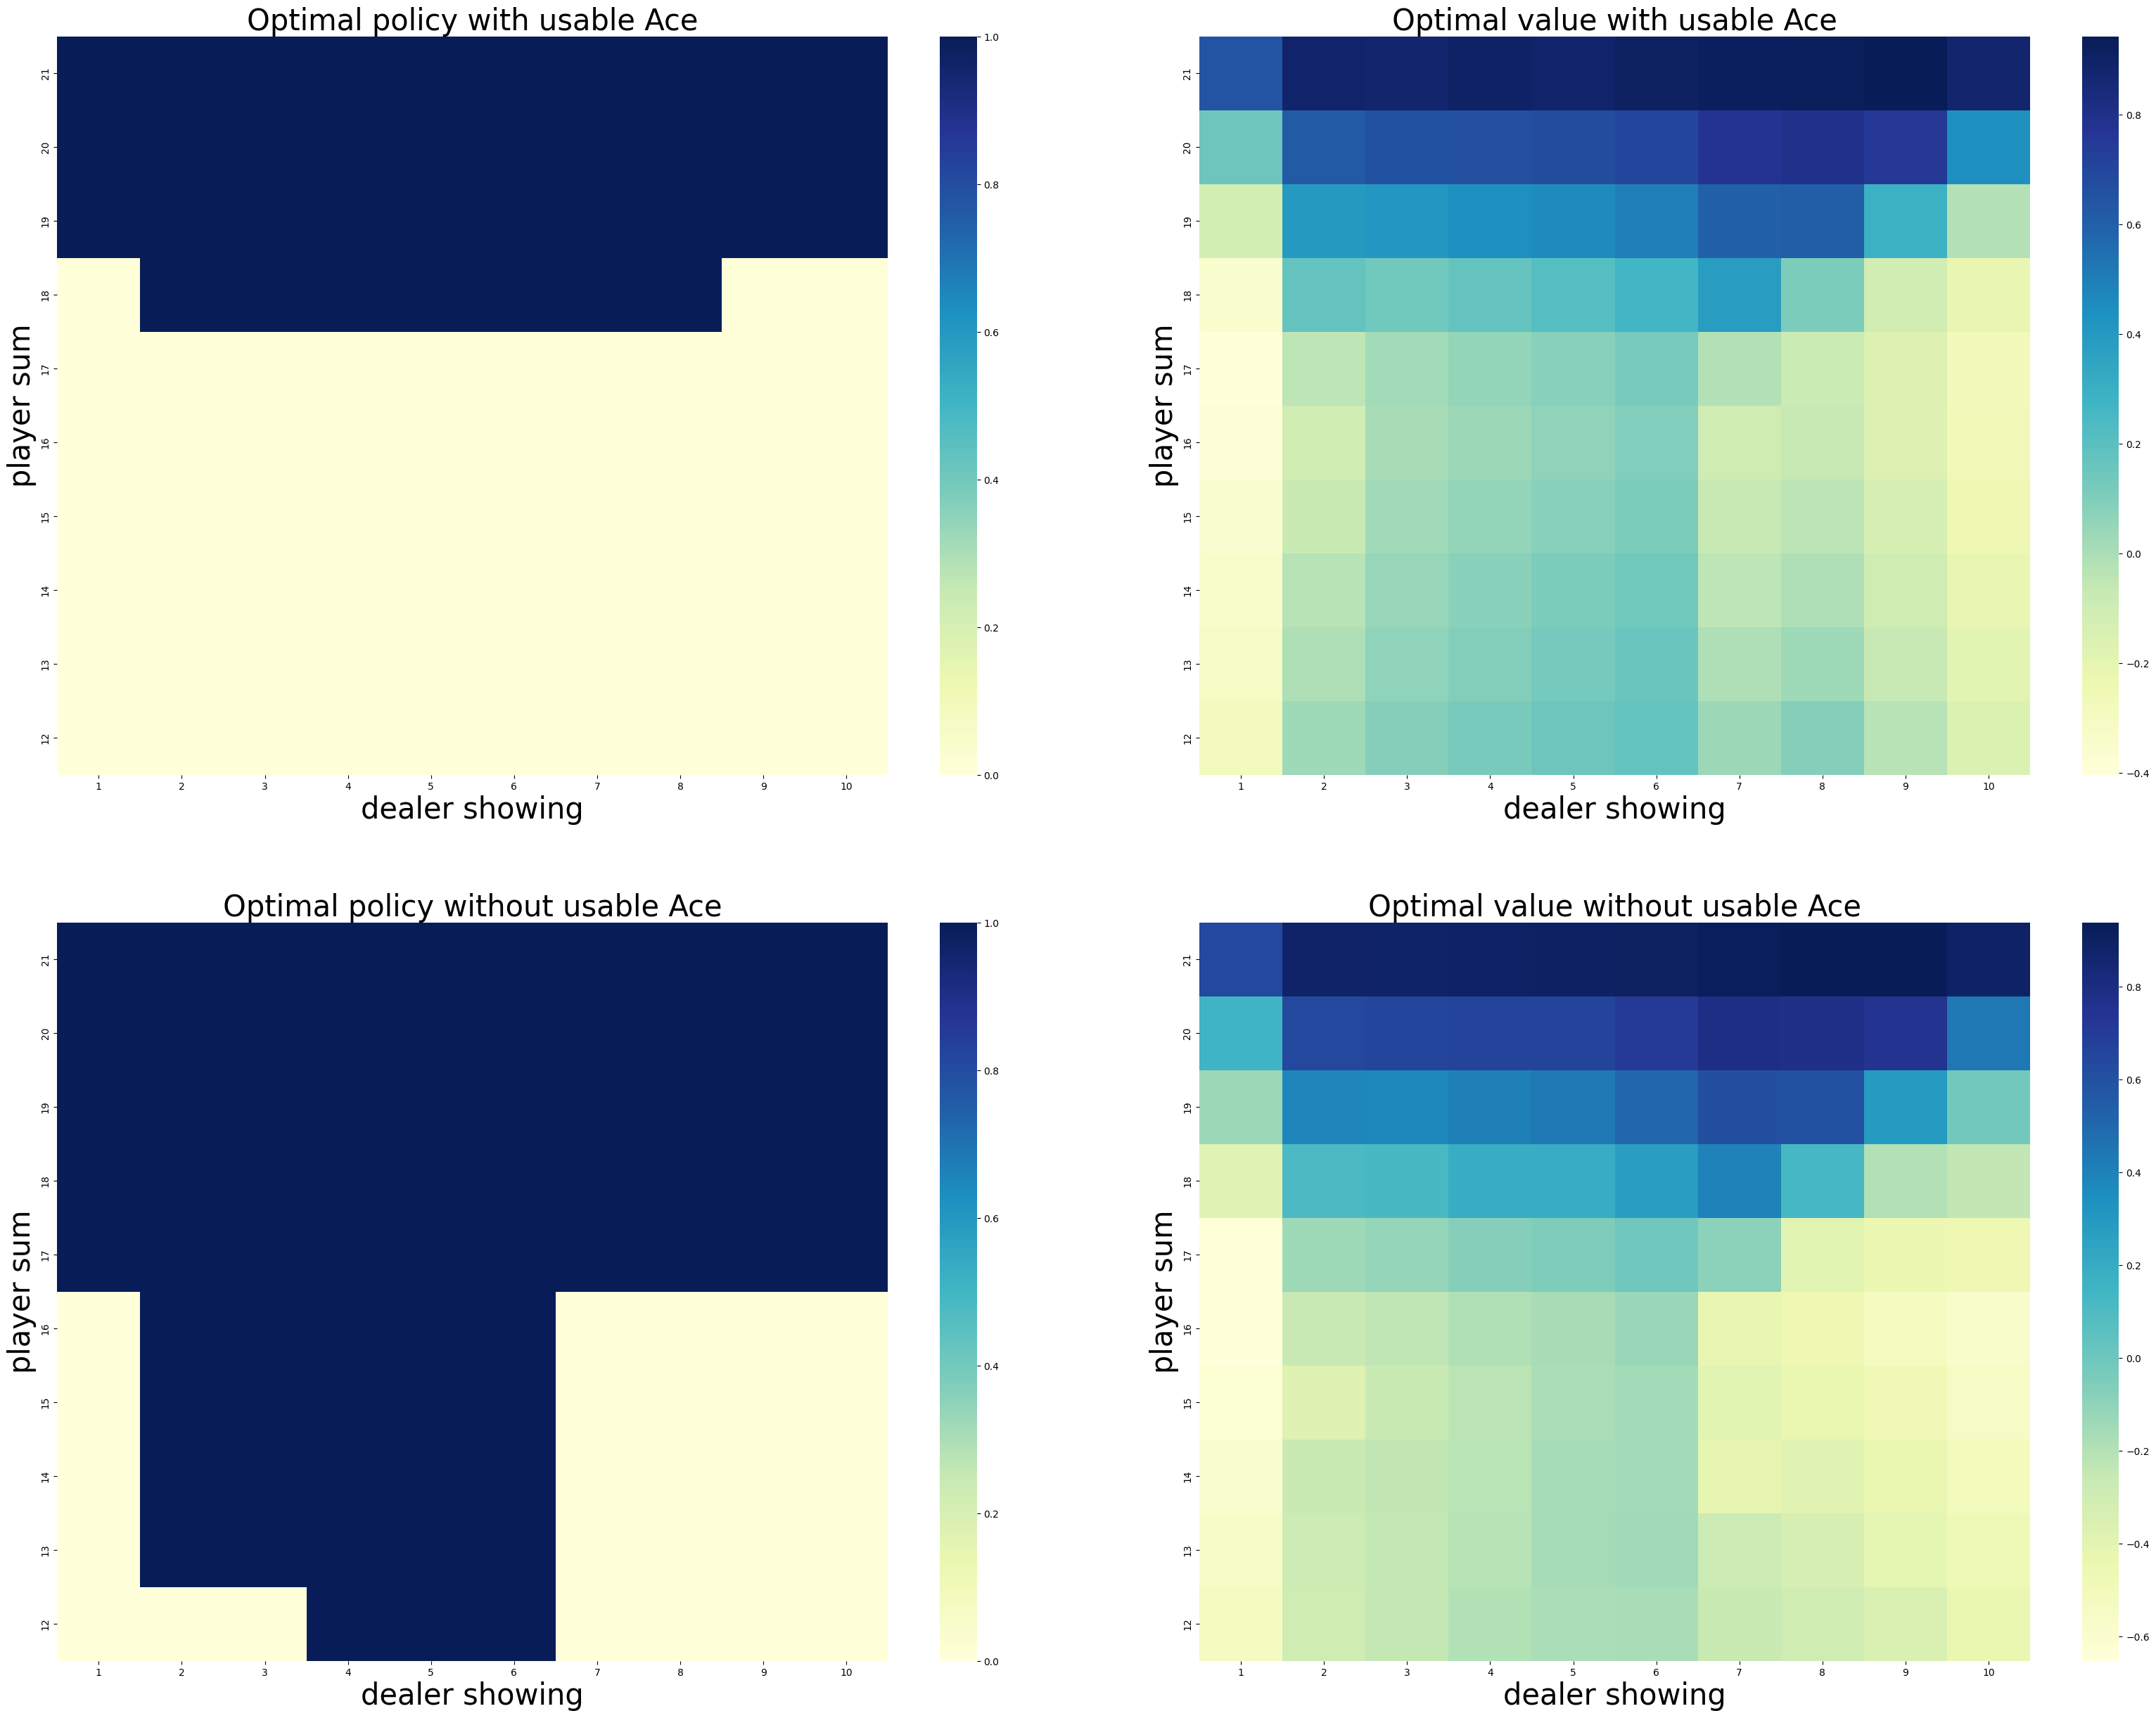

Checkpoint 5 of 9


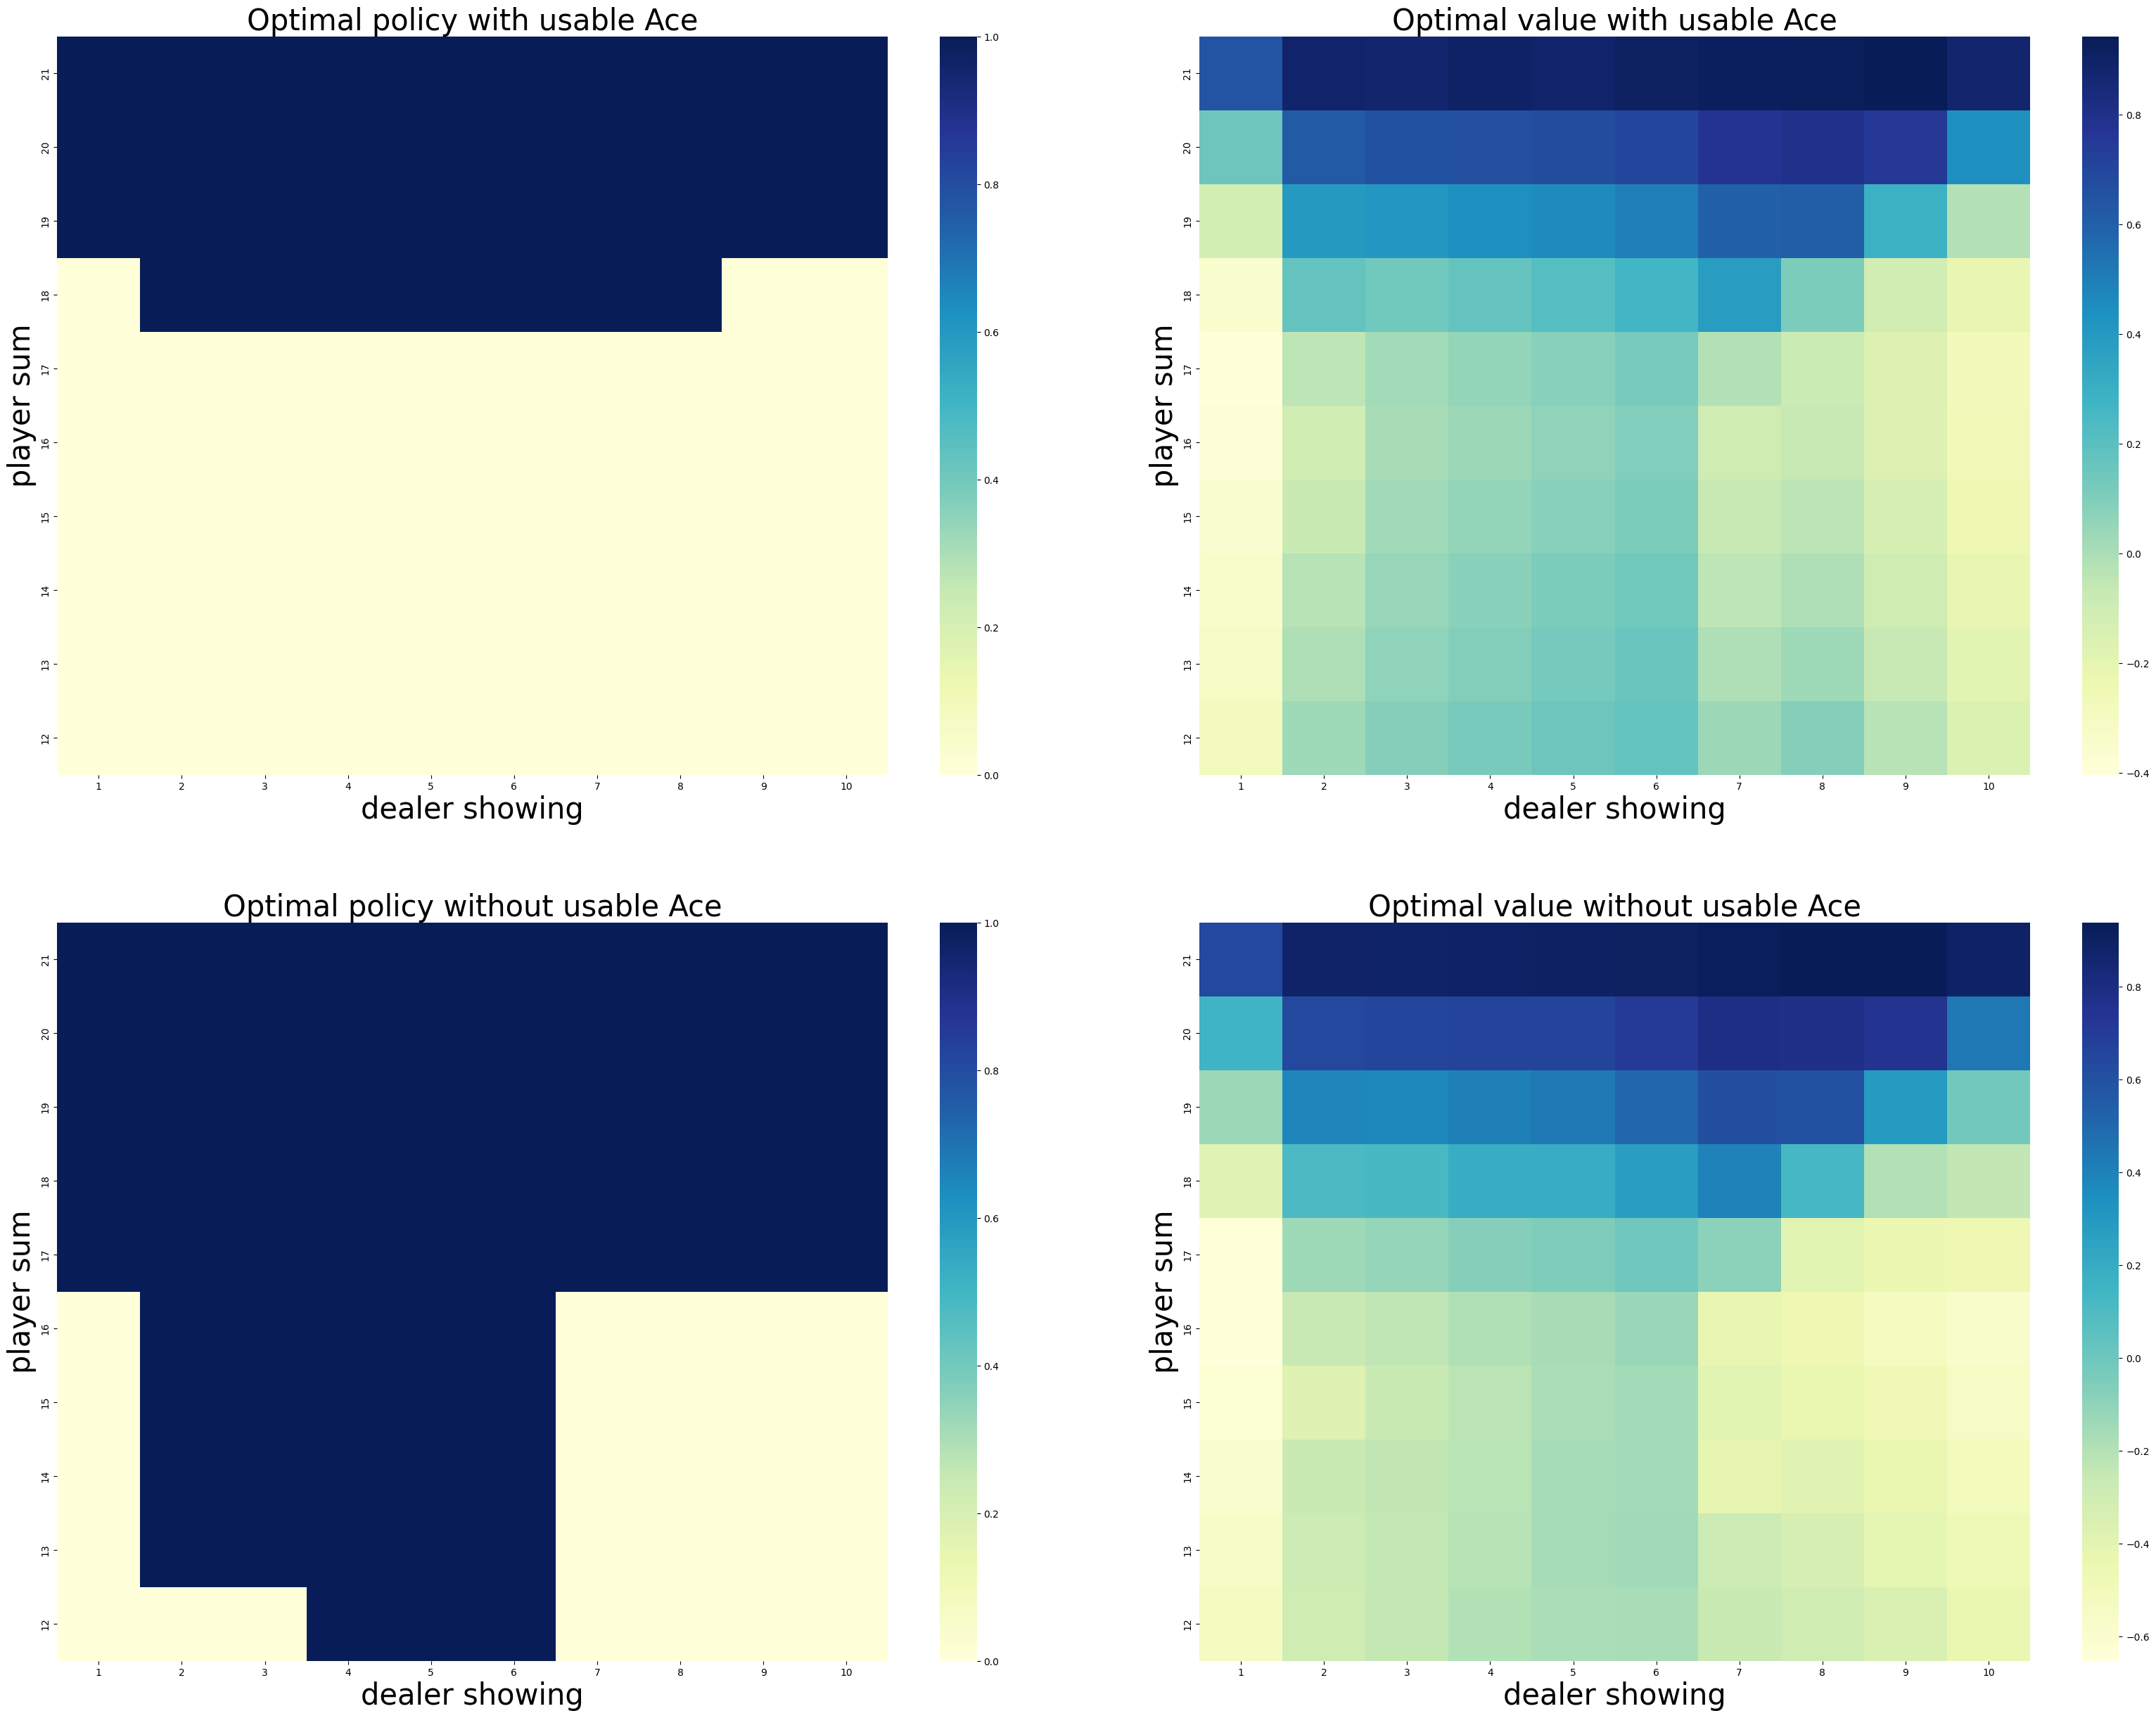

Checkpoint 6 of 9


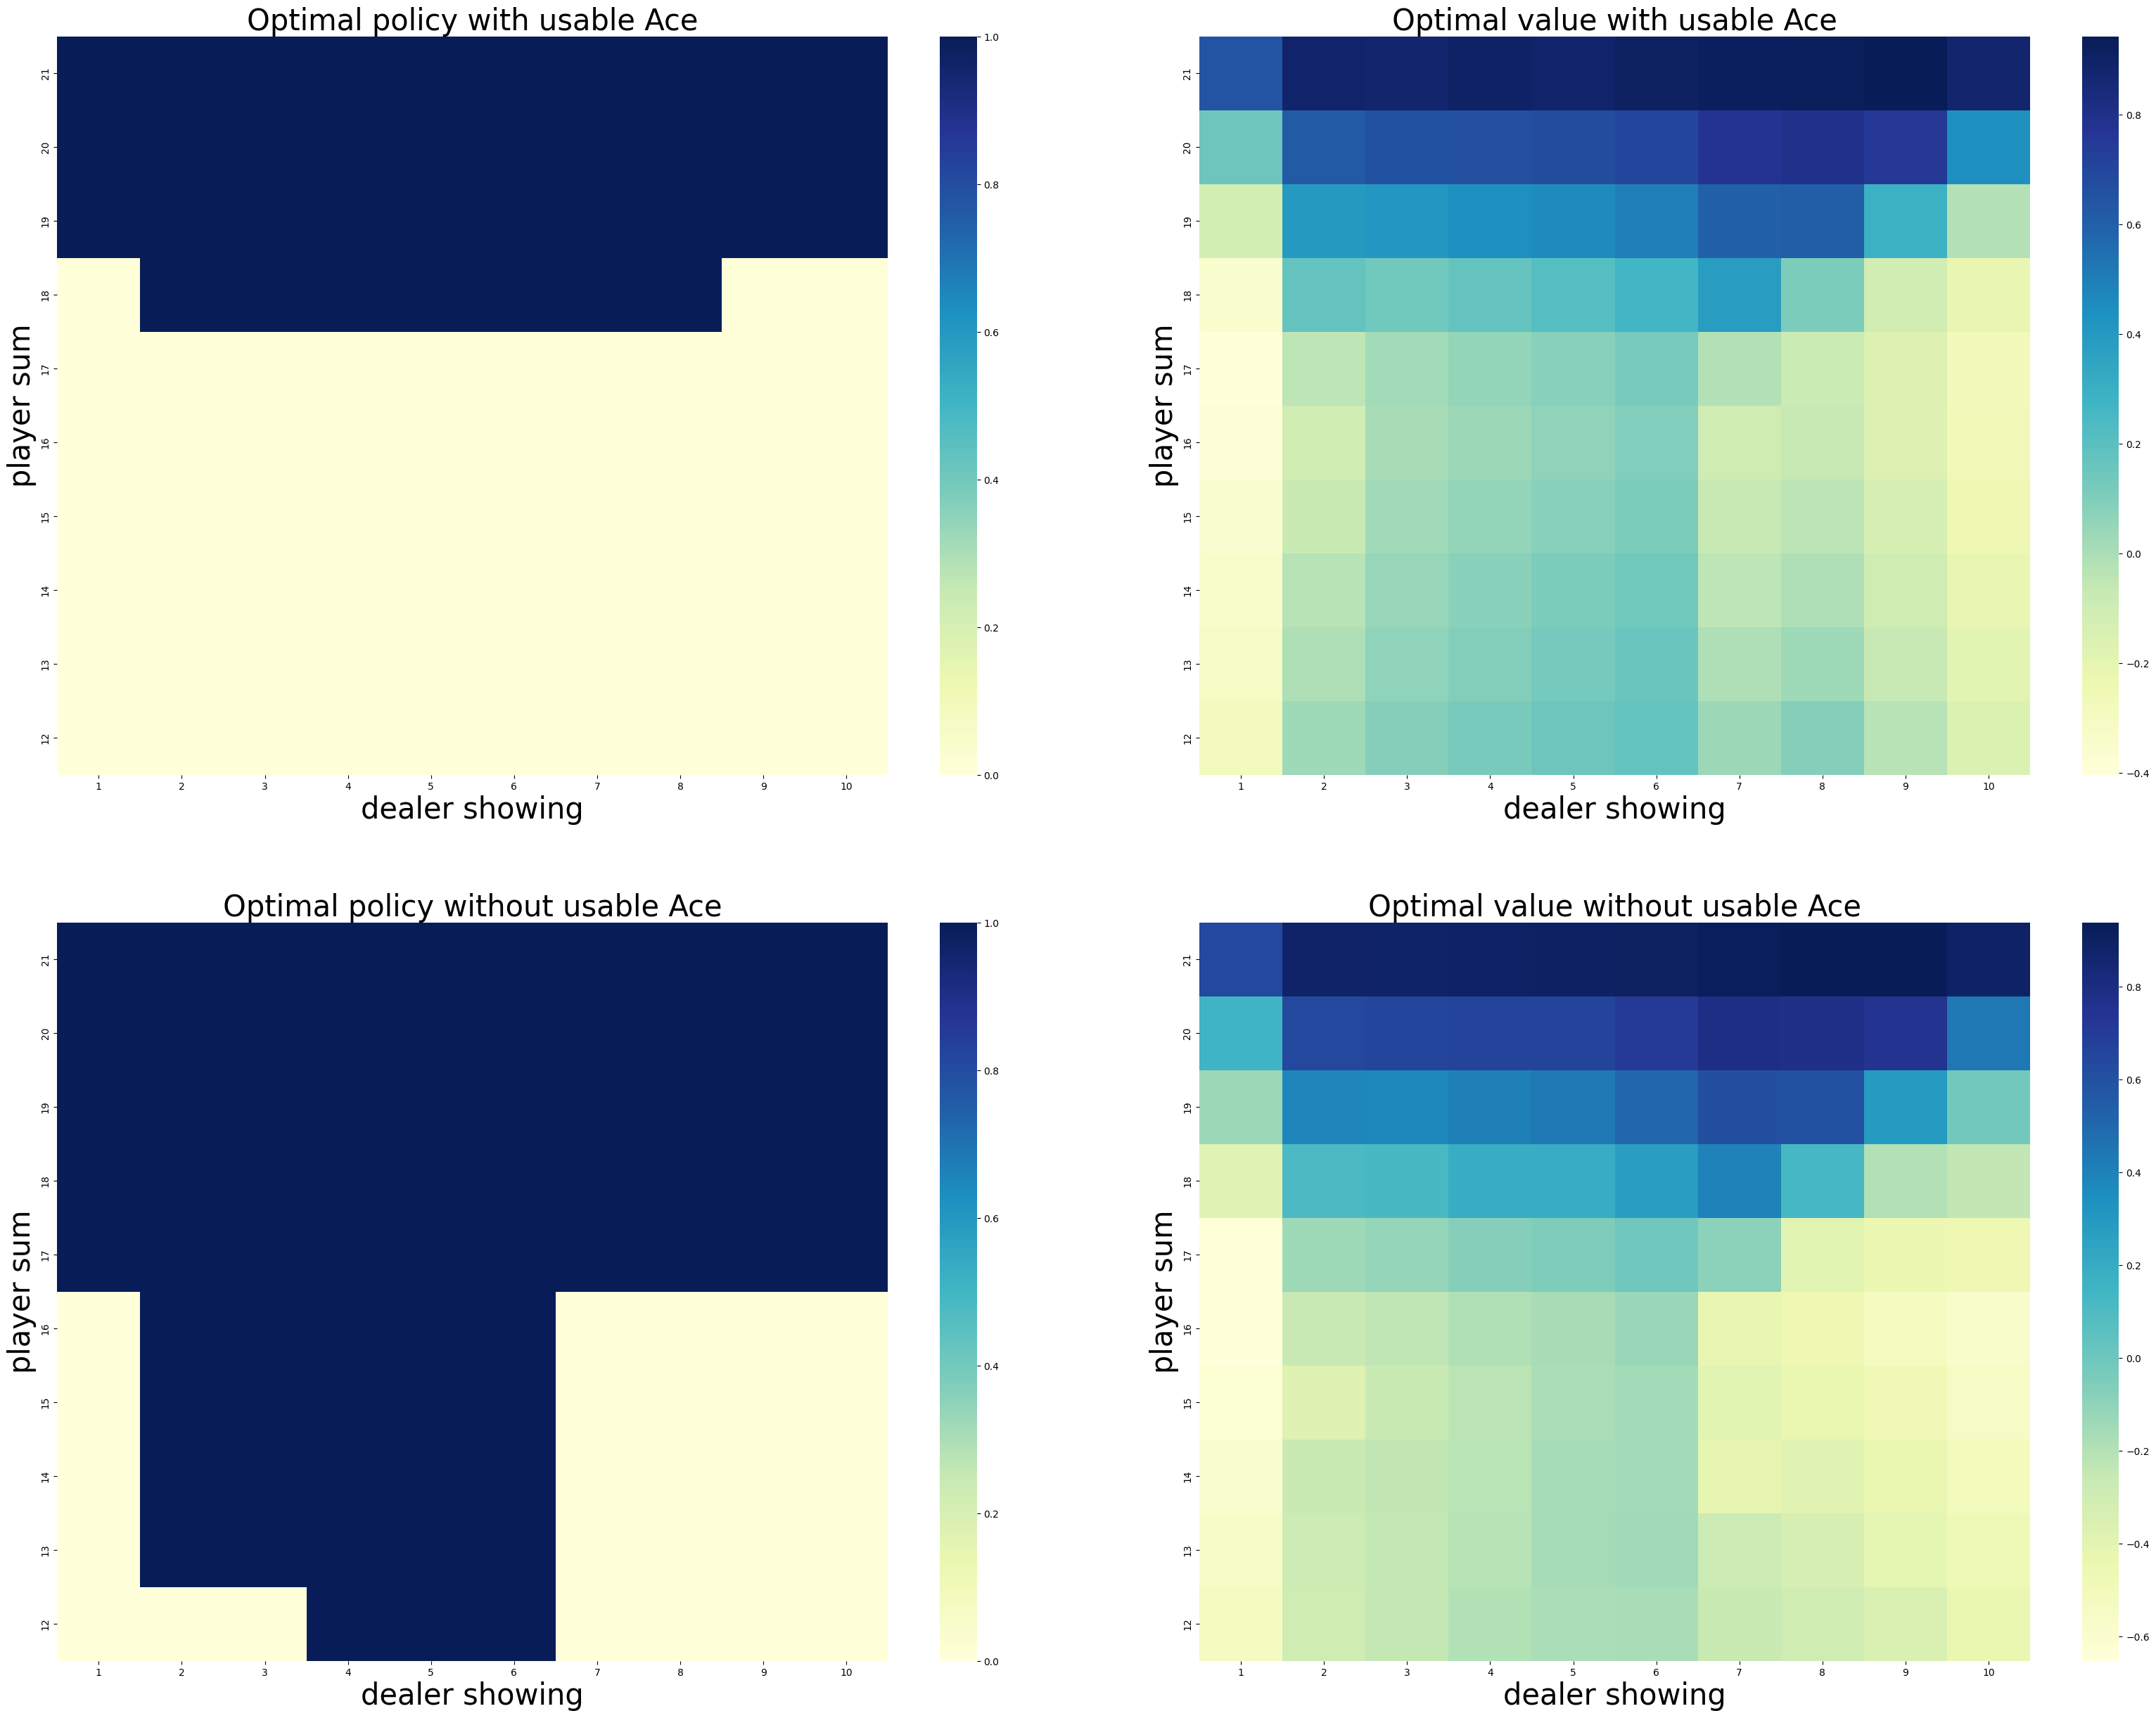

Checkpoint 7 of 9


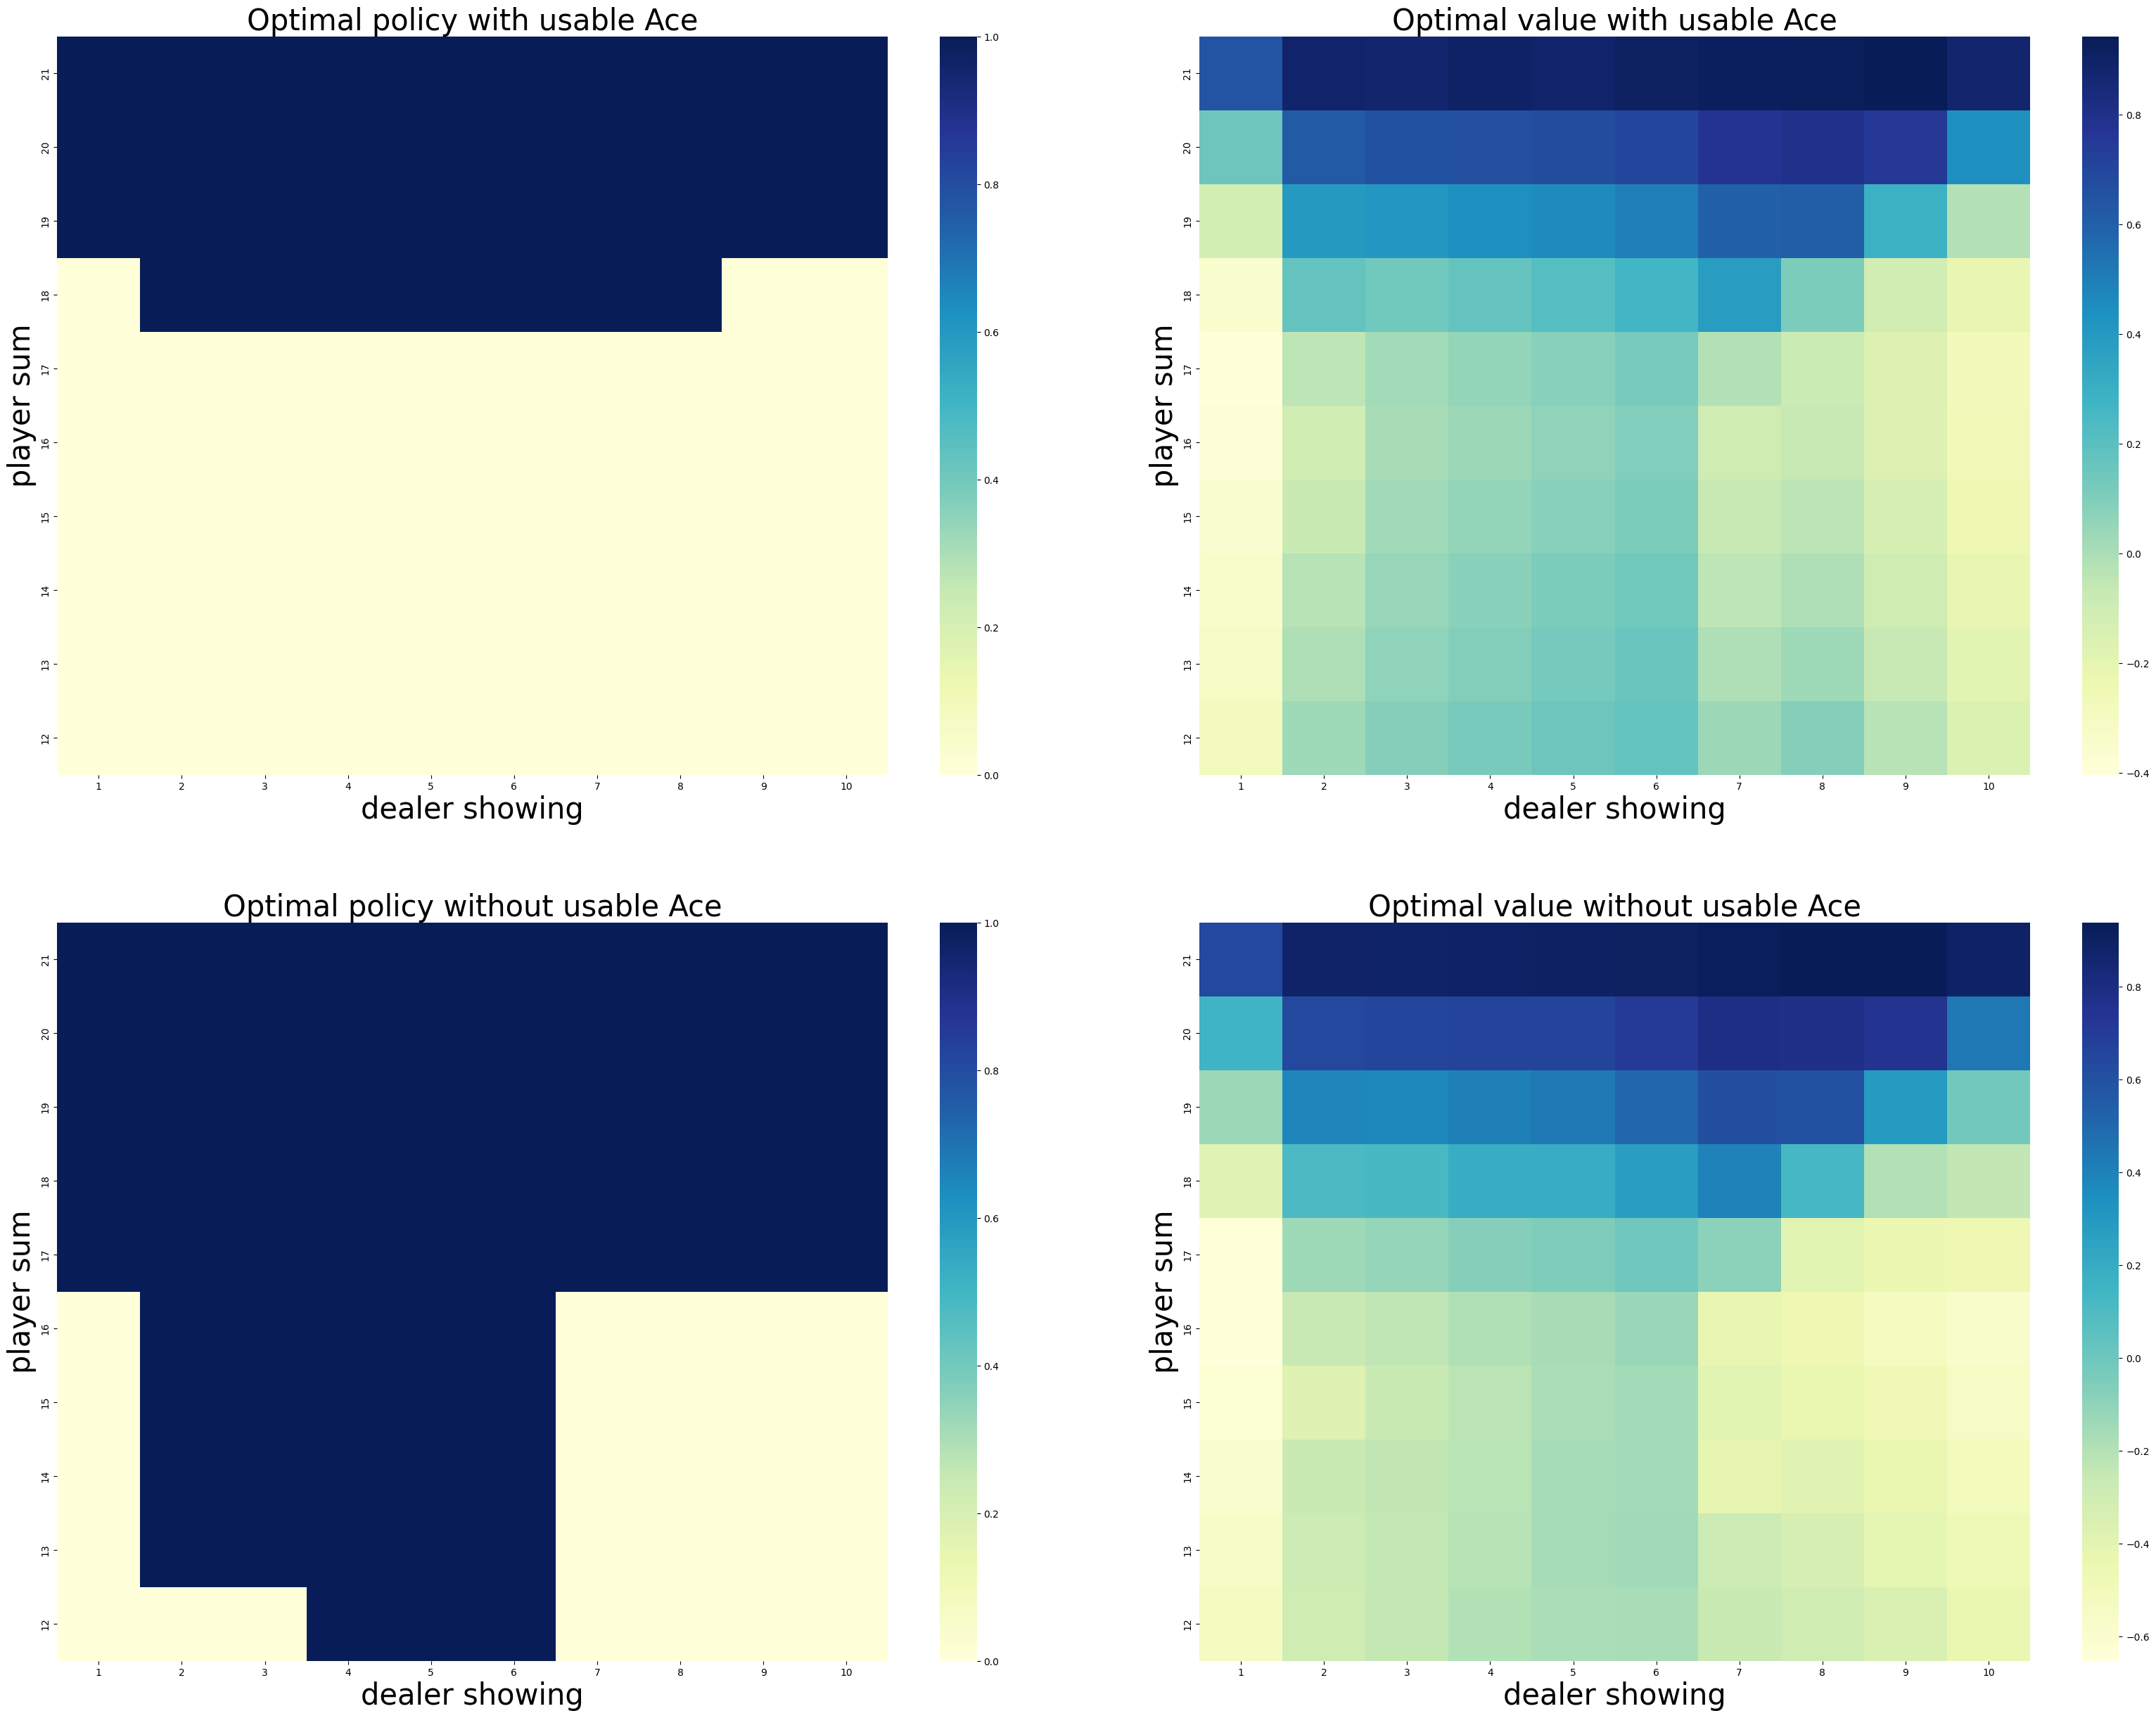

Checkpoint 8 of 9


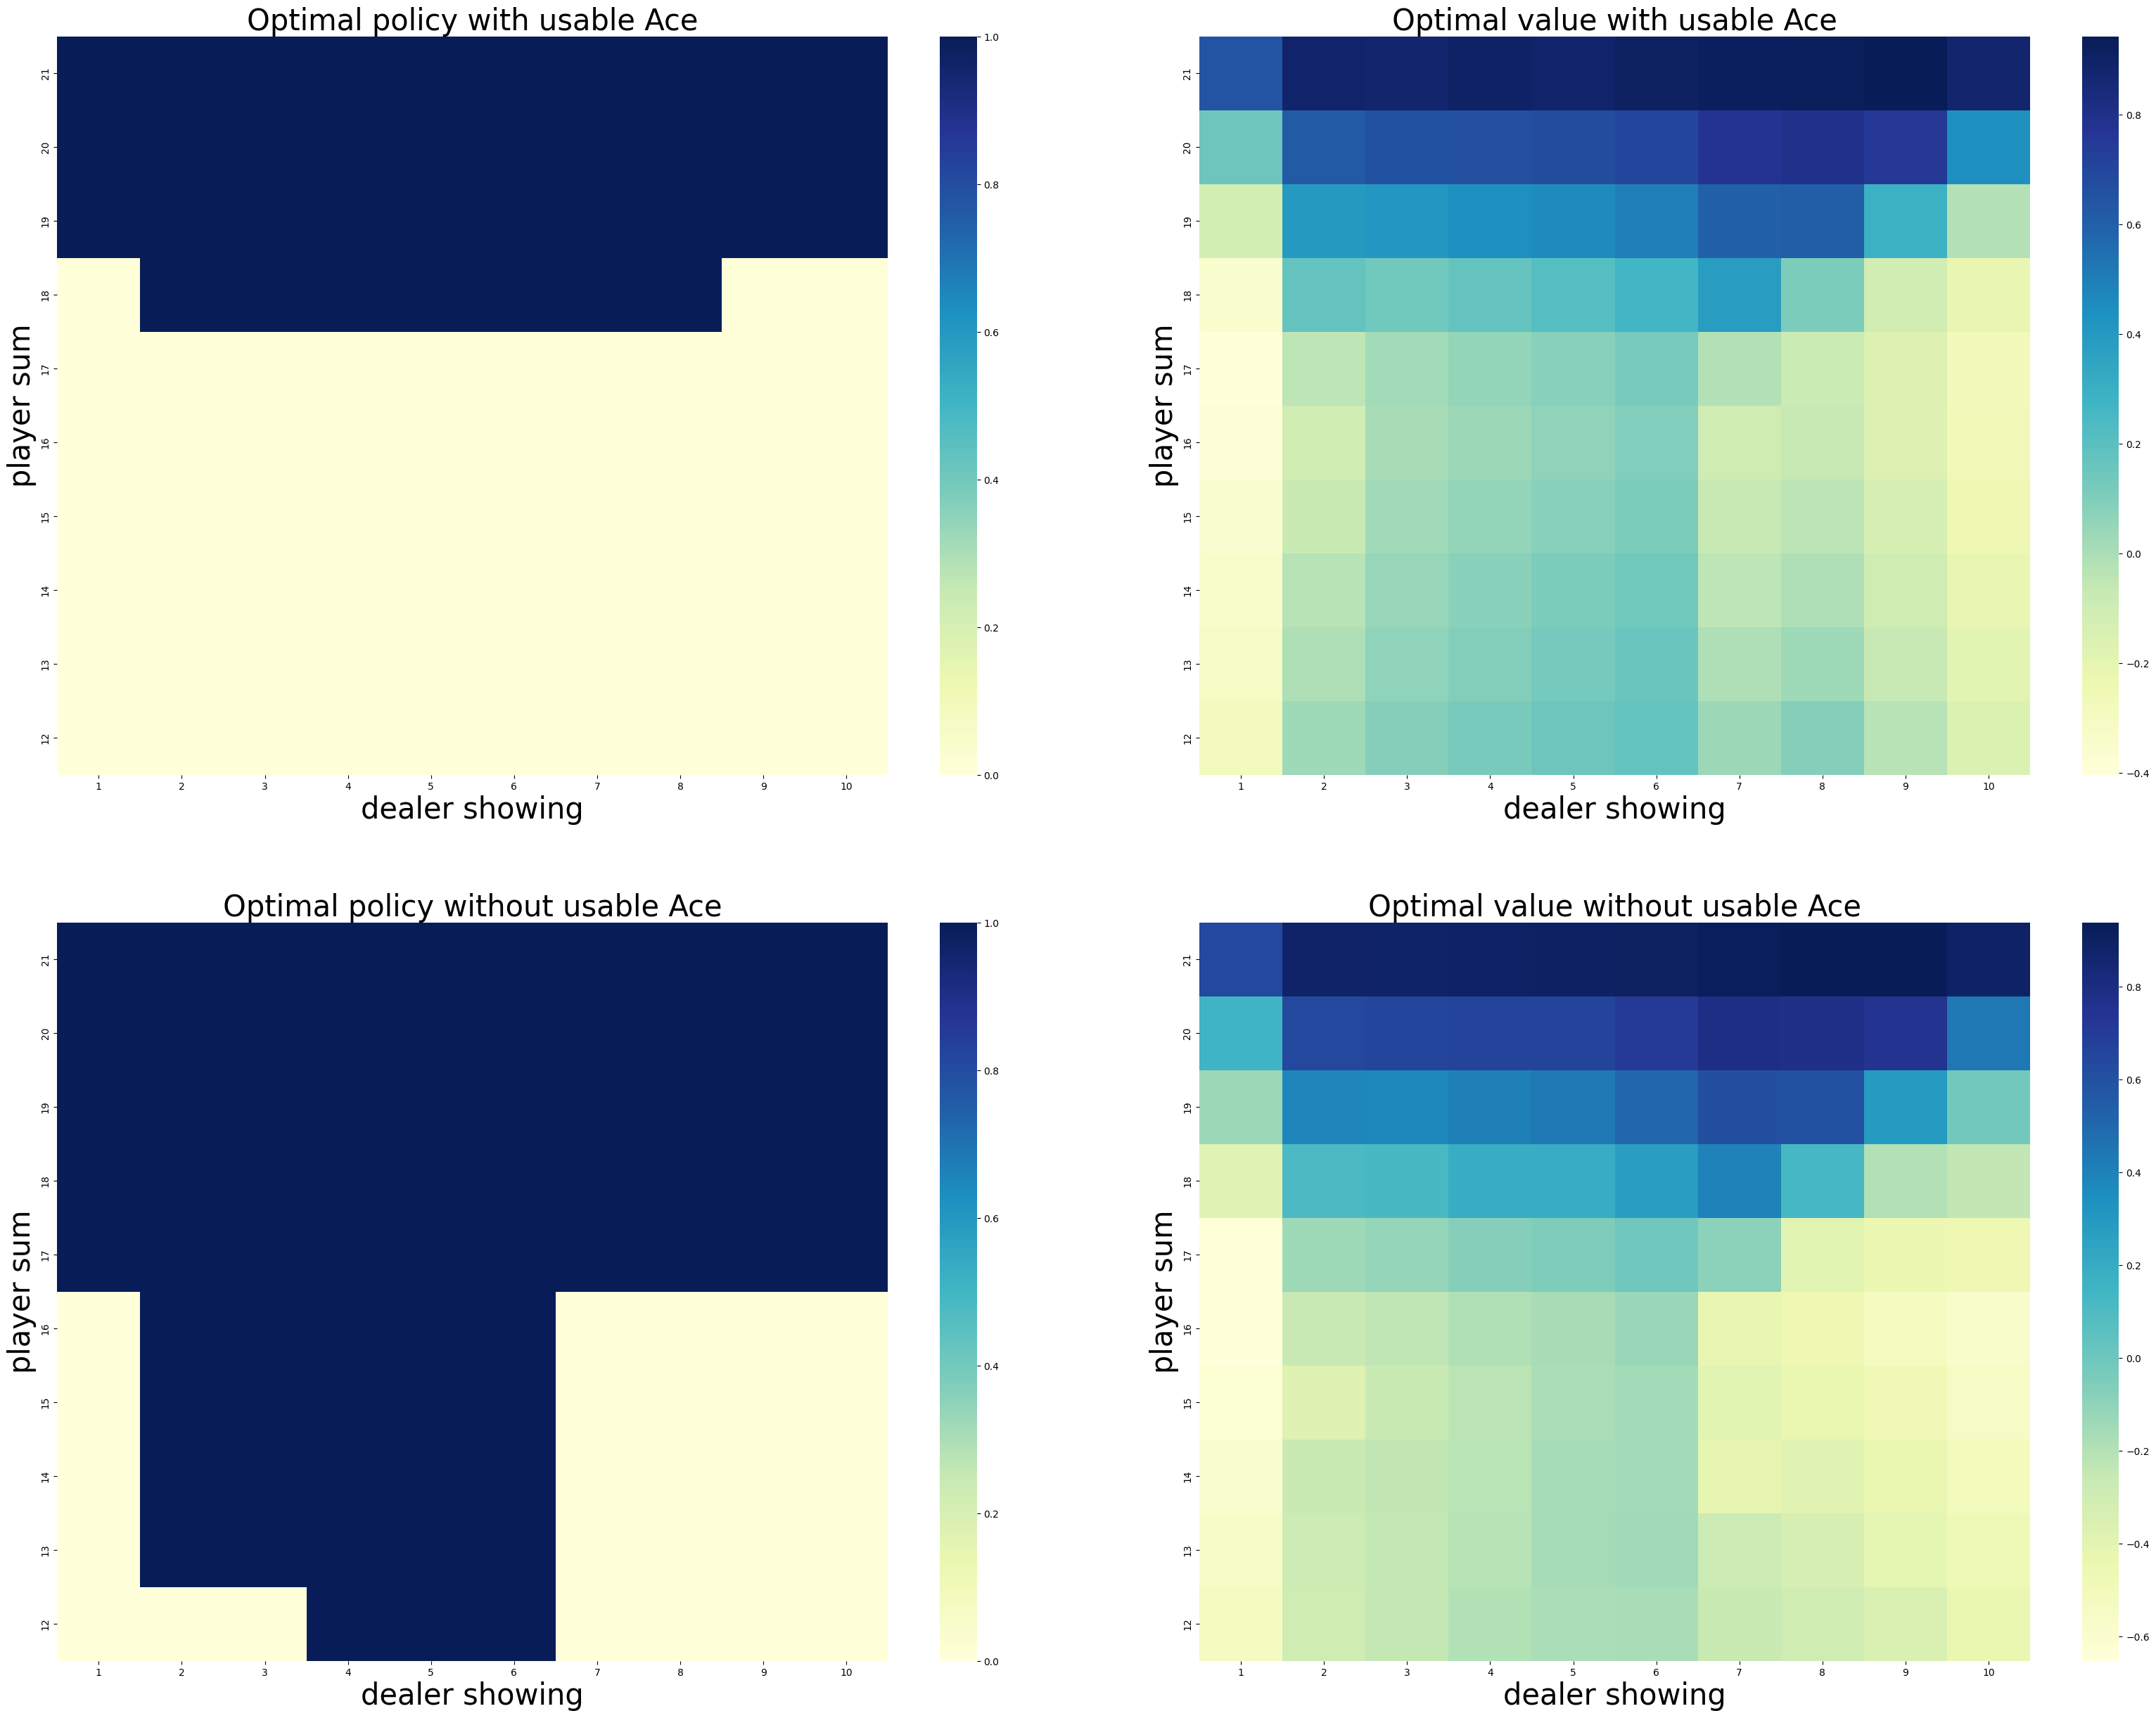

Checkpoint 9 of 9


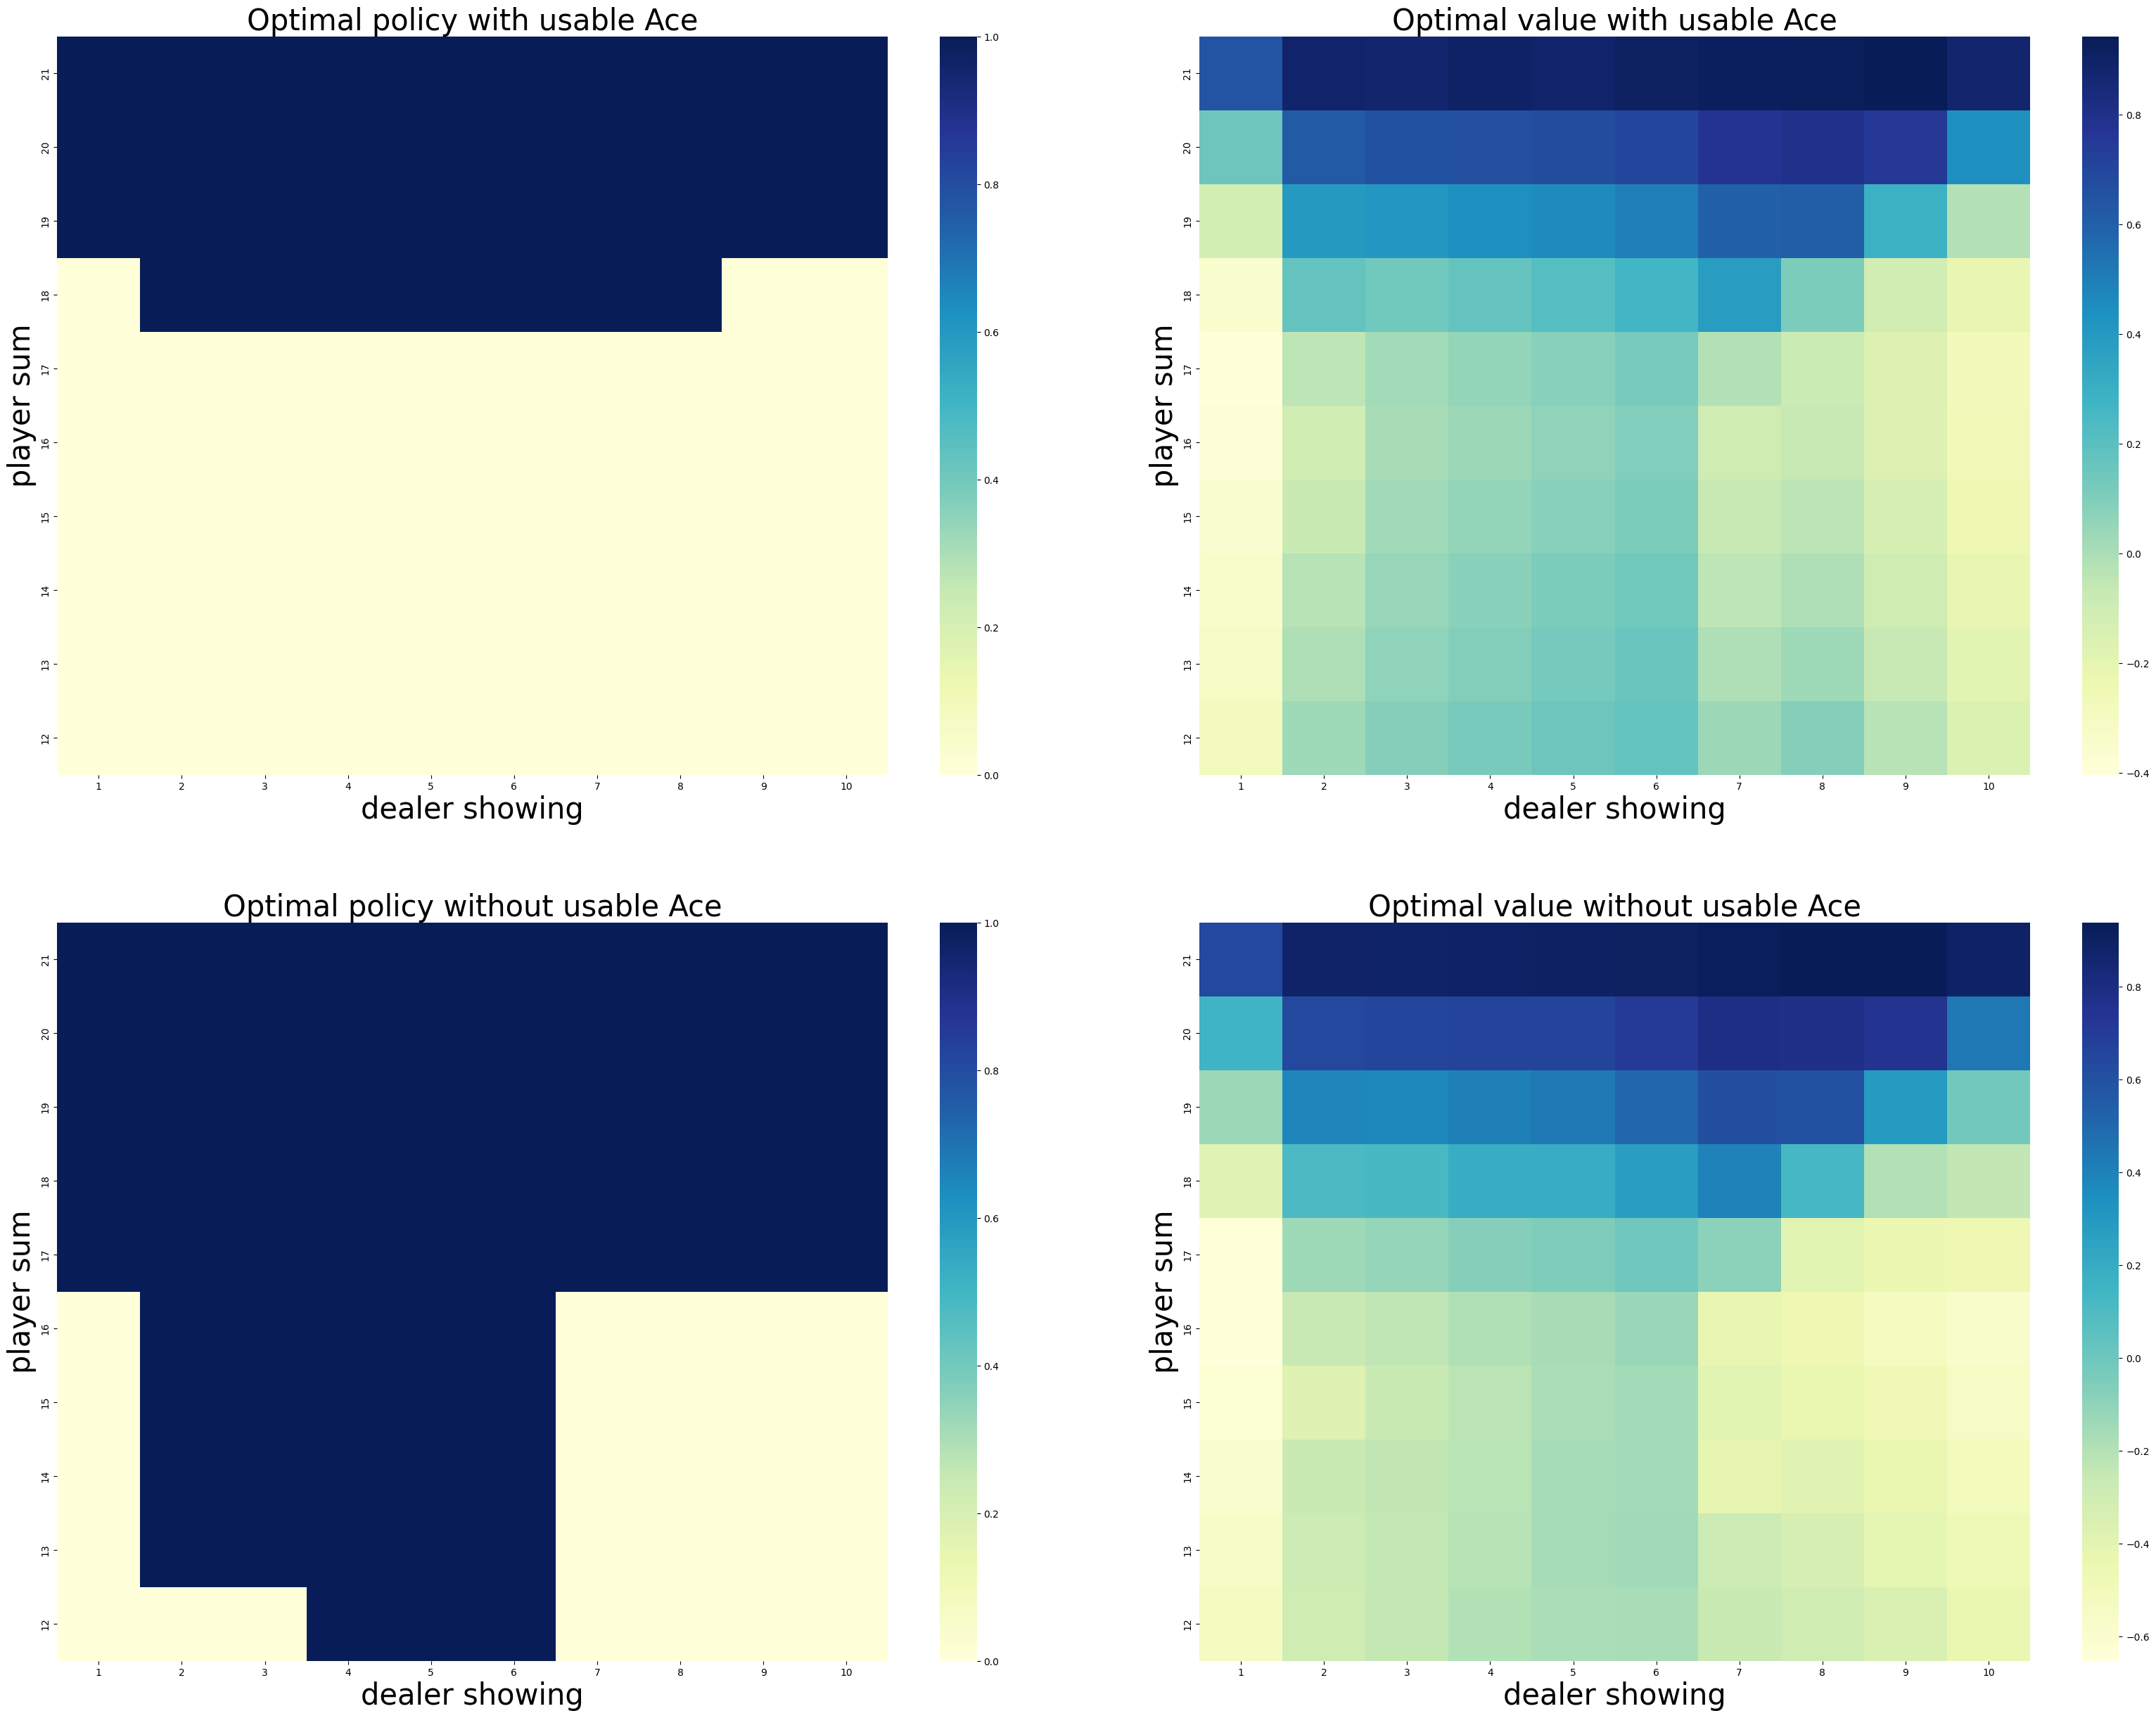

In [ ]:
figure_5_4(episodes=5000000,alpha=0.2,epsilon=0.05,ckpts=[1000000,1500000,2000000,2500000,3000000,3500000,4000000,4500000])

##1b
Q Learning

In [ ]:
def qlearn(episodes,alpha=0.05,epsilon=0.05,ckpts=[],use_decay_factor=True):
    # (playerSum, dealerCard, usableAce, action)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))

    # behavior policy is epsilon greedy, and is also the target policy in sarsa
    def behavior_policy(player_sum, dealer_card,usable_ace, epsilon=.05):
        usable_ace = int(usable_ace)
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        values_ = state_action_values[player_sum-12, dealer_card-1, usable_ace, :]
        if np.random.random() < epsilon:
          return np.random.choice([action_ for action_, value_ in enumerate(values_)])
        else:
          return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    progress_bar = tqdm(range(episodes))
    reward = -2 # Not a real reward
    episode_rewards=[]
    ckpt_state_action_values = []
    alpha_decay_factor = 2**(np.log2(.001)/(episodes/1000)) # Mult alpha by this every 1000 episodes, reaches .001 of original value by end
    for episode in progress_bar:
      if episode in ckpts:
        ckpt_state_action_values.append(state_action_values)
      if episode != 0:
        episode_rewards.append(reward)
      if episode%1000 == 0 and episode > 0:
        progress_bar.set_description(f"Avg reward so far = {np.mean(episode_rewards):.4f}")
        if use_decay_factor:
          alpha *= alpha_decay_factor
      # for each episode, use a randomly initialized state and action
      initial_state = [np.random.choice(range(12,22)),
                      np.random.choice(range(1, 11)),
                      np.random.choice(range(0, 2))]
      current_policy = behavior_policy #if episode else target_policy_player
      initial_action = current_policy(initial_state[0],initial_state[1],initial_state[2])

      player_sum, dealer_card1, usable_ace_player = initial_state
      dealer_card2 = get_card()

      # initial state of the game
      state = [player_sum-12, dealer_card1-1, usable_ace_player]

      # initialize dealer's sum
      dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
      usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
      # if the dealer's sum is larger than 21, he must hold two aces.
      if dealer_sum > 21:
          assert dealer_sum == 22
          # use one Ace as 1 rather than 11
          dealer_sum -= 10
      assert dealer_sum <= 21
      assert player_sum <= 21

      # game starts!
      player_bust = False

      # player's turn
      while True:
          if initial_action is not None:
              action = initial_action
              initial_action = None

          # # track player's trajectory for importance sampling
          # player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

          assert state[0] in range(10), f"state[0]={state[0]}"
          assert state[1] in range(10), f"state[1]={state[1]}"
          assert state[2] in range(2), f"state[2]={state[2]}"

          curr_q = state_action_values[state[0],state[1],state[2], action]

          if action == ACTION_STAND:
              break
          # if hit, get new card
          card = get_card()
          # Keep track of the ace count. the usable_ace_player flag is insufficient alone as it cannot
          # distinguish between having one ace or two.
          ace_count = int(usable_ace_player)
          if card == 1:
              ace_count += 1
          player_sum += card_value(card)
          # If the player has a usable ace, use it as 1 to avoid busting and continue.
          while player_sum > 21 and ace_count:
              player_sum -= 10
              ace_count -= 1
          usable_ace_player = (ace_count == 1)

          # player busts
          if player_sum > 21:
              player_bust = True
              reward = -1
              break
          assert player_sum <= 21
          assert player_sum >= 12
          next_state = [player_sum-12, dealer_card1-1, (int)(usable_ace_player)]
          opt_next_action = current_policy(player_sum, dealer_card1, usable_ace_player,epsilon=0) # Pure greedy for qlearn
          next_q = state_action_values[next_state[0],next_state[1],next_state[2], opt_next_action]
          # print(f"state_action_values[state[0],state[1],state[2], action] = {state_action_values[state[0],state[1],state[2], action]}")
          # print(f"alpha={alpha}")
          # print(f"next_q={next_q}")
          # print(f"next_state[0],next_state[1],next_state[2], next_action={next_state[0],next_state[1],next_state[2], next_action}")
          # print(f"state_action_values[next_state[0],next_state[1],next_state[2], next_action] = {state_action_values[next_state[0],next_state[1],next_state[2], next_action]}")
          # print(f"state_action_values[next_state[0],next_state[1],0, next_action] = {state_action_values[next_state[0],next_state[1],0, next_action]}")
          # print(f"state_action_values[0,0,0,0]={state_action_values[0,0,0,0]}")
          # print(f"curr_q={curr_q}")
          
          state_action_values[state[0],state[1],state[2], action] += alpha*(next_q-curr_q)
          
          state = next_state
          action = current_policy(player_sum, dealer_card1, usable_ace_player) # epsilon greedy, not opt_next_action
        # state_action_pair_count[state[1], state[2], state[0], action] += 1

      if player_bust:
        state_action_values[state[0],state[1],state[2], action] += alpha*(reward-curr_q)
        continue

      dealer_bust = False
      # dealer's turn
      while True:
          # get action based on current sum
          dealer_action = POLICY_DEALER[dealer_sum]
          if dealer_action == ACTION_STAND:
              break
          # if hit, get a new card
          new_card = get_card()
          ace_count = int(usable_ace_dealer)
          if new_card == 1:
              ace_count += 1
          dealer_sum += card_value(new_card)
          # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
          while dealer_sum > 21 and ace_count:
              dealer_sum -= 10
              ace_count -= 1
          # dealer busts
          if dealer_sum > 21:
              dealer_bust = True
              reward = 1
              break
              # return state, 1, player_trajectory
          usable_ace_dealer = (ace_count == 1)
      
      if dealer_bust:
        # print(state[0],state[1],state[2],action)
        state_action_values[state[0],state[1],state[2],action] += alpha*(reward-curr_q)
        continue
      
      # compare the sum between player and dealer
      if dealer_sum > player_sum:
        reward = -1
      if dealer_sum == player_sum:
        reward = 0
      if dealer_sum < player_sum:
        reward = 1

      state_action_values[state[0],state[1],state[2],action] += alpha*(reward-curr_q)
    ckpt_state_action_values.append(state_action_values)
    if len(ckpts) > 0:
      return ckpt_state_action_values
    return state_action_values

In [ ]:
def figure_5_5(episodes=500000,alpha=0.05,epsilon=0.05,ckpts=[],use_decay_factor=True):
    ckpt_state_action_values = qlearn(episodes,alpha,epsilon,ckpts,use_decay_factor)
    if len(ckpts) == 0:
      ckpt_state_action_values = [ckpt_state_action_values]

    for i in range(len(ckpt_state_action_values)):
      print(f"Checkpoint {i+1} of {len(ckpt_state_action_values)}")
      state_action_values = ckpt_state_action_values[i]
      state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
      state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

      # get the optimal policy
      action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
      action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

      images = [action_usable_ace,
                state_value_usable_ace,
                action_no_usable_ace,
                state_value_no_usable_ace]

      titles = ['Optimal policy with usable Ace',
                'Optimal value with usable Ace',
                'Optimal policy without usable Ace',
                'Optimal value without usable Ace']

      _, axes = plt.subplots(2, 2, figsize=(40, 30))
      plt.subplots_adjust(wspace=0.1, hspace=0.2)
      axes = axes.flatten()

      for image, title, axis in zip(images, titles, axes):
          fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                            yticklabels=list(reversed(range(12, 22))))
          fig.set_ylabel('player sum', fontsize=30)
          fig.set_xlabel('dealer showing', fontsize=30)
          fig.set_title(title, fontsize=30)

      #plt.savefig('../images/figure_5_2.png')
      plt.show()
      plt.close()

Again, the policies learned via Q Learning in the next cell differ somewhat from the optimal policies above, but only slightly. They are close within 300000 episodes - I think nothing changes in the following 1.2 mil episodes.

Avg reward so far = 0.0540: 100%|██████████| 1500000/1500000 [07:18<00:00, 3419.20it/s]


Checkpoint 1 of 8


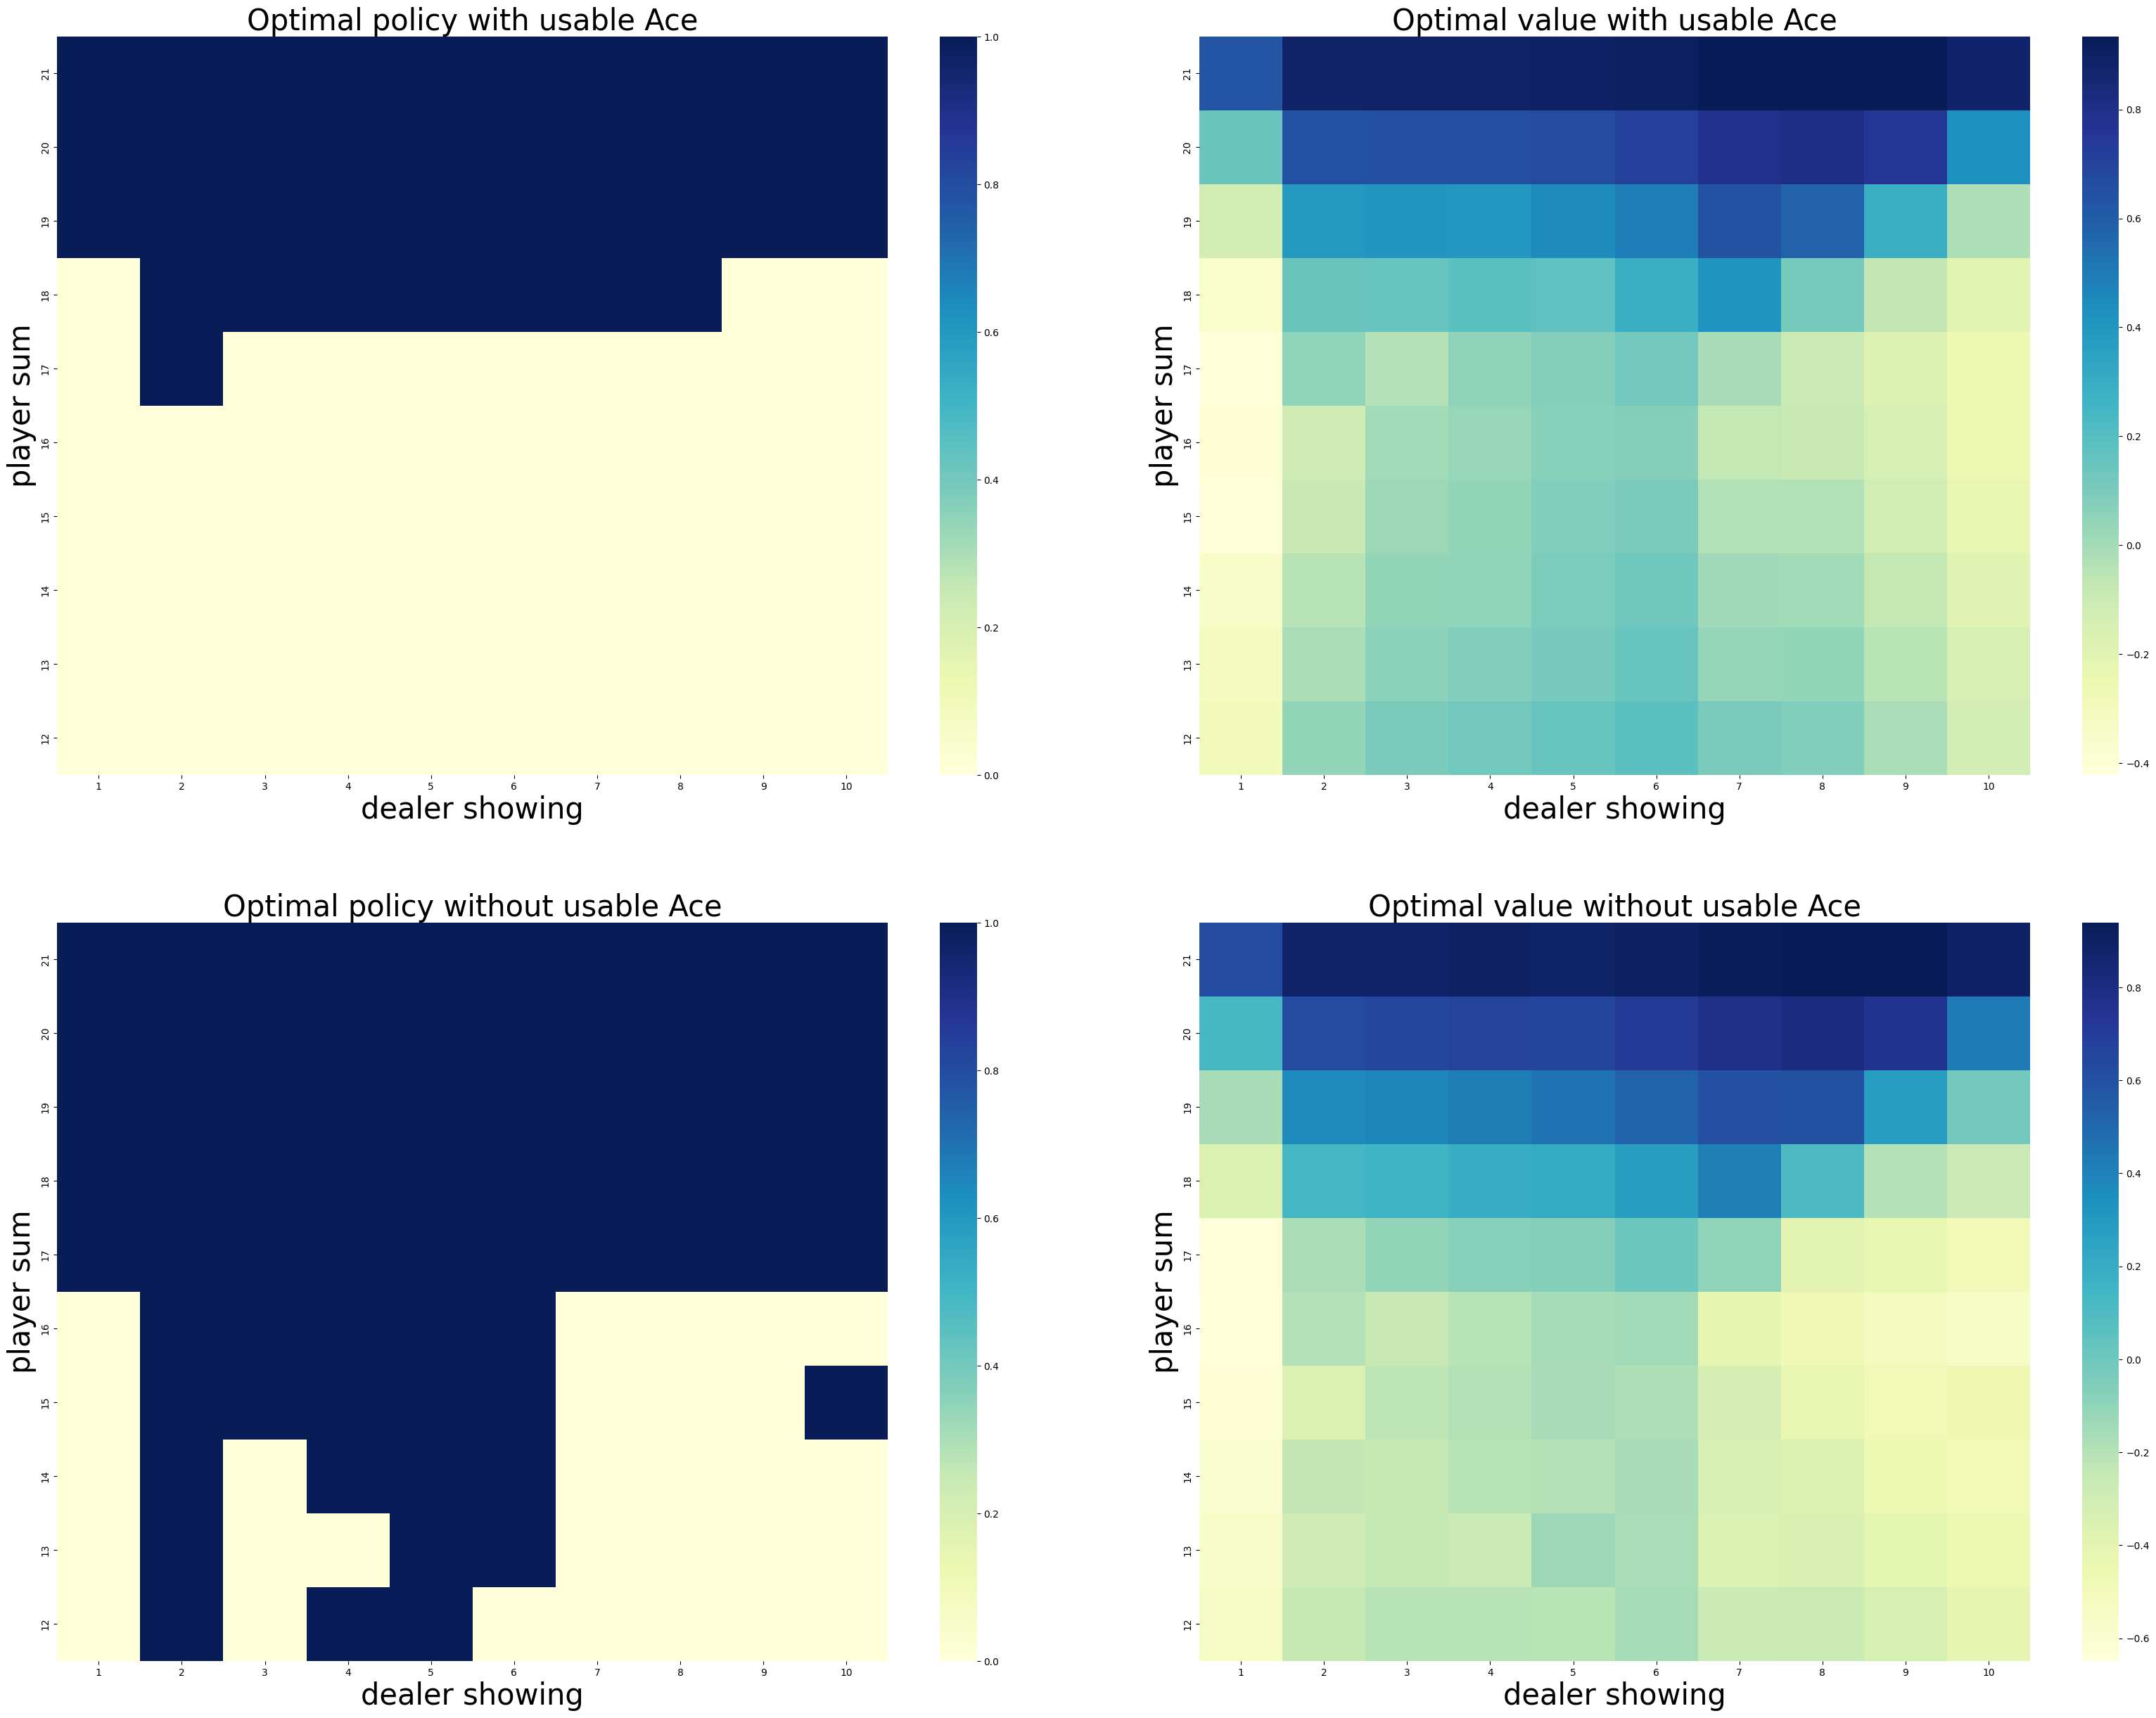

Checkpoint 2 of 8


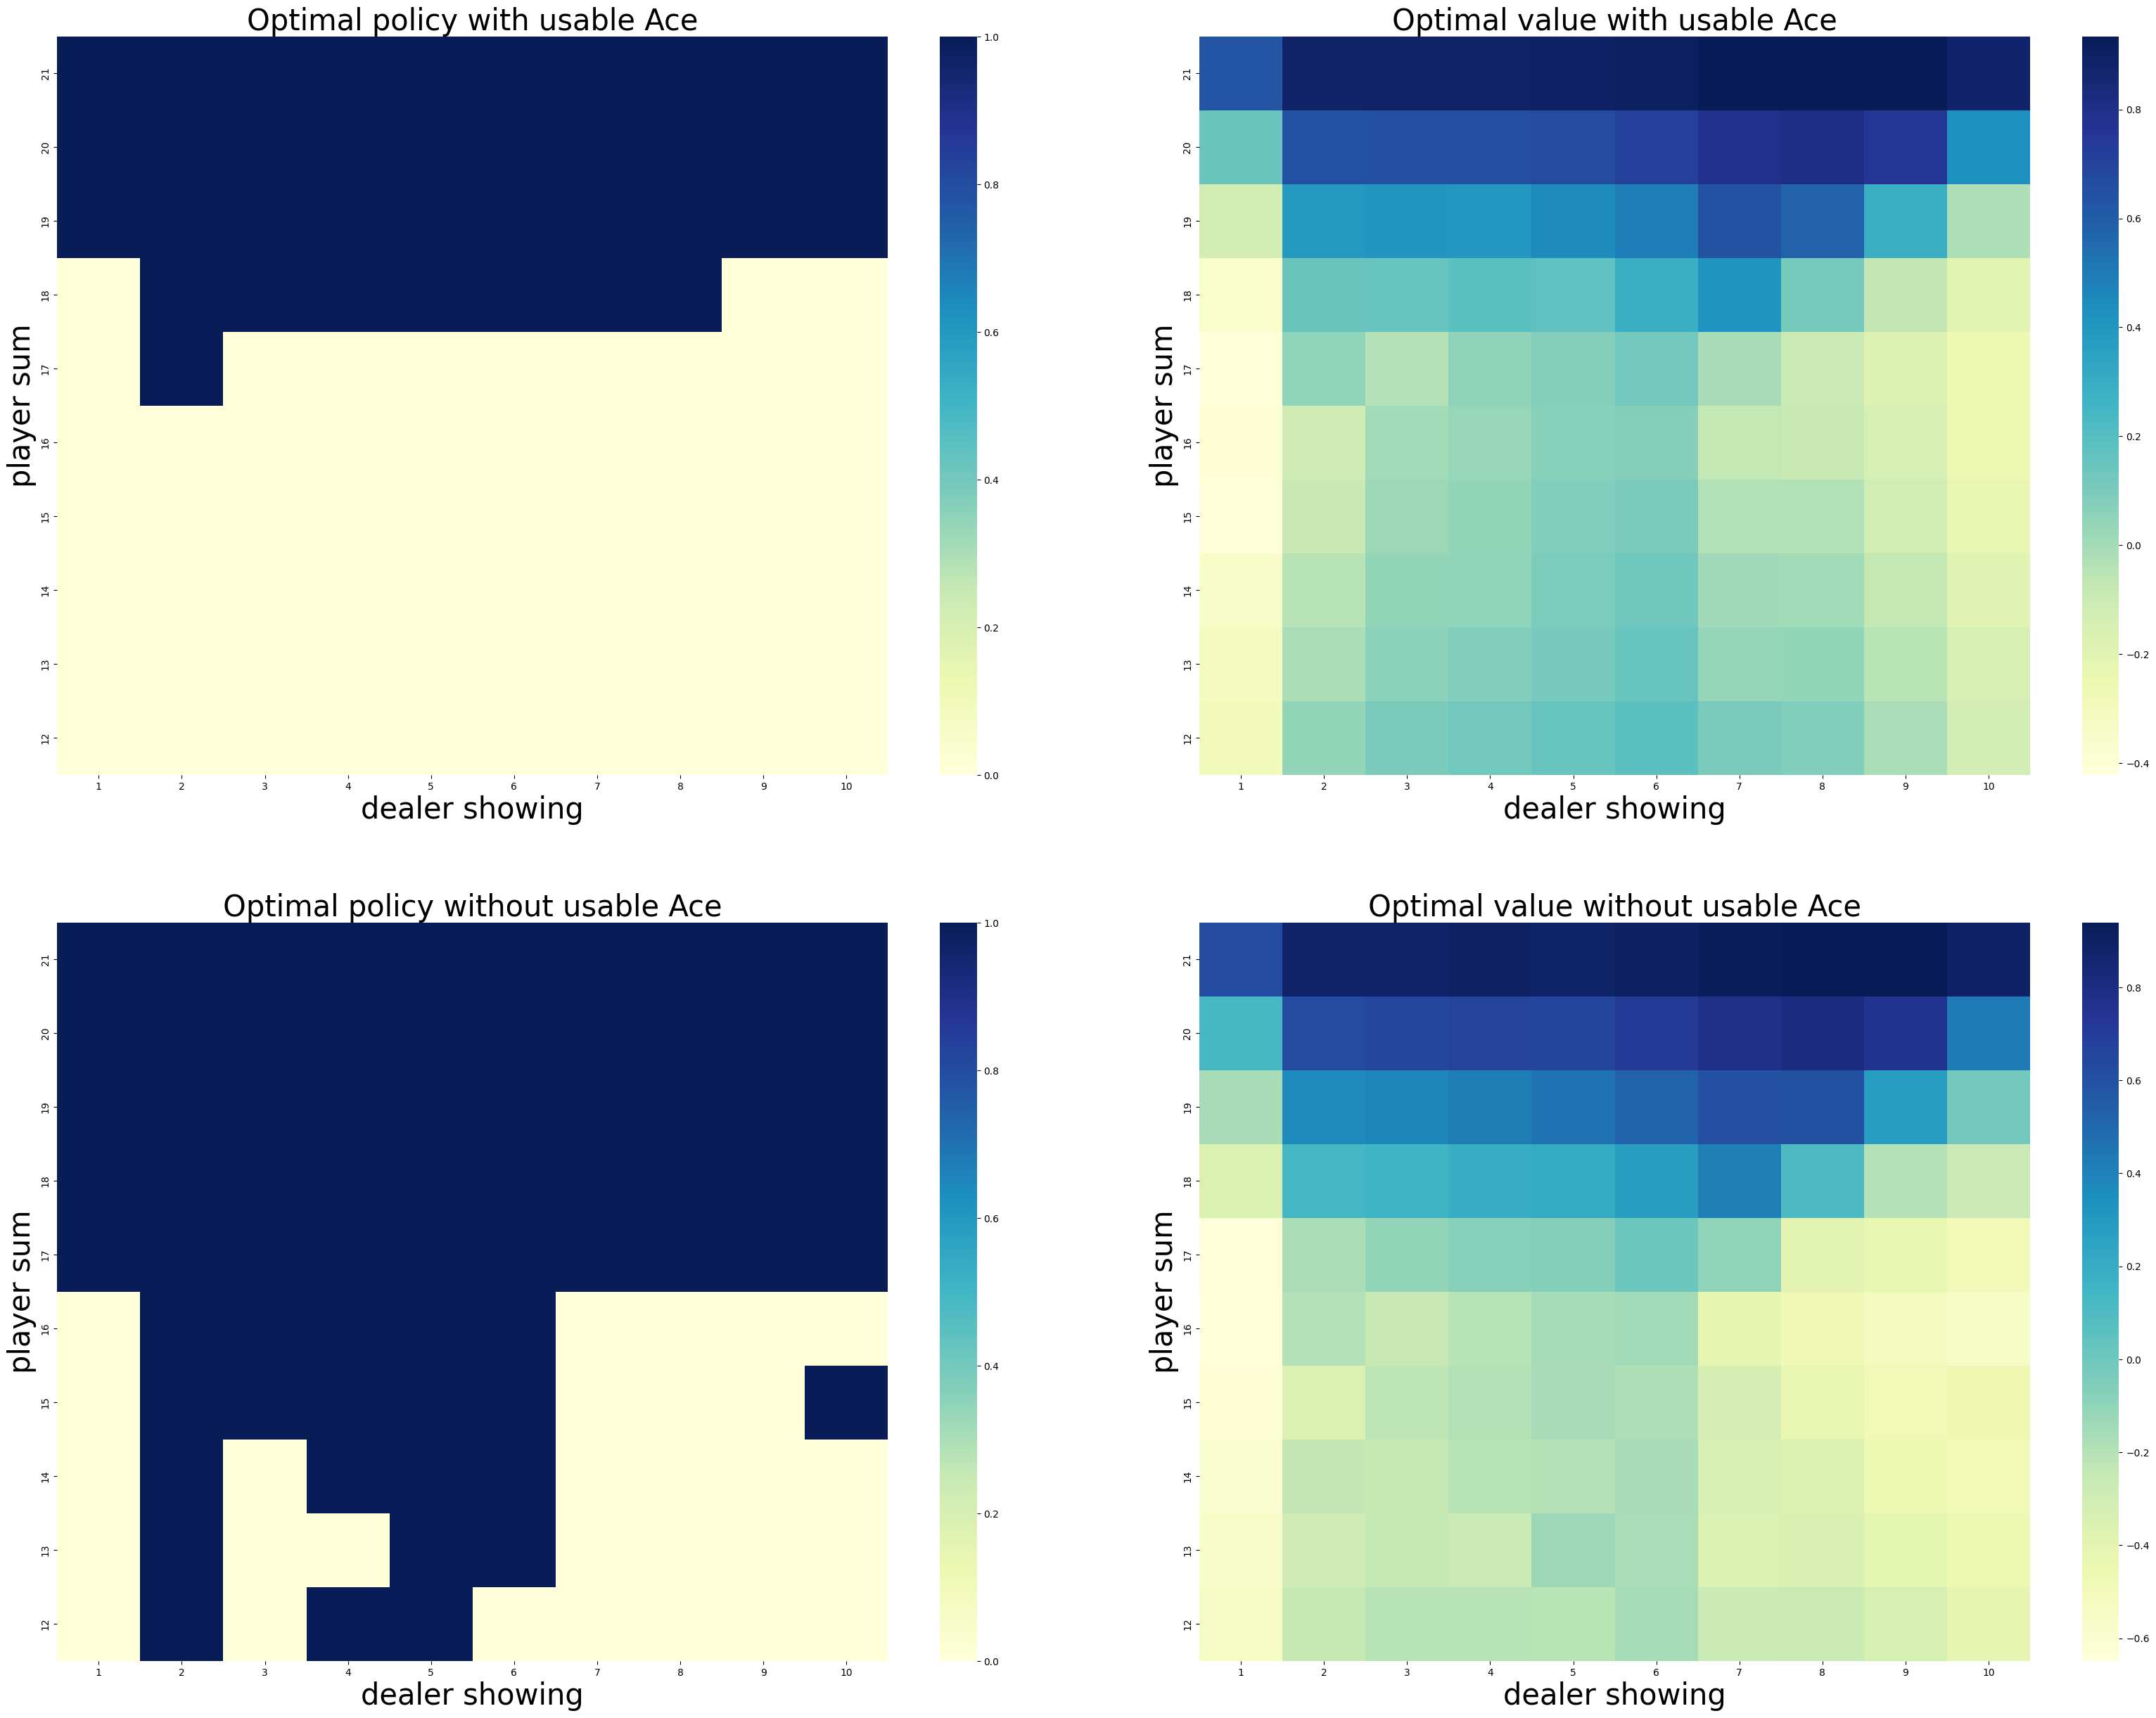

Checkpoint 3 of 8


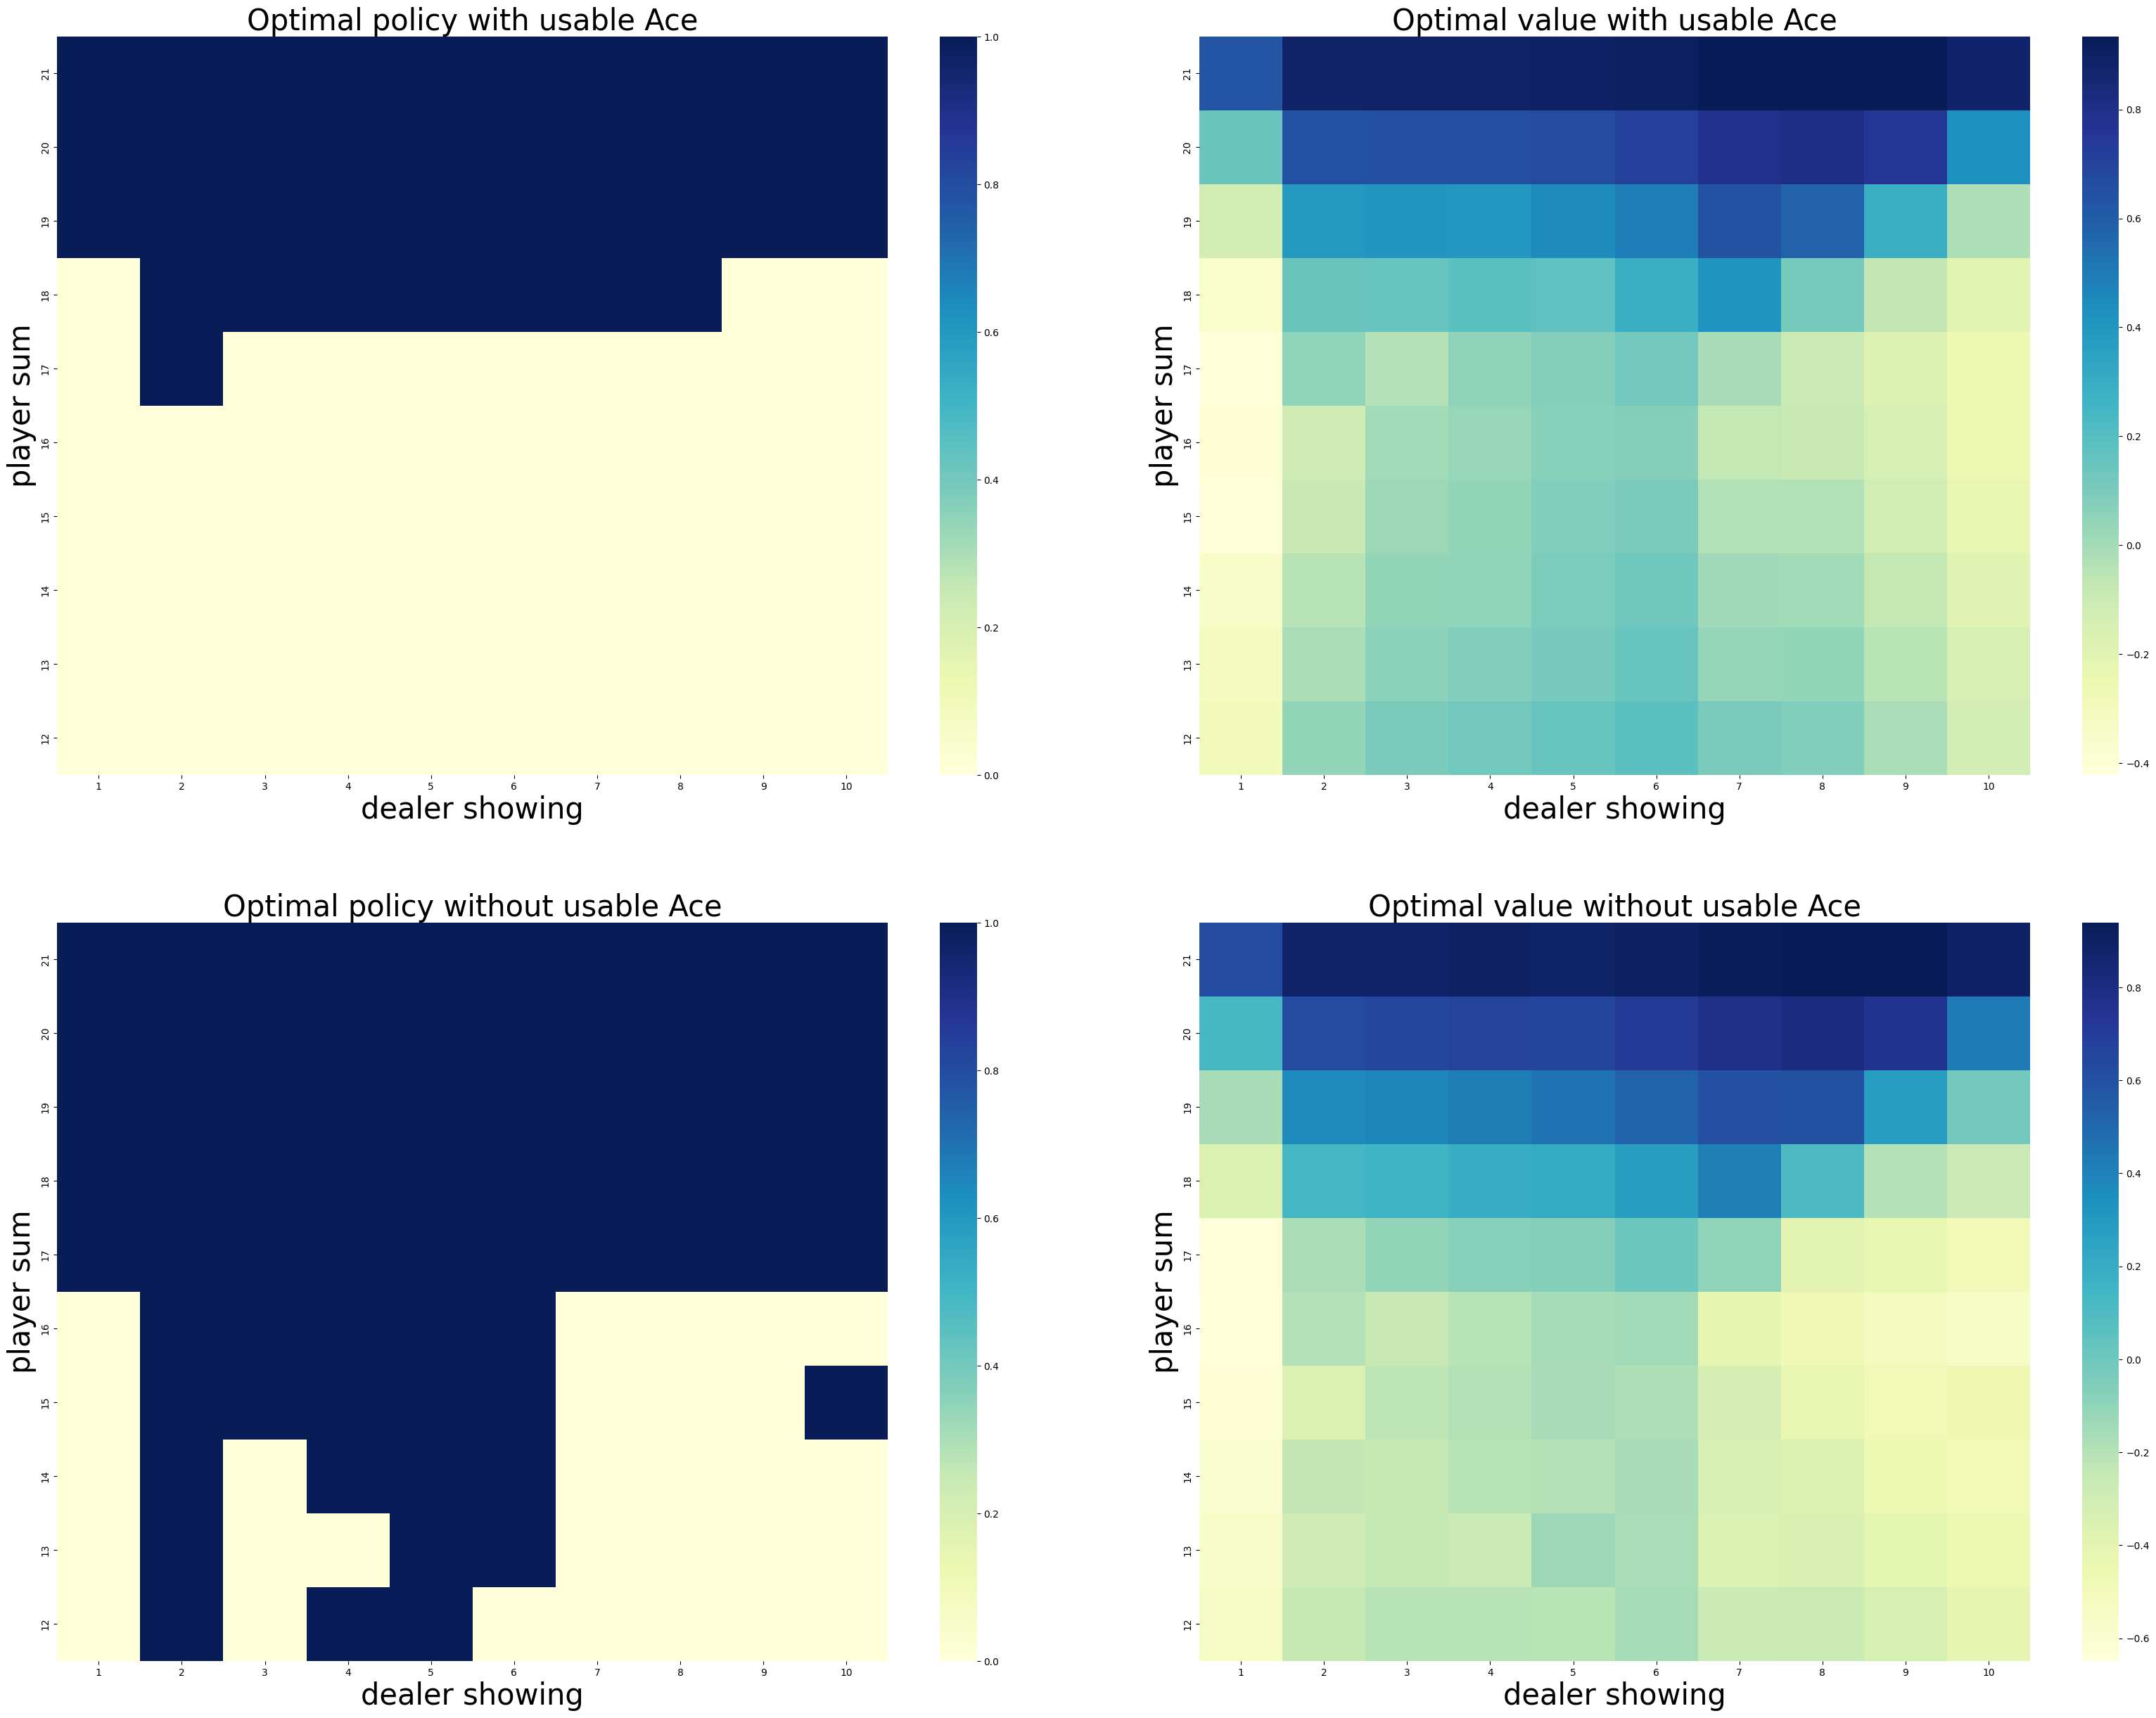

Checkpoint 4 of 8


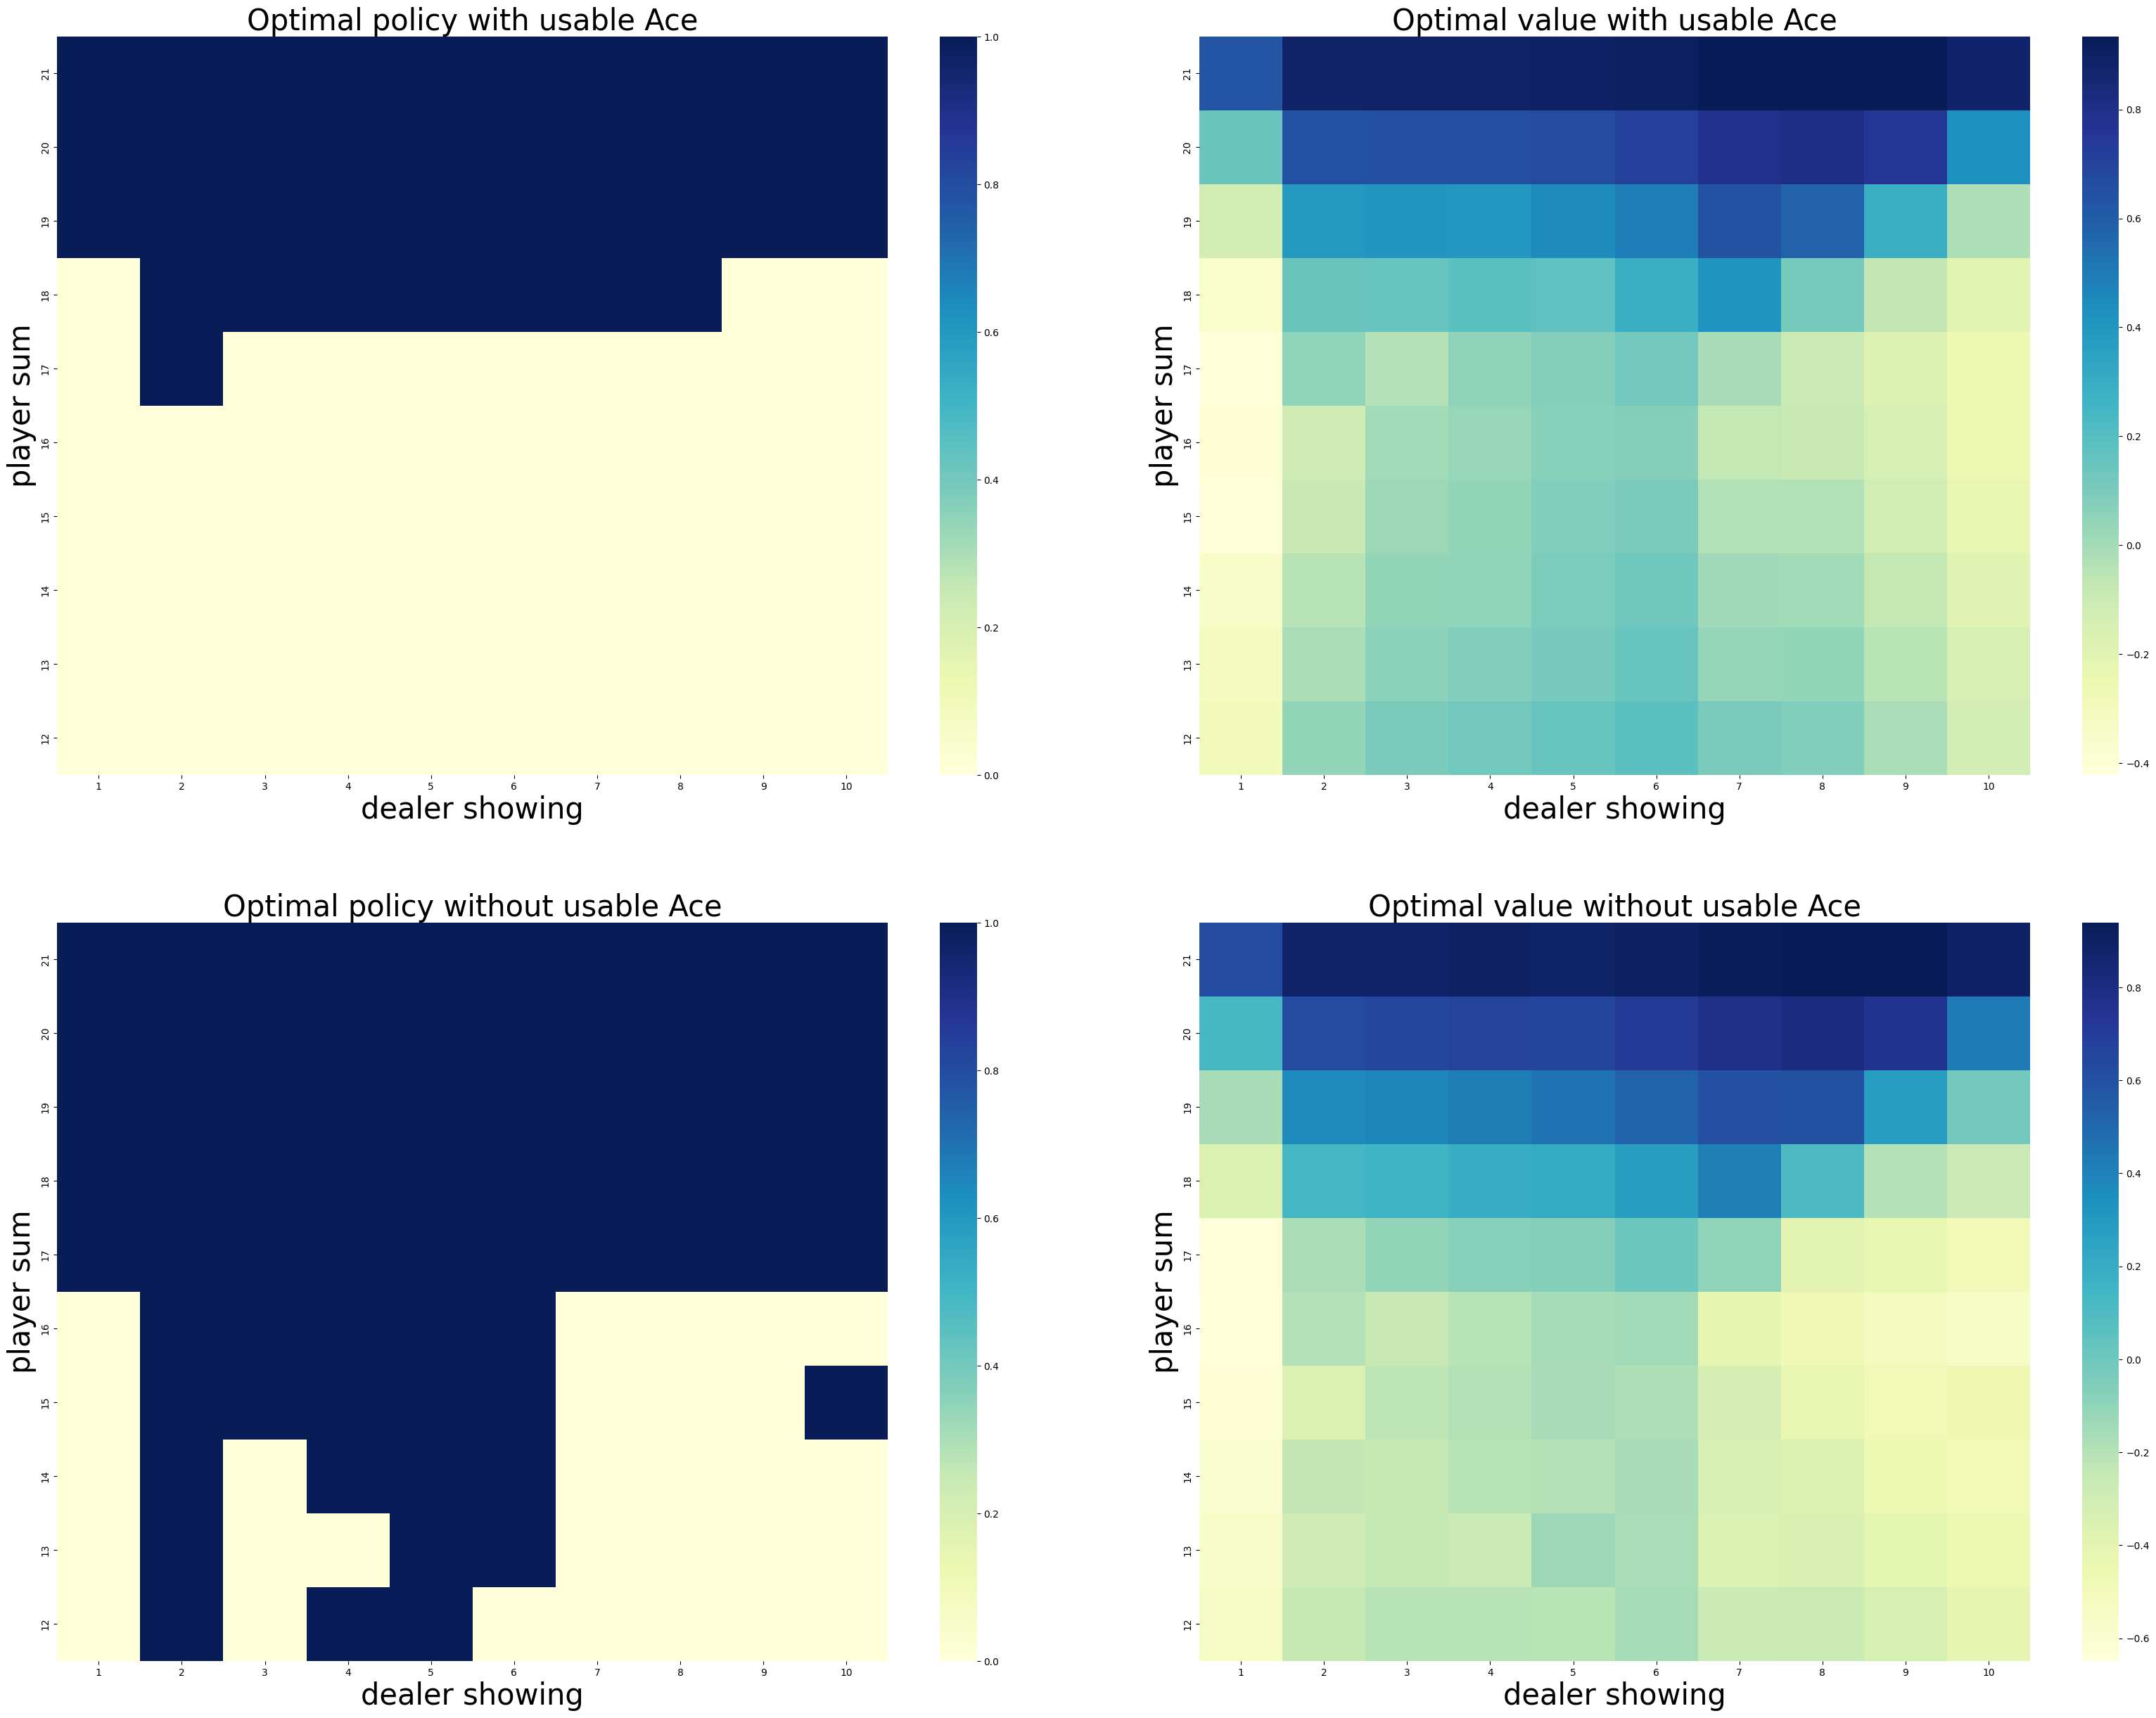

Checkpoint 5 of 8


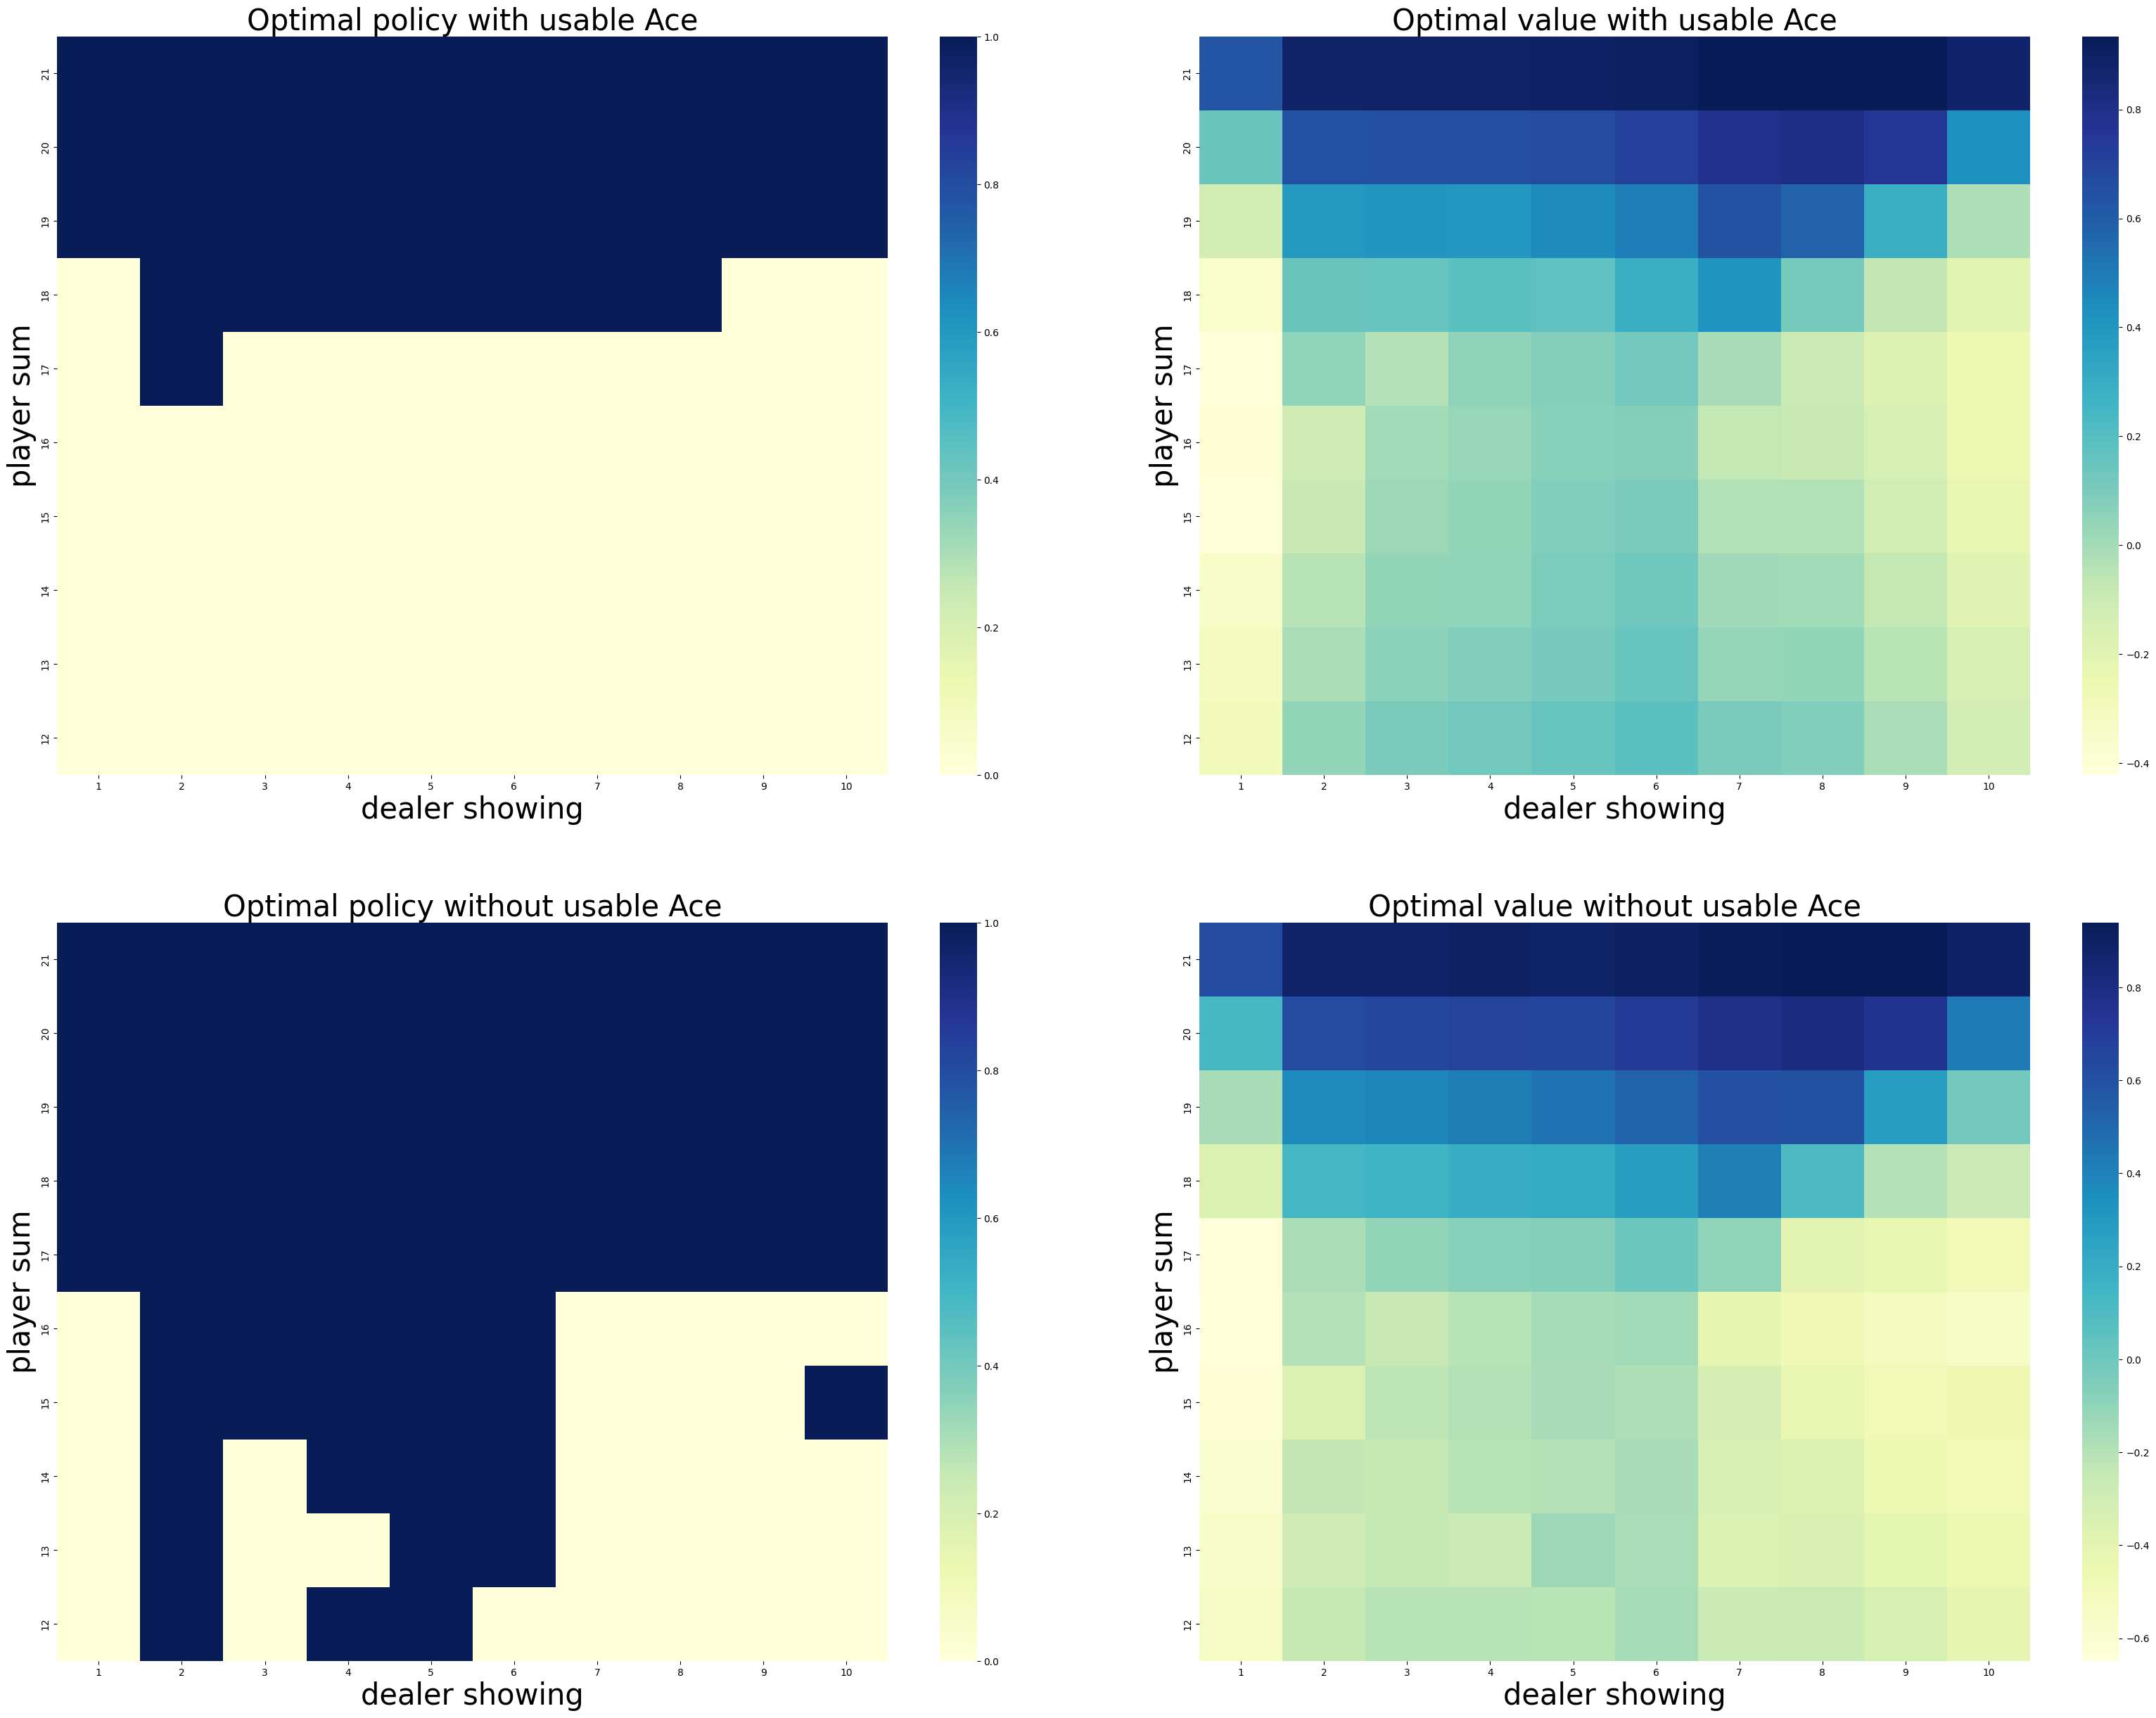

Checkpoint 6 of 8


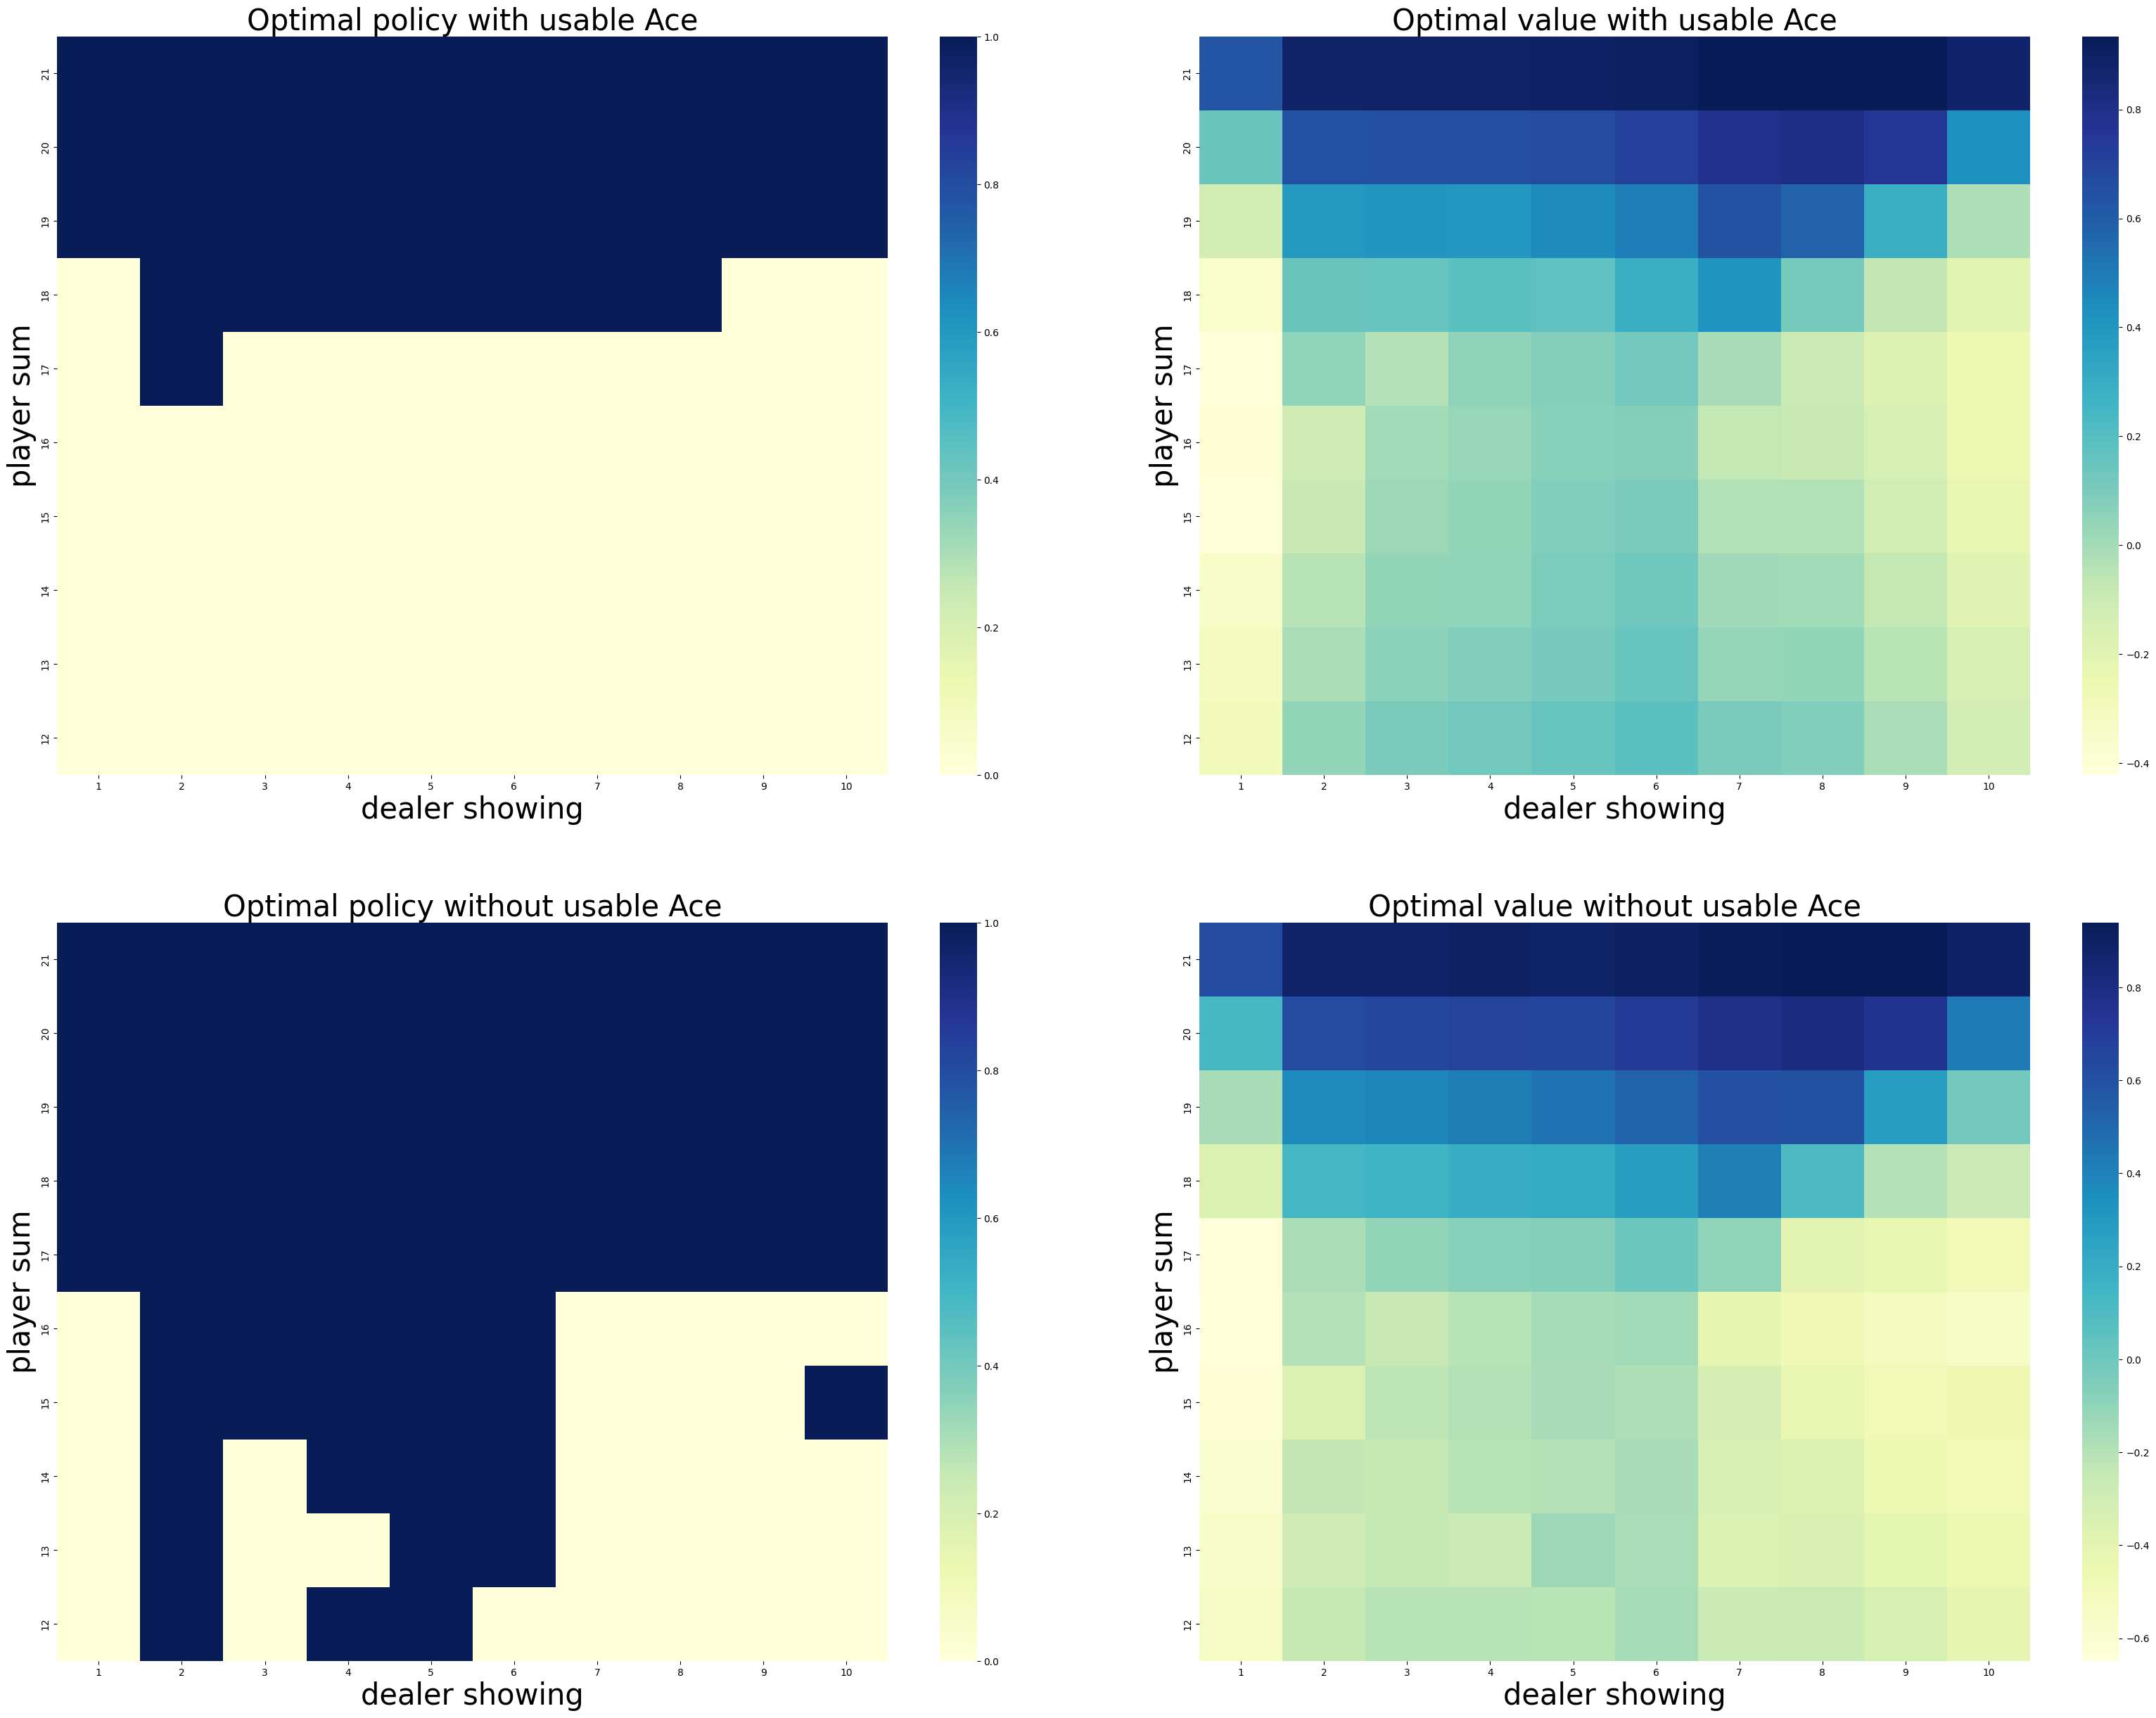

Checkpoint 7 of 8


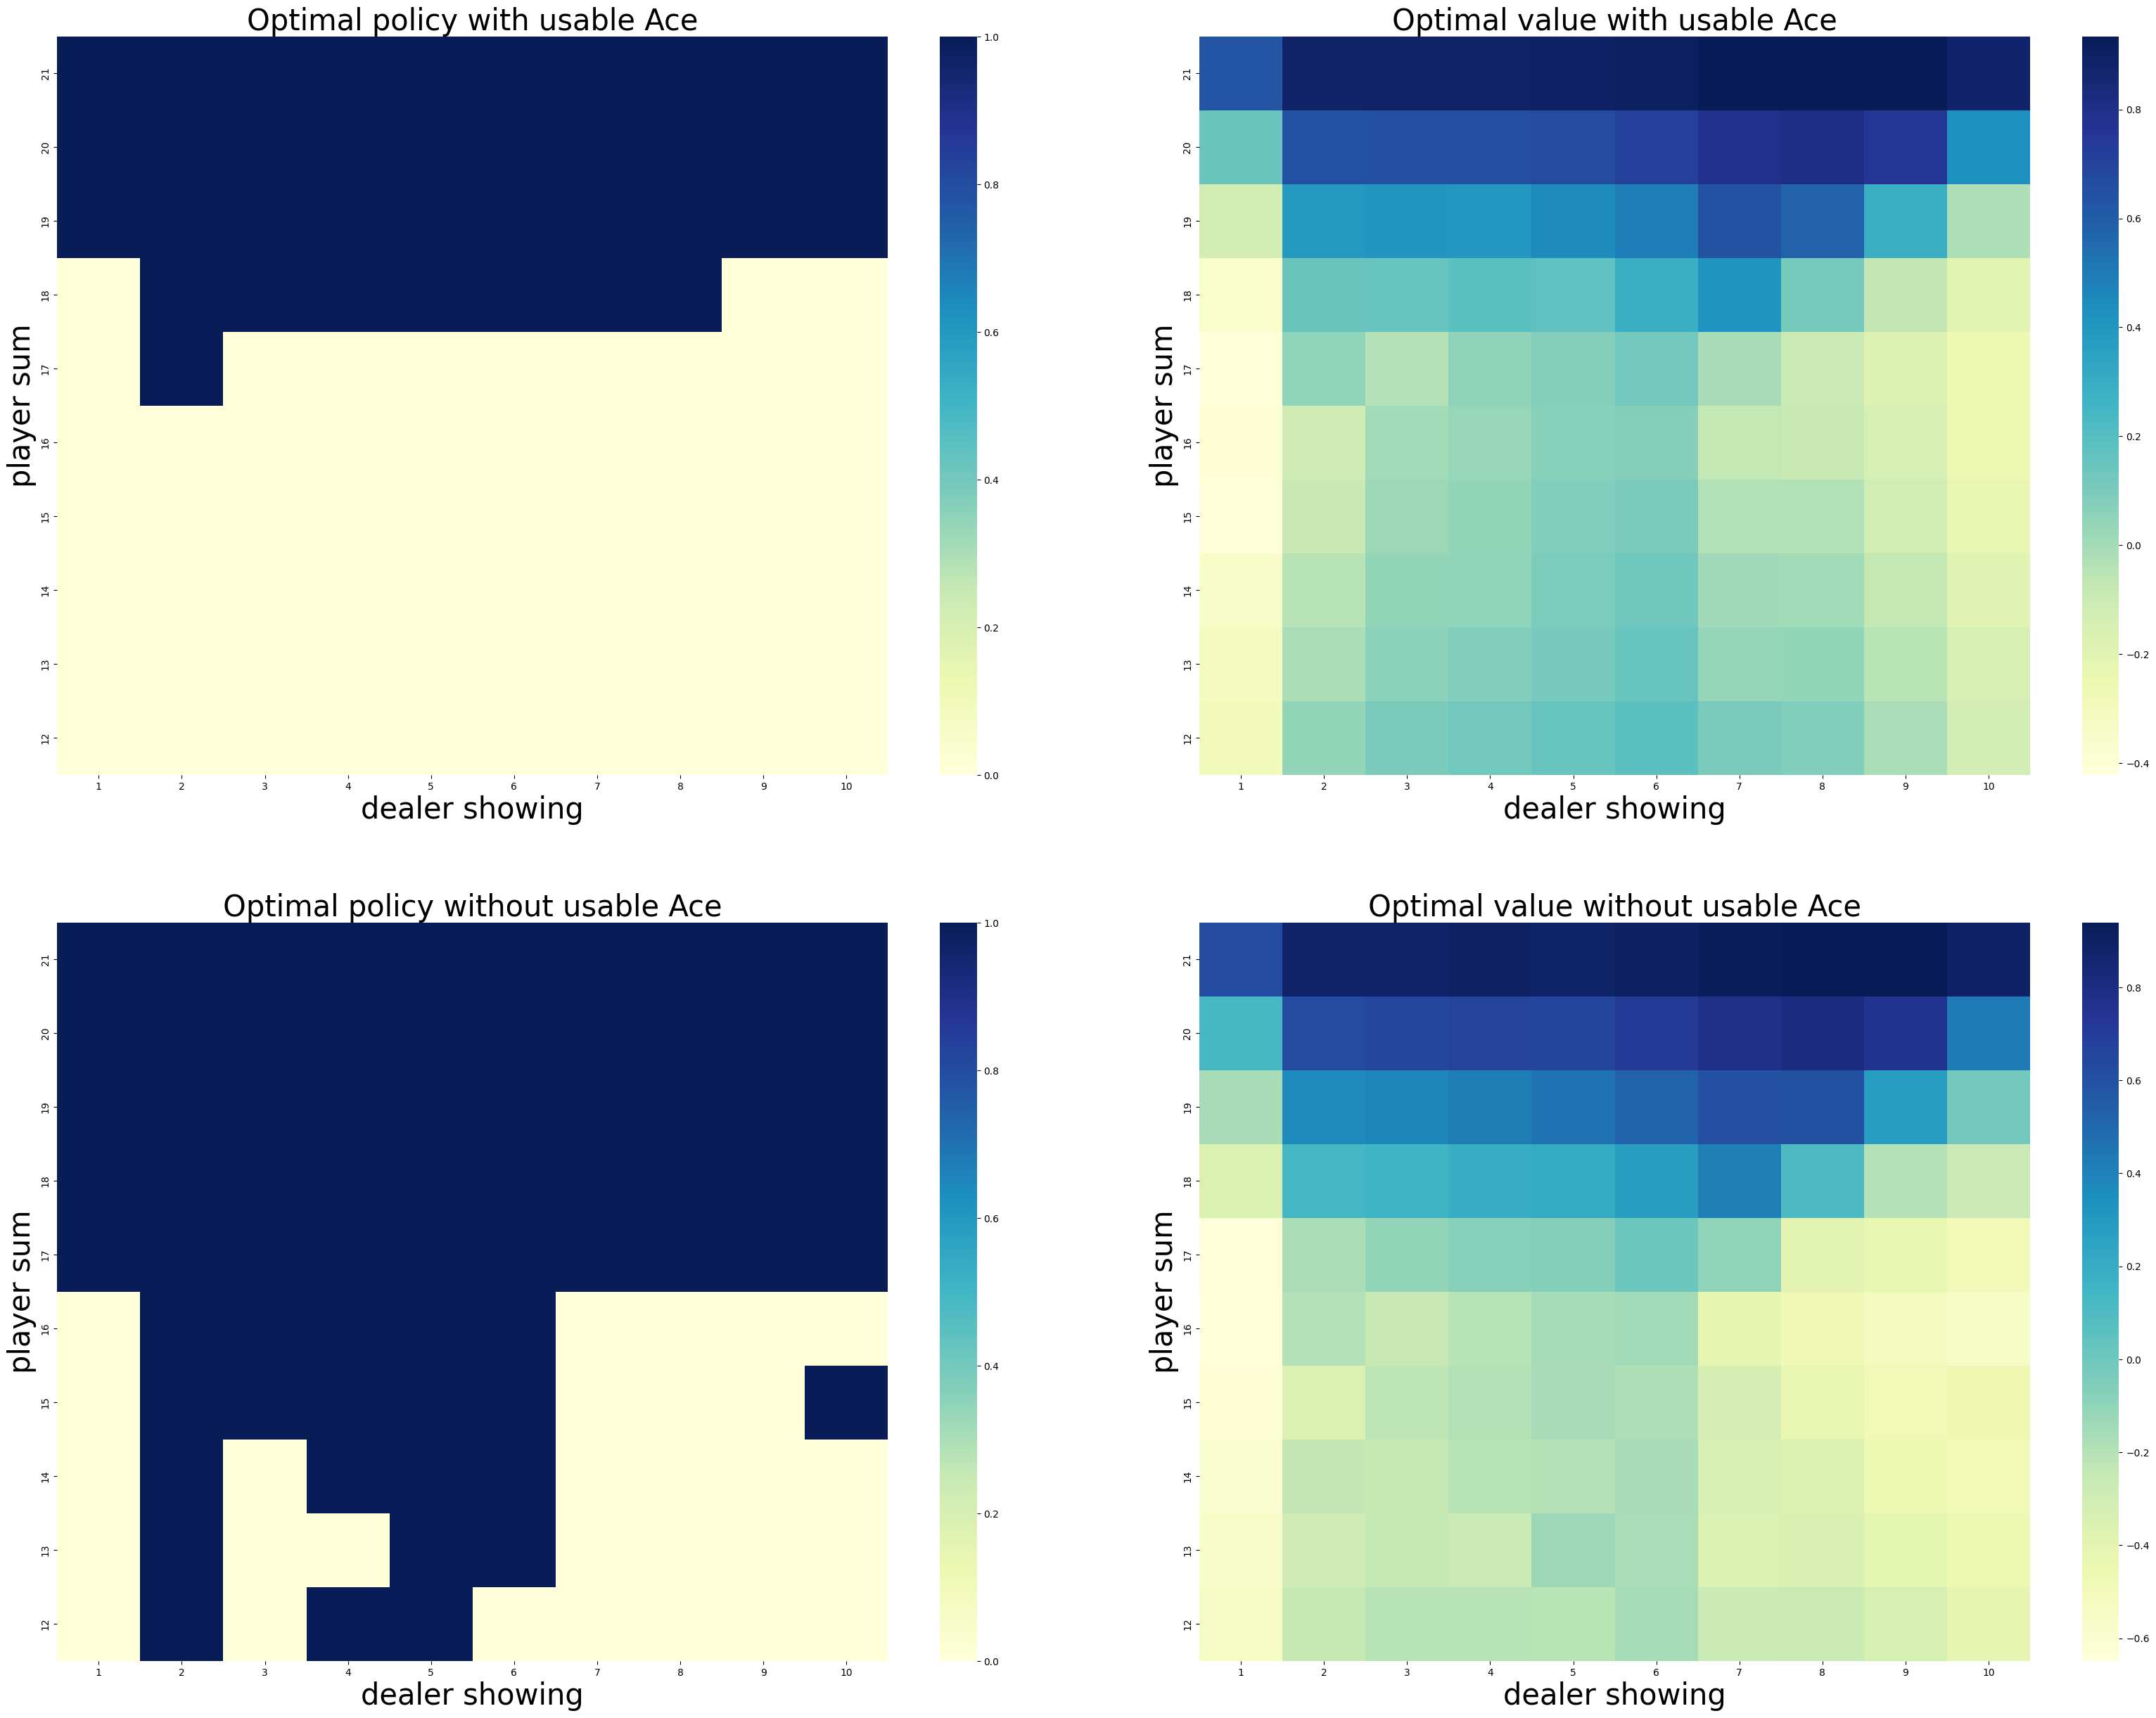

Checkpoint 8 of 8


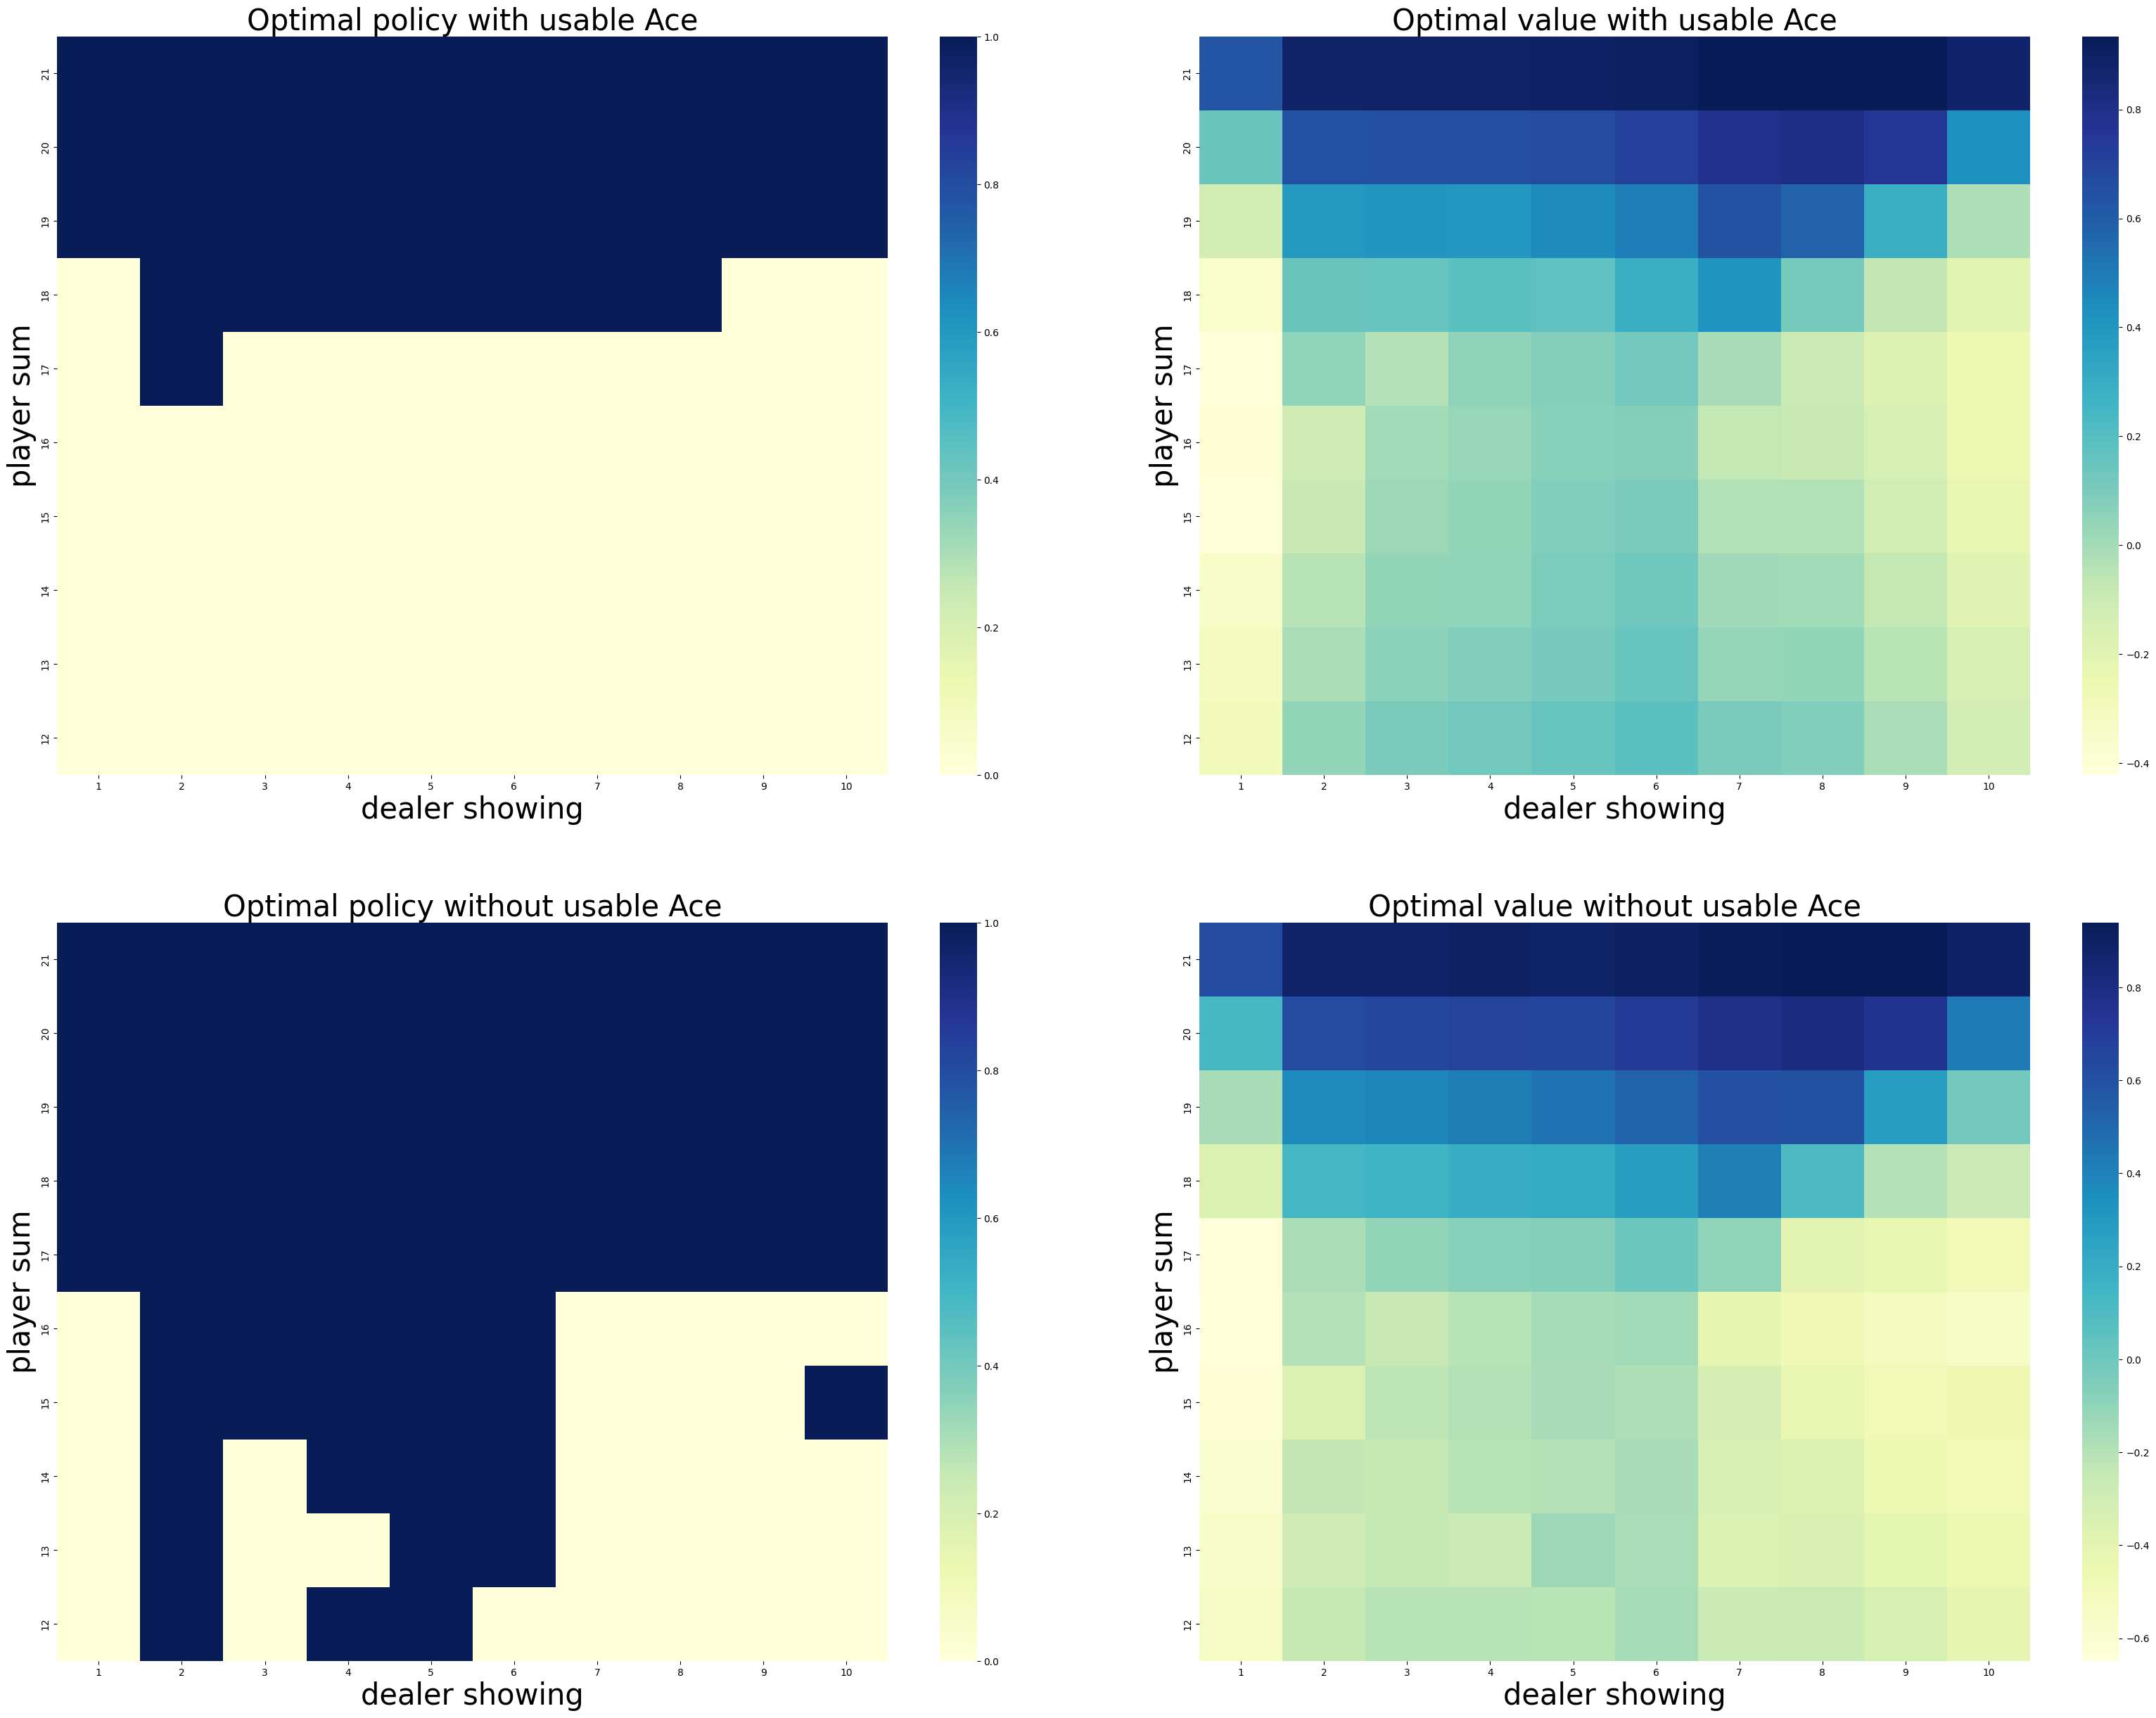

In [ ]:
figure_5_5(episodes=1500000,alpha=0.2,epsilon=0.05,ckpts=[300000,500000,650000,800000,1000000,1200000,1350000])

# 2 - CartPole

In [ ]:
!pip install gymnasium

In [ ]:
!apt-get install -y xvfb python-opengl
!pip install --upgrade pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics,RecordVideo
env = gym.make('CartPole-v1')
# env= gym.make("CartPole-v1", render_mode="human")
print( env.observation_space, env.action_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32) Discrete(2)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

VIDEO_DIR = '/content/gdrive/MyDrive/gym-videos'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from pyvirtualdisplay import Display

# Start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# Episodic Semi-gradient SARSA
def e_s_g_sarsa(env,episodes,w = np.random.rand(2, 4),alpha=0.2,epsilon=.05,gamma=0.99):
  progress_bar = tqdm(range(episodes))
  episode_rewards = []
  for episode in progress_bar:
    state = env.reset()
    state = state[0]
    action = epsilon_greedy(state,w,epsilon)
    total_reward = 0
    done = False
    if episode%200 == 0 and episode > 0:
      progress_bar.set_description(f"Avg reward so far = {np.mean(episode_rewards):.4f}")

    while not done:
      next_state, reward, done, truncated, info = env.step(action)
      total_reward += reward
      if done:
        w[action] += alpha*(reward-np.dot(w[action],state))*state
        episode_rewards.append(total_reward)
        break
      next_action = epsilon_greedy(next_state,w,epsilon)
      w[action] += alpha*(reward+gamma*np.dot(w[next_action],next_state)-np.dot(w[action],state))*state
      state = next_state
      action = next_action
    epsilon *= .9999
    alpha *= .9999
  return w   

def epsilon_greedy(state,w,epsilon):
  # print(f"w[0],state={w[0],state}")
  qs = [np.dot(w[0],state),np.dot(w[1],state)]
  # print(f"qs = {qs}")
  if np.random.random() < epsilon:
    return np.random.choice([0,1])
  else:
    return np.random.choice([a for a, q in enumerate(qs) if q == np.max(qs)])

In [ ]:
env = gym.make('CartPole-v1')
trained_w = e_s_g_sarsa(env,50000,alpha=0.2,epsilon=.5)
print(trained_w)

Avg reward so far = 27.2276: 100%|██████████| 50000/50000 [02:00<00:00, 415.47it/s]

[[ -5.8014576    3.26830633  71.11039915 -17.58108083]
 [  4.87367653  -6.02454699 -68.11771964  15.76936853]]


In [ ]:
env= gym.make("CartPole-v1", render_mode="rgb_array")

env = RecordVideo(env, video_folder=VIDEO_DIR,)
for _ in range(10):
    done = False
    state = env.reset()
    state = state[0]
    action = epsilon_greedy(state,trained_w,epsilon=0)
    while not done:
      env.render()
      state, reward, done, truncated, info = env.step(action)
      action = epsilon_greedy(state,trained_w,epsilon=0)

env.env.close()

Moviepy - Building video /content/gdrive/MyDrive/gym-videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/gym-videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/gym-videos/rl-video-episode-0.mp4


Moviepy - Building video /content/gdrive/MyDrive/gym-videos/rl-video-episode-1.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/gym-videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/gym-videos/rl-video-episode-1.mp4
Moviepy - Building video /content/gdrive/MyDrive/gym-videos/rl-video-episode-8.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/gym-videos/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/gym-videos/rl-video-episode-8.mp4


These models are not learning to perform particularly well. There is not much point in trying to include the videos here, since the pole falls almost right away in all of them. I'm not sure why - as far as I can tell, the algorithm is correct.